In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
import pandas

from matplotlib import pyplot as plt
import pyspark
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import neighbors


#Interactive Map
import folium
import ipywidgets as widgets  
from ipywidgets import SelectMultiple, SelectionRangeSlider
from tabulate import tabulate

#Correlation
import csv

from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("CS504_Project").getOrCreate()
from pyspark.sql.functions import *
from datetime import date, datetime
import time
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

22/12/08 20:28:35 WARN Utils: Your hostname, Elizas-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.0.0.101 instead (on interface en0)
22/12/08 20:28:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/12/08 20:28:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/12/08 20:28:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/12/08 20:28:37 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


DataFrame[key: string, value: string]

In [2]:
####################################################################################################################################################################
# Read all files
####################################################################################################################################################################
# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","
file_type_csv = "csv"


country_distance = "data/country_distance.csv"

country_distance_df = spark.read.format(file_type_csv) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(country_distance)
country_distance_df.createOrReplaceTempView("COUNTRY_DISTANCE")

# War Events File.
war_events = "data/war_events.csv"

war = spark.read.format(file_type_csv) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(war_events)

# display(war)

# war.createOrReplaceTempView("WAR_EVENTS")

# Commodity Export File.
commodity_exports = "data/commodity_exports.csv"

exports_raw = spark.read.format(file_type_csv) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(commodity_exports)

exports = exports_raw.withColumn("Commodity", when(exports_raw.Commodity == "Dog or cat food; (not put up for retail sale), used in animal feeding","AnimalFodder") \
      .when(exports_raw.Commodity == "Wheat and meslin","Wheat") \
      .when(exports_raw.Commodity == "Iron ores and concentrates; including roasted iron pyrites","IronOre") \
      .when(exports_raw.Commodity == "Slag, dross; (other than granulated slag), scalings and other waste from the manufacture of iron or steel","Slag") \
      .when(exports_raw.Commodity == "Base metals, silver or gold, clad with platinum; not further worked than semi-manufactured","GoldOre") \
      .when(exports_raw.Commodity == "Cereal groats and meal; of maize (corn)","Corn") \
     .when(exports_raw.Commodity == "Vegetable oils; sunflower seed or safflower oil and their fractions, other than crude, whether or not refined, but not chemically modified","SunflowerOil") \
     .when(exports_raw.Commodity == "Vegetable oils; low erucic acid rape or colza oil and its fractions, crude","RapeseedOil") \
     .when(exports_raw.Commodity == "Copper ores and concentrates","Copper") \
     .when(exports_raw.Commodity == "Coal; anthracite, whether or not pulverised, but not agglomerated","Coal") \
     .when(exports_raw.Commodity == "Oils; petroleum oils and oils obtained from bituminous minerals, crude","CrudePetroleum") \
     .when(exports_raw.Commodity == "Petroleum gases and other gaseous hydrocarbons; liquefied, natural gas","RefinedPetroleum") \
     .when(exports_raw.Commodity == "Iron or steel, pig iron, spiegeleisen; granules thereof","Steel") \
     .when(exports_raw.Commodity == "Steel, stainless; cold-drawn or cold-rolled, tubes and pipes of circular cross-section","RolledSteel") \
     .when(exports_raw.Commodity == "Cooking appliances and plate warmers; for gas fuel or for both gas and other fuels, of iron or steel","Gas") \
     .when(exports_raw.Commodity == "Steel, stainless; table, kitchen and other household articles and parts thereof","StainlessSteel") \
     .when(exports_raw.Commodity == "Iron or steel; cast articles, excluding grinding balls and similar articles for mills, other than of non-malleable cast iron","CastIron") \
     .when(exports_raw.Commodity == "Nickel; unwrought, not alloyed","Nickel") \
     .when(exports_raw.Commodity == "Aluminium; unwrought, alloys","Aluminium") \
     .when(exports_raw.Commodity == "Barley","Barley") \
      )


exports=exports.withColumnRenamed("Netweight (kg)","NETWEIGHT").withColumnRenamed("Trade Value (US$)", "TRADEVALUEINUSD")
# display(exports)
exports.createOrReplaceTempView("EXPORTS")

# Commodity Prices File.
commodity_prices = "data/commodity_prices.csv"

prices = spark.read.format(file_type_csv) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(commodity_prices)


prices=prices.withColumnRenamed("Date","Starting_Date")
# display(prices)
prices.createOrReplaceTempView("PRICES")

22/12/08 20:28:45 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [3]:
####################################################################################################################################################################
# Calculating the Year-Month for all Files
####################################################################################################################################################################
transform_war_events=war.withColumn("EVENT_YEAR_MONTH", date_format(to_date(concat(col("YEAR"), col("EVENT_MONTH")),"yyyyMMM"),"yyyyMM"))
group_war_events=transform_war_events.groupBy("EVENT_YEAR_MONTH").agg(count("EVENT_TYPE").alias("COUNT_OF_EVENTS"))

# group_war_events.show()
group_war_events.createOrReplaceTempView("GROUP_EVENTS")

transform_exports=spark.sql(""" 
                               select  *,date_format(TO_DATE(Period,'yyyyMM'),'yyyyMM') as PERIOD_YEAR_MONTH from EXPORTS
                              """)
# transform_exports.show(3)
transform_exports.createOrReplaceTempView("GROUP_EXPORTS")

transform_prices=spark.sql(""" 
                               select  *,date_format(TO_DATE(Starting_Date,'MM/dd/yyyy'),'yyyyMM') as DATE_YEAR_MONTH from PRICES
                              """)
# transform_prices.show(3)
transform_prices.createOrReplaceTempView("GROUP_PRICES")

In [4]:
####################################################################################################################################################################
# Joining of all Files Based on Date
####################################################################################################################################################################
join_events_prices_exports=spark.sql(""" 
                               select  INT(EVENT_YEAR_MONTH), 
                                       INT(COUNT_OF_EVENTS),
                                       Reporter as REPORTER,
                                       Partner as PARTNER,
                                       GROUP_EXPORTS.Commodity,
                                       CASE
                                           WHEN INT(NETWEIGHT) is NULL THEN 1
                                           ELSE INT(NETWEIGHT)
                                       END AS NETWEIGHT,
                                       CASE
                                           WHEN INT(TRADEVALUEINUSD) is NULL  THEN 1
                                           ELSE INT(TRADEVALUEINUSD)
                                       END AS TRADEVALUEINUSD,
                                       
                                       CASE
                                           WHEN INT(NETWEIGHT) is NULL  AND INT(TRADEVALUEINUSD) is NULL  THEN 1
                                           WHEN INT(NETWEIGHT) is NULL                                    THEN INT(TRADEVALUEINUSD)
                                           WHEN INT(TRADEVALUEINUSD) is NULL                              THEN INT(NETWEIGHT)
                                           ELSE DOUBLE(NETWEIGHT) * DOUBLE(TRADEVALUEINUSD)
                                       END AS TOTAL_SOLD_USD,
                                       DOUBLE(Amount) as PRODUCERPRICE,
                                       Case
                                           When Partner = 'Ukraine' then INT(COUNTRY_DISTANCE.Ukraine)
                                           When Partner = 'Russian Federation' then INT(COUNTRY_DISTANCE.Russia)
                                       End as DISTANCE_COUNTRIES
                                       from 
                                       GROUP_EVENTS,
                                       GROUP_PRICES,
                                       GROUP_EXPORTS,
                                       COUNTRY_DISTANCE
                                       where
                                           EVENT_YEAR_MONTH = PERIOD_YEAR_MONTH
                                       AND PERIOD_YEAR_MONTH = DATE_YEAR_MONTH
                                       AND GROUP_EXPORTS.Commodity = GROUP_PRICES.Commodity
                                       AND COUNTRY_DISTANCE.Country = Reporter
                                     
                              """)
join_events_prices_exports.show()

+----------------+---------------+------------------+------------------+---------+---------+---------------+----------------+-------------+------------------+
|EVENT_YEAR_MONTH|COUNT_OF_EVENTS|          REPORTER|           PARTNER|Commodity|NETWEIGHT|TRADEVALUEINUSD|  TOTAL_SOLD_USD|PRODUCERPRICE|DISTANCE_COUNTRIES|
+----------------+---------------+------------------+------------------+---------+---------+---------------+----------------+-------------+------------------+
|          201809|           1363|            France|           Ukraine|    Wheat|  1290293|         334605|4.31738489265E11|  191.1444218|              2687|
|          201809|           1363|         Lithuania|Russian Federation|    Wheat|    20000|           6997|        1.3994E8|  191.1444218|              4484|
|          201809|           1363|           Finland|Russian Federation|    Steel|        1|             13|            13.0|        245.2|              3922|
|          201809|           1363|           H

In [5]:
join_events_prices_exports.coalesce(1).write.format("parquet").mode("overwrite").save("data/Joined_Events_Prices_Exports.parquet")

In [6]:
join_events_prices_exports.coalesce(1).write.format("csv").mode("overwrite").option("sep",",").option("header",True).save("data/Joined_Events_Prices_Exports.csv")

In [7]:
# join_events_prices_exports.show(4)

In [8]:

join_events_prices_exports=pd.read_parquet('data/Joined_Events_Prices_Exports.parquet', engine='pyarrow')
nRow, nCol = join_events_prices_exports.shape
print(f'There are {nRow} rows and {nCol} columns\n\n')
join_events_prices_exports.head(5)

There are 11477 rows and 10 columns




EVENT_YEAR_MONTH  COUNT_OF_EVENTS   REPORTER             PARTNER Commodity  \
0            201809             1363     France             Ukraine     Wheat   
1            201809             1363  Lithuania  Russian Federation     Wheat   
2            201809             1363    Finland  Russian Federation     Steel   
3            201809             1363    Hungary  Russian Federation     Wheat   
4            201809             1363    Hungary             Ukraine     Wheat   

   NETWEIGHT  TRADEVALUEINUSD  TOTAL_SOLD_USD  PRODUCERPRICE  \
0    1290293           334605    4.317385e+11     191.144422   
1      20000             6997    1.399400e+08     191.144422   
2          1               13    1.300000e+01     245.200000   
3      20000             3935    7.870000e+07     191.144422   
4      17685             5261    9.304078e+07     191.144422   

   DISTANCE_COUNTRIES  
0                2687  
1                4484  
2                3922  
3                5342  
4                1194

In [9]:
join_events_prices_exports.info()

join_events_prices_exports.isnull().sum()
print("Total missing values:",join_events_prices_exports.isna().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11477 entries, 0 to 11476
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   EVENT_YEAR_MONTH    11477 non-null  int32  
 1   COUNT_OF_EVENTS     11477 non-null  int32  
 2   REPORTER            11477 non-null  object 
 3   PARTNER             11477 non-null  object 
 4   Commodity           11477 non-null  object 
 5   NETWEIGHT           11477 non-null  int32  
 6   TRADEVALUEINUSD     11477 non-null  int32  
 7   TOTAL_SOLD_USD      11477 non-null  float64
 8   PRODUCERPRICE       11477 non-null  float64
 9   DISTANCE_COUNTRIES  11477 non-null  int32  
dtypes: float64(2), int32(5), object(3)
memory usage: 672.6+ KB
Total missing values: 0


In [10]:
numerical_cols=join_events_prices_exports.select_dtypes(['int64','float64','int32'])
categorical_cols = join_events_prices_exports.select_dtypes('object').columns
print("There are ",len(numerical_cols.columns), " numerical features and they are : \n", numerical_cols.columns)
print("There are ",len(categorical_cols), " categorical features and they are : \n", categorical_cols)

There are  7  numerical features and they are : 
 Index(['EVENT_YEAR_MONTH', 'COUNT_OF_EVENTS', 'NETWEIGHT', 'TRADEVALUEINUSD',
       'TOTAL_SOLD_USD', 'PRODUCERPRICE', 'DISTANCE_COUNTRIES'],
      dtype='object')
There are  3  categorical features and they are : 
 Index(['REPORTER', 'PARTNER', 'Commodity'], dtype='object')


In [11]:
# print(join_events_prices_exports)

In [12]:


commodity_list=join_events_prices_exports['Commodity'].astype(str).unique().tolist()
PARTNER_list=join_events_prices_exports['PARTNER'].astype(str).unique().tolist()

df_list=[]
for partner in PARTNER_list:
    partnerval=partner.replace(' ','')
    for commodity in commodity_list:
        dynamic_df_Name = "df_"+partnerval+"_commodity_"+commodity
        df_list.append(dynamic_df_Name)
        # locals()[dynamic_df_Name]=join_events_prices_exports[(join_events_prices_exports['PARTNER'] == partner) & (join_events_prices_exports['Commodity'] == commodity)]
        locals()[dynamic_df_Name]=join_events_prices_exports[(join_events_prices_exports['PARTNER'] == partner) & (join_events_prices_exports['Commodity'] == commodity)][["EVENT_YEAR_MONTH","COUNT_OF_EVENTS","TOTAL_SOLD_USD","PRODUCERPRICE","DISTANCE_COUNTRIES"]]

print(df_list)

['df_Ukraine_commodity_Wheat', 'df_Ukraine_commodity_Steel', 'df_Ukraine_commodity_Aluminium', 'df_Ukraine_commodity_StainlessSteel', 'df_Ukraine_commodity_Gas', 'df_Ukraine_commodity_CastIron', 'df_Ukraine_commodity_RapeseedOil', 'df_Ukraine_commodity_Barley', 'df_Ukraine_commodity_SunflowerOil', 'df_Ukraine_commodity_IronOre', 'df_Ukraine_commodity_Copper', 'df_Ukraine_commodity_CrudePetroleum', 'df_Ukraine_commodity_Coal', 'df_Ukraine_commodity_Slag', 'df_Ukraine_commodity_Corn', 'df_Ukraine_commodity_Nickel', 'df_Ukraine_commodity_RefinedPetroleum', 'df_RussianFederation_commodity_Wheat', 'df_RussianFederation_commodity_Steel', 'df_RussianFederation_commodity_Aluminium', 'df_RussianFederation_commodity_StainlessSteel', 'df_RussianFederation_commodity_Gas', 'df_RussianFederation_commodity_CastIron', 'df_RussianFederation_commodity_RapeseedOil', 'df_RussianFederation_commodity_Barley', 'df_RussianFederation_commodity_SunflowerOil', 'df_RussianFederation_commodity_IronOre', 'df_Russia

In [13]:
models_comparison_matrix = pd.DataFrame([],columns=['Regression_Commodity_Partner','Predictive_Analysis_Model', 'Coefficient_of_Determination','Mean_Absolute_Error', 'Root_Mean_Squared_Error'])

In [14]:
######################################################################################################################
#                                   Various Regression Models.                                                       #
#--------------------------------------------------------------------------------------------------------------------#
######################################################################################################################

linear_regression_model=LinearRegression()

decision_tree_regression_model=tree.DecisionTreeRegressor()

gradient_boost_regression_model = GradientBoostingRegressor()

KNN_regression_model=neighbors.KNeighborsRegressor(n_neighbors=10)

for df_name in df_list:  
    # print(df_name.split("_")[1] + "_" + df_name.split("_")[3])
    if locals()[df_name].shape[0] > 1:
        X=locals()[df_name].drop(columns="TOTAL_SOLD_USD")
        Y=locals()[df_name]['TOTAL_SOLD_USD']
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2,random_state=0)
######################################################################################################################        
#                                              Linear Regression                                                     #
######################################################################################################################
        clf=linear_regression_model.fit(x_train, y_train)
        # print("x_train",x_train)
        # print("y_train",y_train)
        # print("Coefficient/Slope : ", clf.coef_)
        # print("Intercept : ", clf.intercept_)
        linear_regression_predictions = linear_regression_model.predict(x_test)
        clf.score(x_test,y_test)
        linear_regression_model_mae=mean_absolute_error(y_test, linear_regression_predictions)
        linear_regression_model_rmse=np.sqrt(metrics.mean_squared_error(y_test, linear_regression_predictions))
        linear_regression_model_score=clf.score(x_test,y_test)
        # print("\n\nMean Absolute Error:",linear_regression_model_mae)
        # print("RMSE: ",linear_regression_model_rmse)
        # print("Accuracy score of the model : ", linear_regression_model_score)
        models_comparison_matrix = models_comparison_matrix.append({
            'Regression_Commodity_Partner': df_name.split("_")[1] + "_" + df_name.split("_")[3], 
            'Predictive_Analysis_Model': linear_regression_model.__class__.__name__,
            'Coefficient_of_Determination': linear_regression_model_score,
            'Mean_Absolute_Error' : linear_regression_model_mae,
            'Root_Mean_Squared_Error':linear_regression_model_rmse
        }, ignore_index=True)
######################################################################################################################        
#                                       Decision Tree Regression                                                     #
######################################################################################################################
        decision_tree_regression_model.fit(x_train, y_train)
        decision_tree_regression_predictions = decision_tree_regression_model.predict(x_test)
        decision_tree_regression_model_mae=mean_absolute_error(y_test, decision_tree_regression_predictions)
        decision_tree_regression_model_rmse=np.sqrt(metrics.mean_squared_error(y_test, decision_tree_regression_predictions))
        decision_tree_regression_model_score=decision_tree_regression_model.score(x_test,y_test)
        # print("\n\nMean Absolute Error:",decision_tree_regression_model_mae)
        # print("RMSE: ",decision_tree_regression_model_rmse)
        # print("Accuracy score of the model : ", decision_tree_regression_model_score)
        models_comparison_matrix = models_comparison_matrix.append({
            'Regression_Commodity_Partner': df_name.split("_")[1] + "_" + df_name.split("_")[3],
            'Predictive_Analysis_Model': decision_tree_regression_model.__class__.__name__ + "_with_" + str(decision_tree_regression_model.get_params()['max_leaf_nodes']) + "_max_leaf_modes",
            'Coefficient_of_Determination': decision_tree_regression_model_score,
            'Mean_Absolute_Error' : decision_tree_regression_model_mae,
            'Root_Mean_Squared_Error':decision_tree_regression_model_rmse
        }, ignore_index=True)
######################################################################################################################        
#                                       Gradient Boost Regression                                                    #
######################################################################################################################        
        gradient_boost_regression_model.fit(x_train, y_train)
        gradient_boost_regression_predictions = gradient_boost_regression_model.predict(x_test)
        gradient_boost_regression_model_mae=mean_absolute_error(y_test, gradient_boost_regression_predictions)
        gradient_boost_regression_model_rmse=np.sqrt(metrics.mean_squared_error(y_test, gradient_boost_regression_predictions))
        gradient_boost_regression_model_score=gradient_boost_regression_model.score(x_test,y_test)
        # print("\n\nMean Absolute Error:",gradient_boost_regression_model_mae)
        # print("RMSE: ",gradient_boost_regression_model_rmse)
        # print("Accuracy score of the model : ", gradient_boost_regression_model_score)
        models_comparison_matrix = models_comparison_matrix.append({
            'Regression_Commodity_Partner': df_name.split("_")[1] + "_" + df_name.split("_")[3],
            'Predictive_Analysis_Model': gradient_boost_regression_model.__class__.__name__, 
            'Coefficient_of_Determination': gradient_boost_regression_model_score,
            'Mean_Absolute_Error' : gradient_boost_regression_model_mae,
            'Root_Mean_Squared_Error':gradient_boost_regression_model_rmse
        }, ignore_index=True)
######################################################################################################################        
#                                       KNN Neighbor(10 neighbors)                                                   #
######################################################################################################################
        KNN_regression_model.fit(x_train, y_train)
        KNN_regression_predictions = KNN_regression_model.predict(x_test)
        KNN_regression_model_mae=mean_absolute_error(y_test, KNN_regression_predictions)
        KNN_regression_model_rmse=np.sqrt(metrics.mean_squared_error(y_test, KNN_regression_predictions))
        KNN_regression_model_score=KNN_regression_model.score(x_test,y_test)
        # print("\n\nMean Absolute Error:",KNN_regression_model_mae)
        # print("RMSE: ",KNN_regression_model_rmse)
        # print("Accuracy score of the model : ", KNN_regression_model_score)
        models_comparison_matrix = models_comparison_matrix.append({
            'Regression_Commodity_Partner': df_name.split("_")[1] + "_" + df_name.split("_")[3],
            'Predictive_Analysis_Model': KNN_regression_model.__class__.__name__ + "_with_10_neighbors",
            'Coefficient_of_Determination': KNN_regression_model_score,
            'Mean_Absolute_Error' : KNN_regression_model_mae,
            'Root_Mean_Squared_Error':KNN_regression_model_rmse
        }, ignore_index=True)
######################################################################################################################        
#                                       FINAL RESULT.                                                               #
###################################################################################################################### 
print(models_comparison_matrix)


           Regression_Commodity_Partner  \
0                         Ukraine_Wheat   
1                         Ukraine_Wheat   
2                         Ukraine_Wheat   
3                         Ukraine_Wheat   
4                         Ukraine_Steel   
..                                  ...   
127            RussianFederation_Nickel   
128  RussianFederation_RefinedPetroleum   
129  RussianFederation_RefinedPetroleum   
130  RussianFederation_RefinedPetroleum   
131  RussianFederation_RefinedPetroleum   

                          Predictive_Analysis_Model  \
0                                  LinearRegression   
1    DecisionTreeRegressor_with_None_max_leaf_modes   
2                         GradientBoostingRegressor   
3             KNeighborsRegressor_with_10_neighbors   
4                                  LinearRegression   
..                                              ...   
127           KNeighborsRegressor_with_10_neighbors   
128                                LinearRe

In [15]:
print(tabulate(models_comparison_matrix, headers='keys', tablefmt='psql')) 

+-----+------------------------------------+------------------------------------------------+--------------------------------+-----------------------+---------------------------+
|     | Regression_Commodity_Partner       | Predictive_Analysis_Model                      |   Coefficient_of_Determination |   Mean_Absolute_Error |   Root_Mean_Squared_Error |
|-----+------------------------------------+------------------------------------------------+--------------------------------+-----------------------+---------------------------|
|   0 | Ukraine_Wheat                      | LinearRegression                               |                   -28.2758     |           1.5666e+12  |               1.84987e+12 |
|   1 | Ukraine_Wheat                      | DecisionTreeRegressor_with_None_max_leaf_modes |                  -161.321      |           1.11099e+12 |               4.35586e+12 |
|   2 | Ukraine_Wheat                      | GradientBoostingRegressor                      |            

In [16]:
################################################################################################################################################################################
################################################################################################################################################################################        
#                                                                       Visualization                                                                         #
################################################################################################################################################################################
################################################################################################################################################################################        

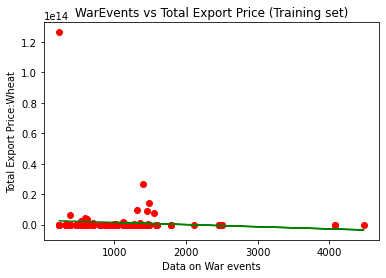

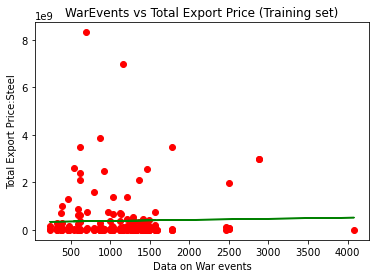

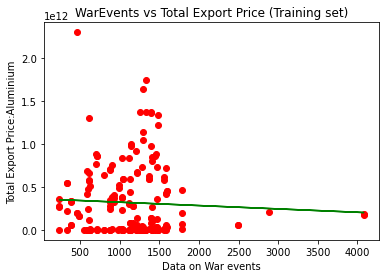

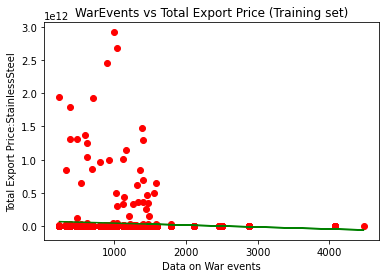

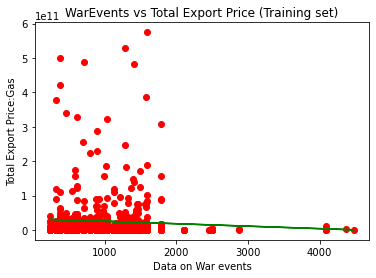

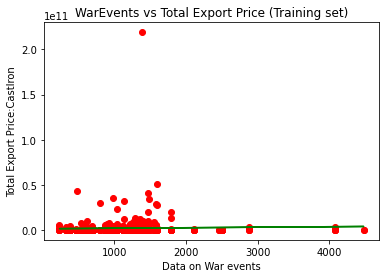

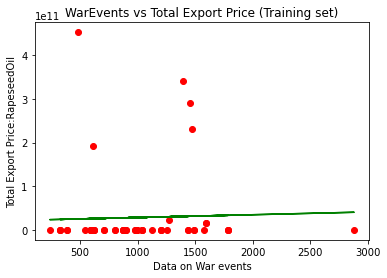

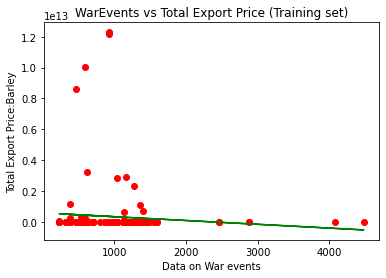

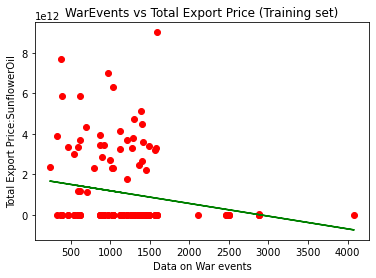

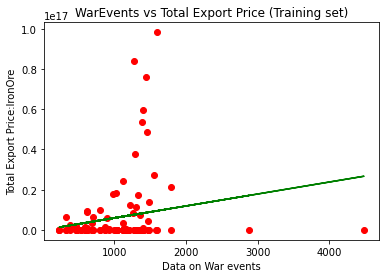

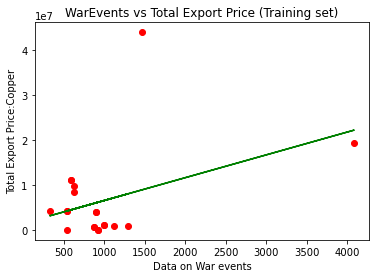

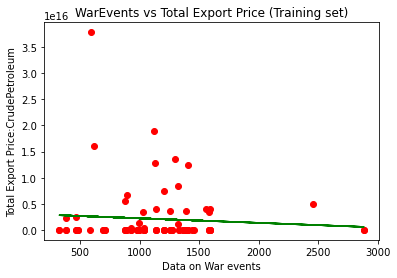

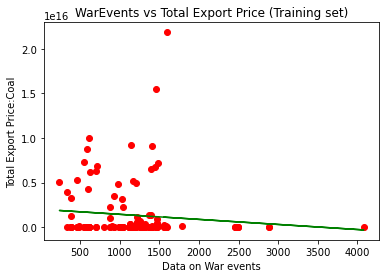

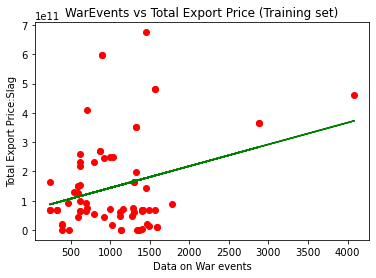

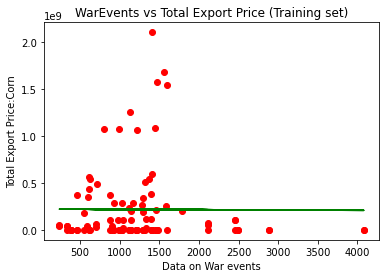

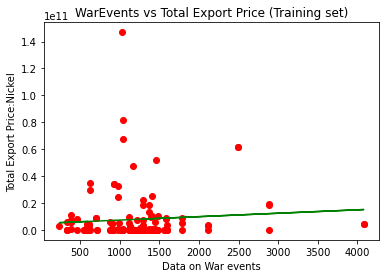

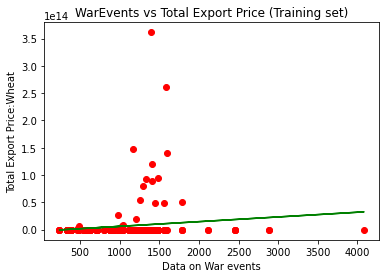

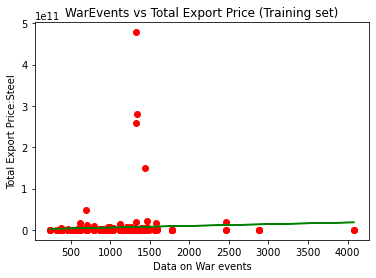

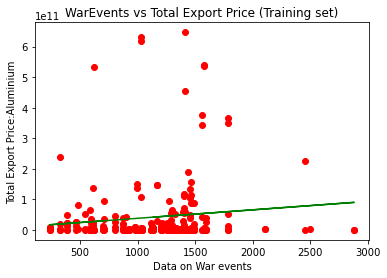

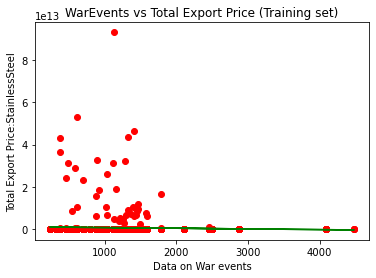

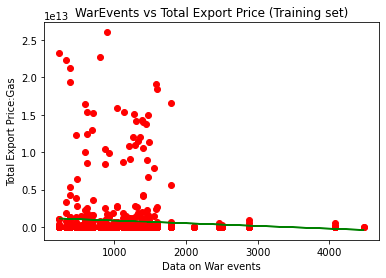

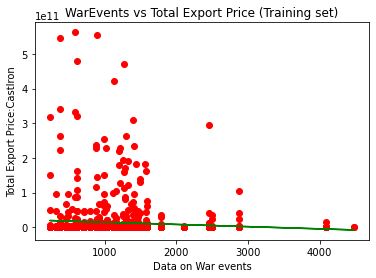

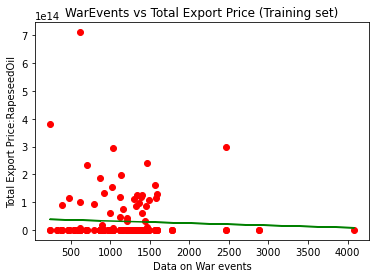

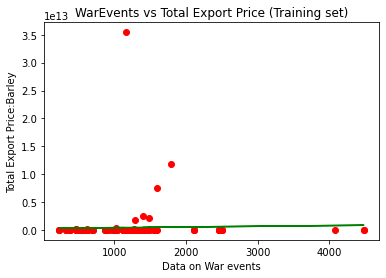

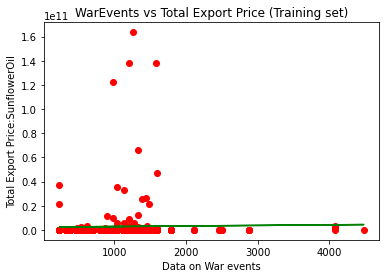

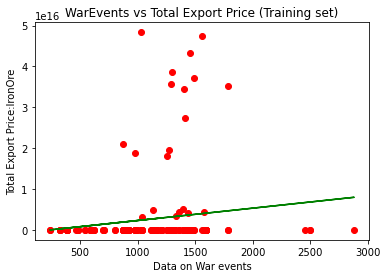

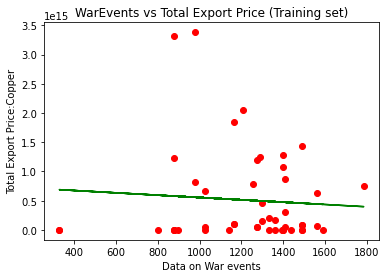

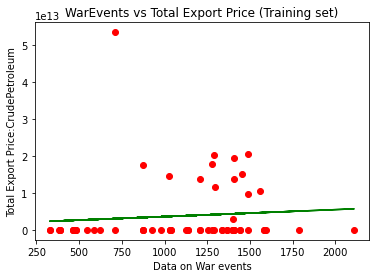

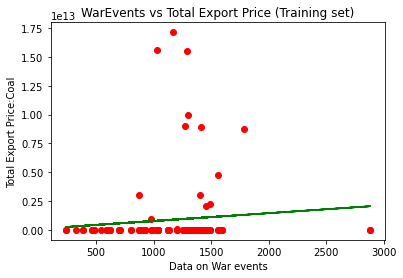

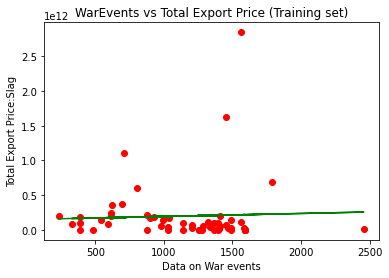

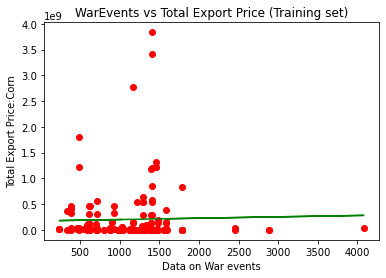

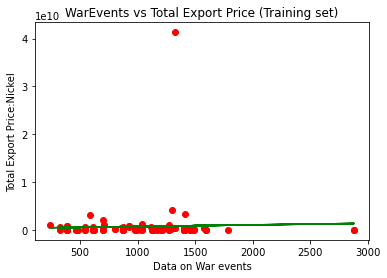

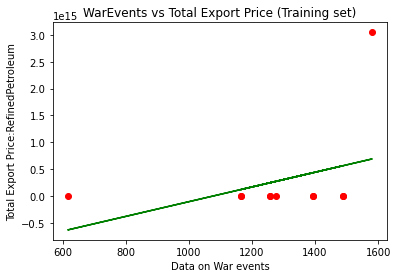

In [17]:
######################################################################################################################        
#                                              Linear Regression                                                     #
######################################################################################################################
linear_regression_model=LinearRegression()
features = ['COUNT_OF_EVENTS']
target = 'TOTAL_SOLD_USD'
for df_name in df_list:  
    # print(df_name.split("_")[1] + "_" + df_name.split("_")[3])
    if locals()[df_name].shape[0] > 1:
        
        X=locals()[df_name][features].values.reshape(-1, len(features))
        Y=locals()[df_name][target].values
        
        # X=locals()[df_name]['COUNT_OF_EVENTS'].values
        # Y=locals()[df_name]['TOTAL_SOLD_USD'].values
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2,random_state=0)
######################################################################################################################        
#                                              Linear Regression                                                     #
######################################################################################################################
        clf=linear_regression_model.fit(x_train, y_train)
        # print("x_train",x_train)
        # print("y_train",y_train)
        # print("Coefficient/Slope : ", clf.coef_)
        # print("Intercept : ", clf.intercept_)
        linear_regression_predictions = linear_regression_model.predict(x_test)
        clf.score(x_test,y_test)
        linear_regression_model_mae=mean_absolute_error(y_test, linear_regression_predictions)
        linear_regression_model_rmse=np.sqrt(metrics.mean_squared_error(y_test, linear_regression_predictions))
        linear_regression_model_score=clf.score(x_test,y_test)
        # print("\n\nMean Absolute Error:",linear_regression_model_mae)
        # print("RMSE: ",linear_regression_model_rmse)
        # print("Accuracy score of the model : ", linear_regression_model_score)
        models_comparison_matrix = models_comparison_matrix.append({
            'Regression_Commodity_Partner': df_name.split("_")[1] + "_" + df_name.split("_")[3], 
            'Predictive_Analysis_Model': linear_regression_model.__class__.__name__,
            'Accuracy_Score': linear_regression_model_score,
            'Mean_Absolute_Error' : linear_regression_model_mae,
            'Root_Mean_Squared_Error':linear_regression_model_rmse
        }, ignore_index=True)
        
        plt.scatter(x_train, y_train, color = "red")
        plt.plot(x_train, linear_regression_model.predict(x_train), color = "green")
        plt.title("WarEvents vs Total Export Price (Training set)")
        plt.xlabel("Data on War events")
        plt.ylabel("Total Export Price:" + df_name.split("_")[3])
        plt.show()

df_Ukraine_commodity_Wheat
df_Ukraine_commodity_Steel
df_Ukraine_commodity_Aluminium
df_Ukraine_commodity_StainlessSteel
df_Ukraine_commodity_Gas
df_Ukraine_commodity_CastIron
df_Ukraine_commodity_RapeseedOil
df_Ukraine_commodity_Barley
df_Ukraine_commodity_SunflowerOil
df_Ukraine_commodity_IronOre
df_Ukraine_commodity_Copper
df_Ukraine_commodity_CrudePetroleum
df_Ukraine_commodity_Coal
df_Ukraine_commodity_Slag
df_Ukraine_commodity_Corn
df_Ukraine_commodity_Nickel
df_RussianFederation_commodity_Wheat
df_RussianFederation_commodity_Steel
df_RussianFederation_commodity_Aluminium
df_RussianFederation_commodity_StainlessSteel
df_RussianFederation_commodity_Gas
df_RussianFederation_commodity_CastIron
df_RussianFederation_commodity_RapeseedOil
df_RussianFederation_commodity_Barley
df_RussianFederation_commodity_SunflowerOil
df_RussianFederation_commodity_IronOre
df_RussianFederation_commodity_Copper
df_RussianFederation_commodity_CrudePetroleum
df_RussianFederation_commodity_Coal
df_Russian

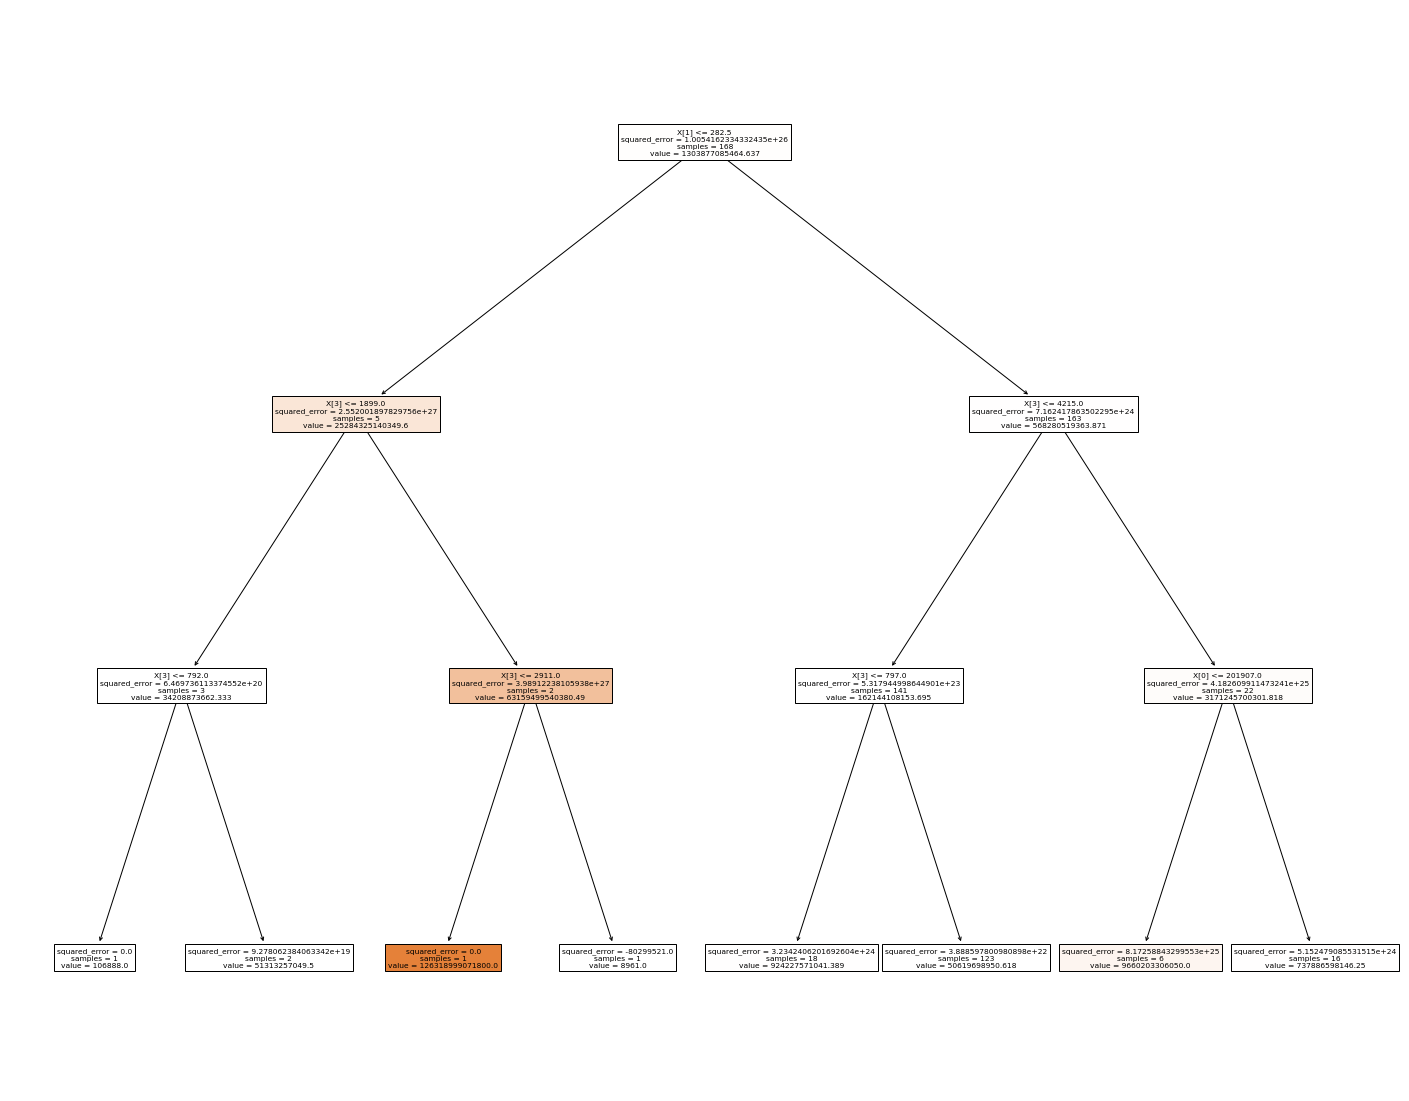

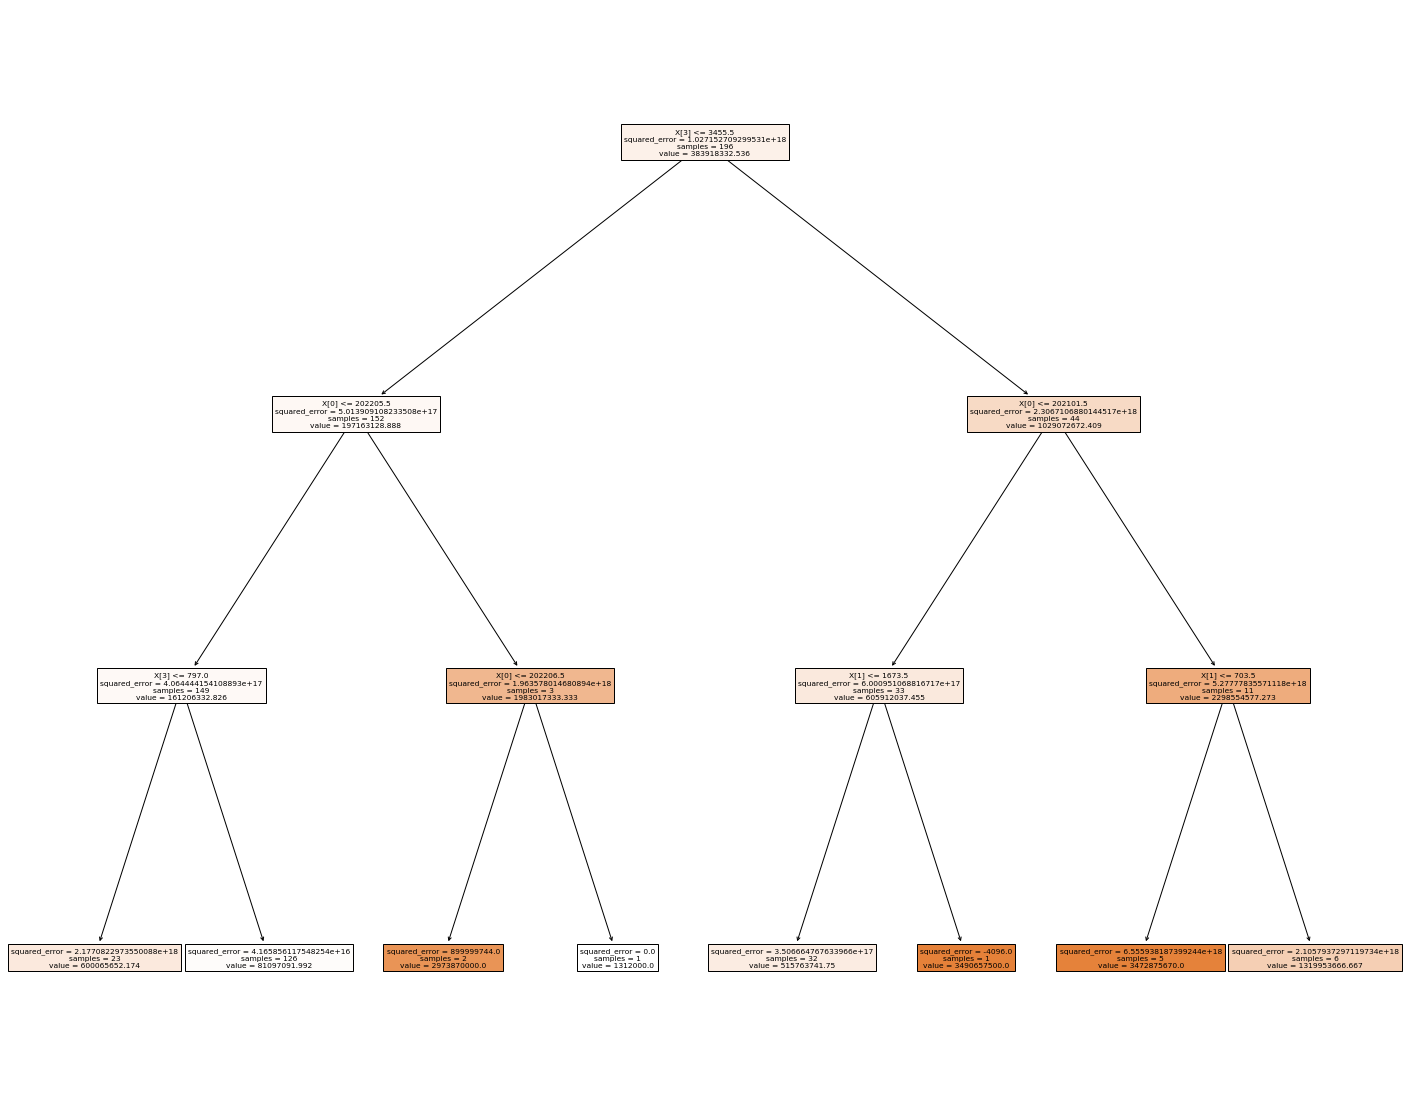

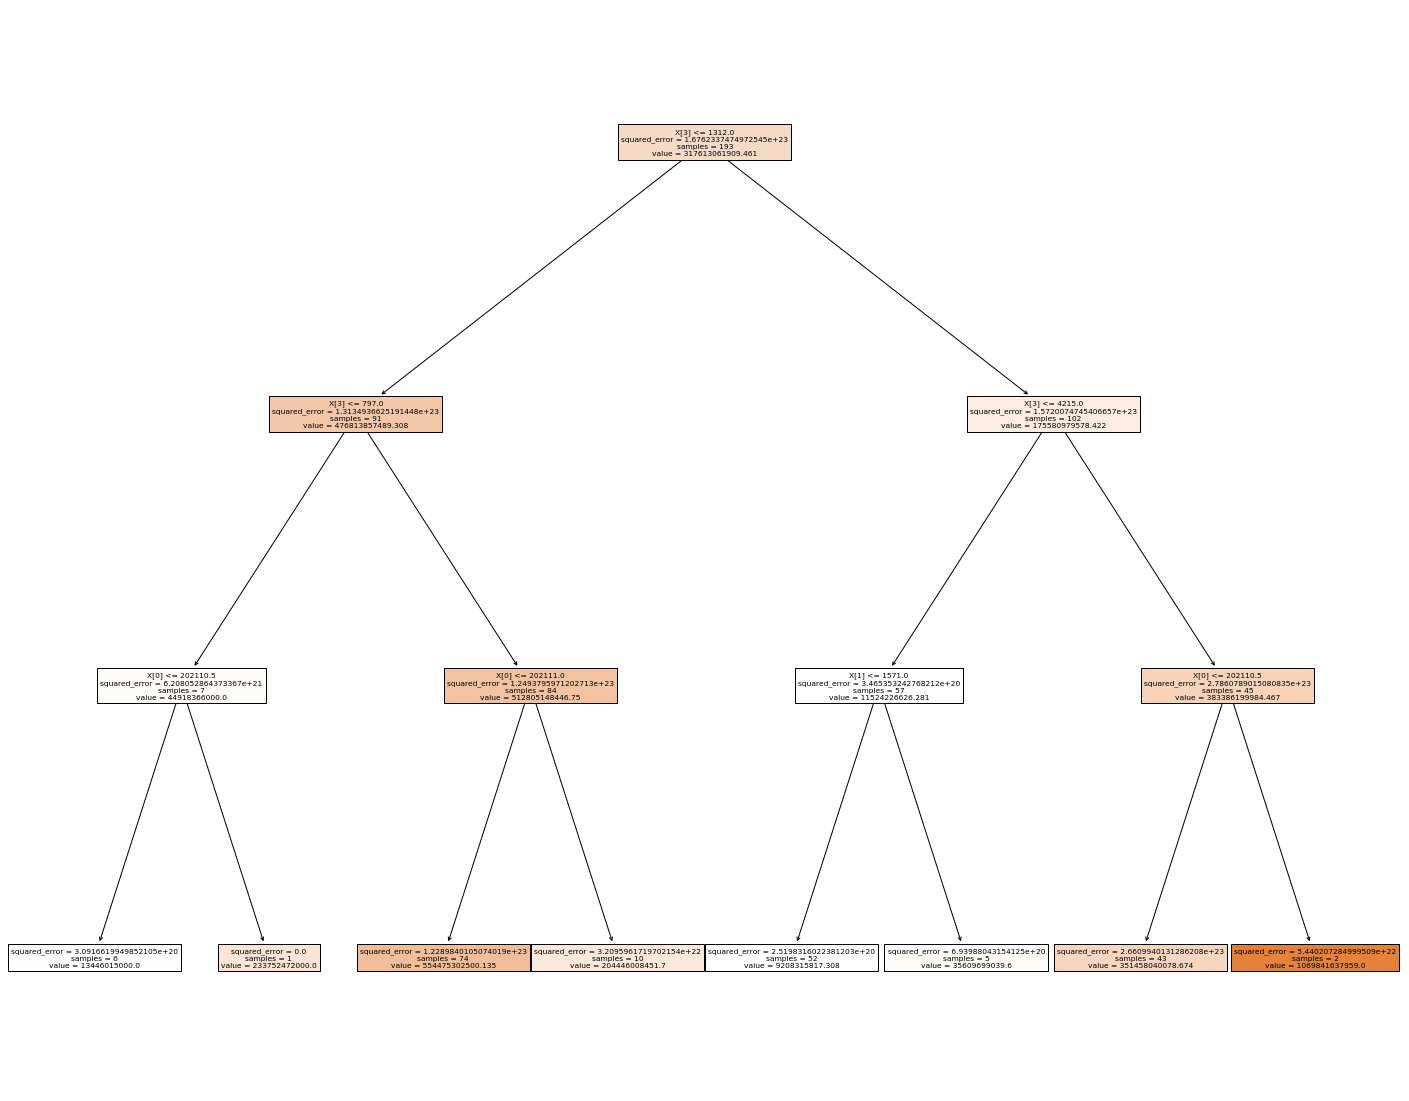

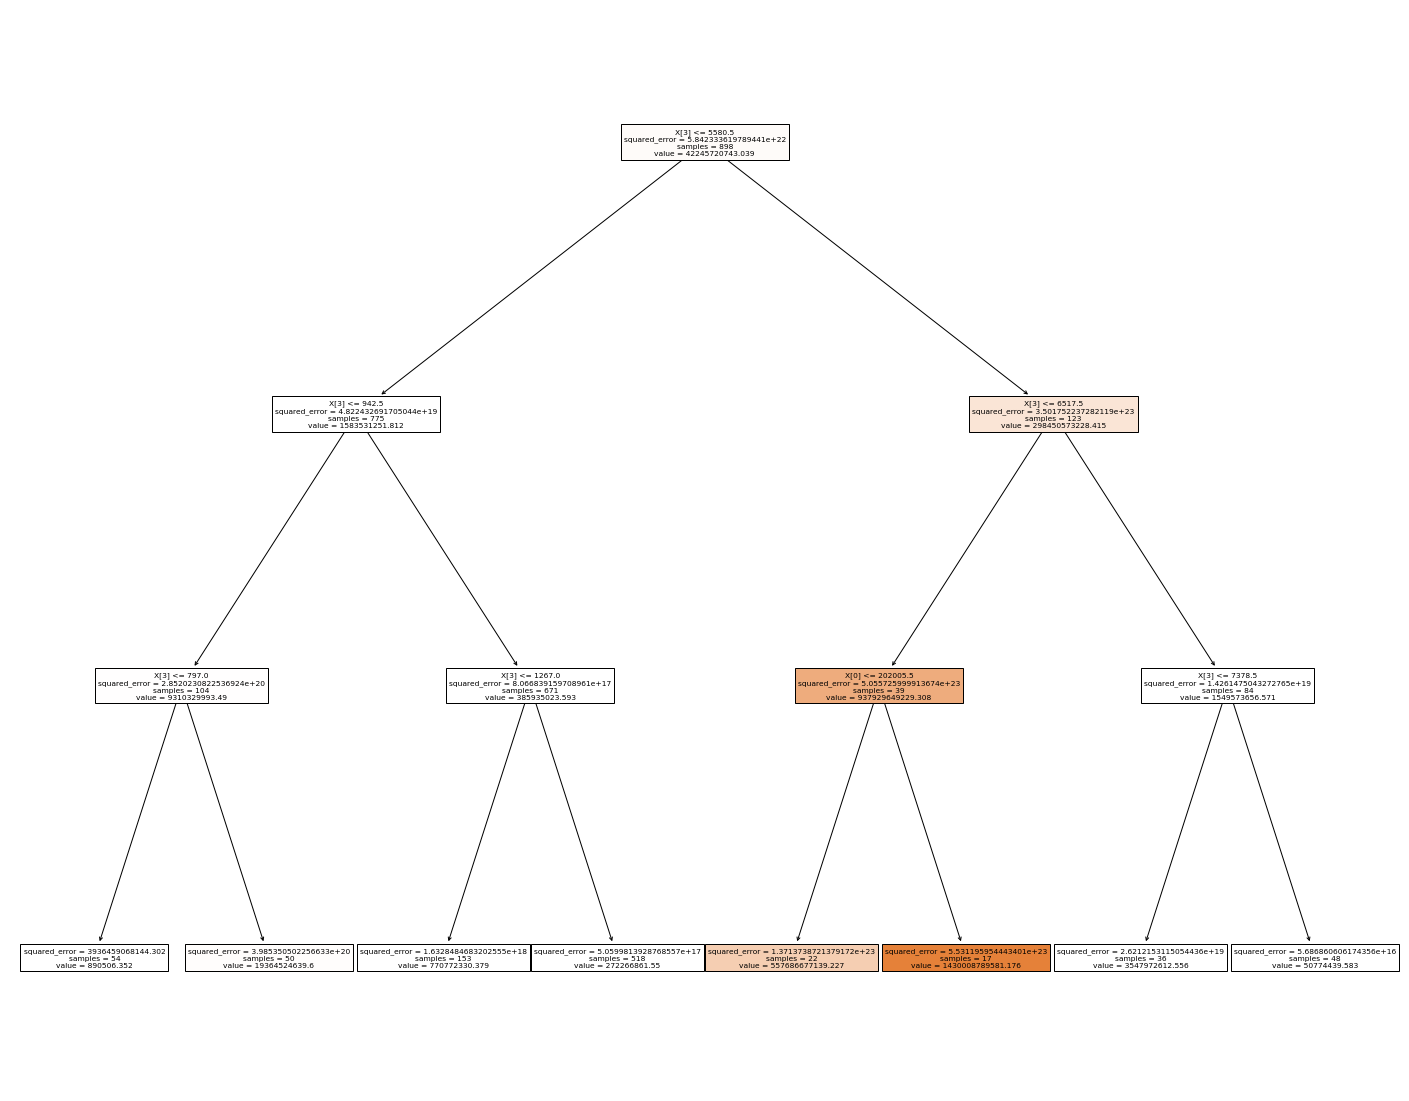

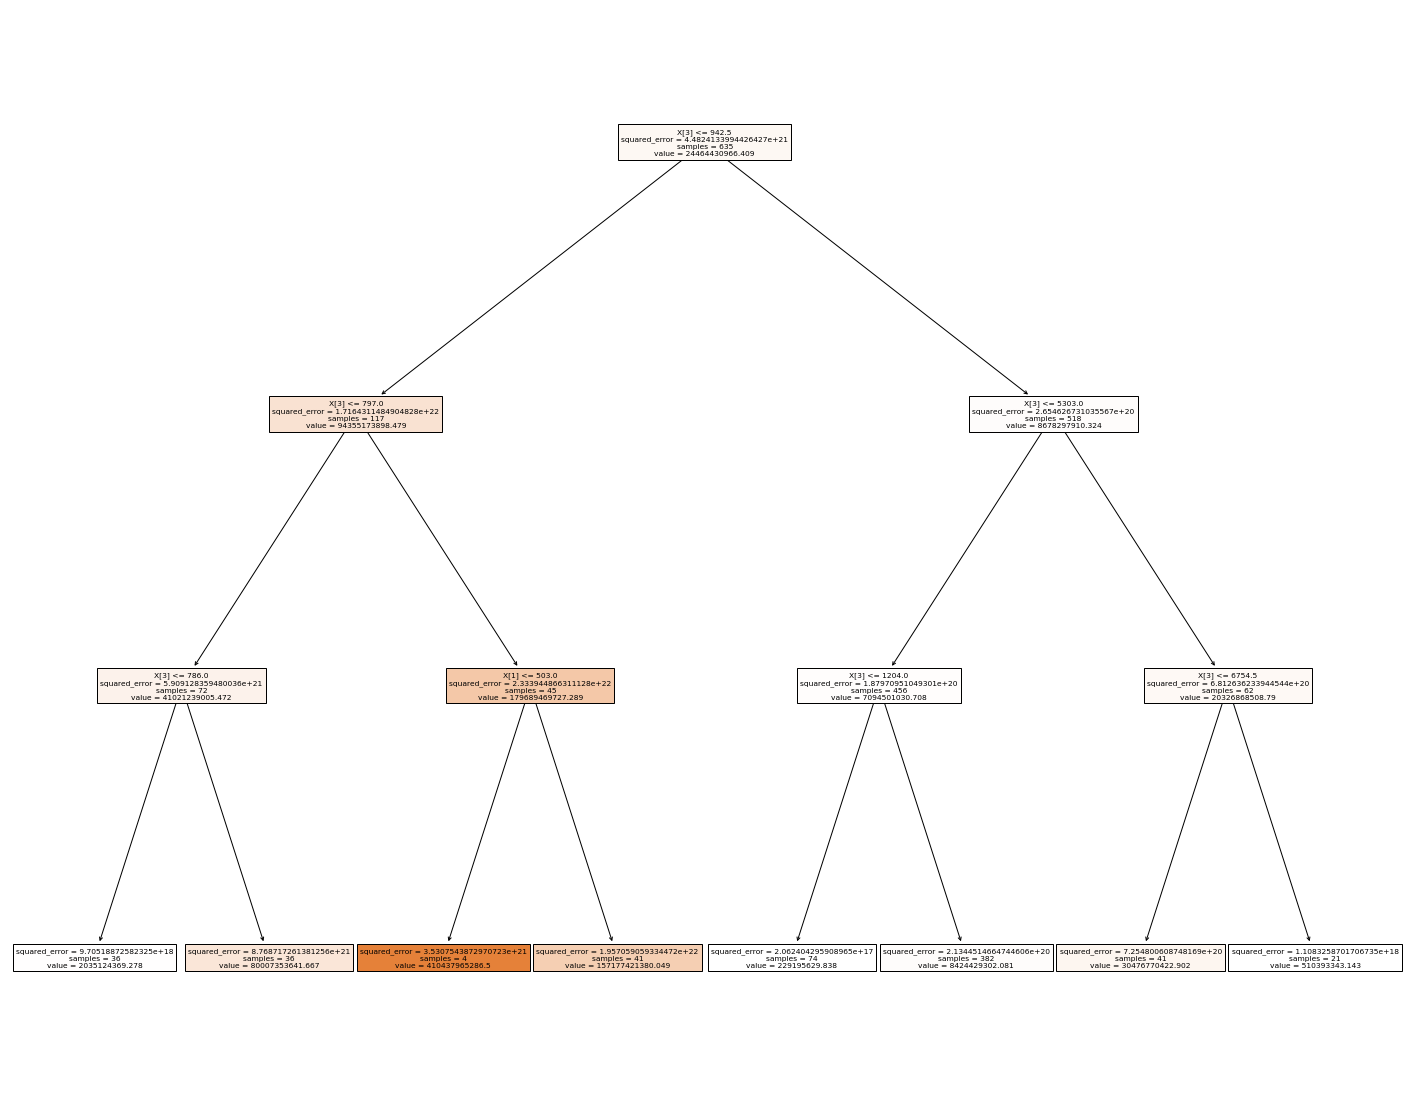

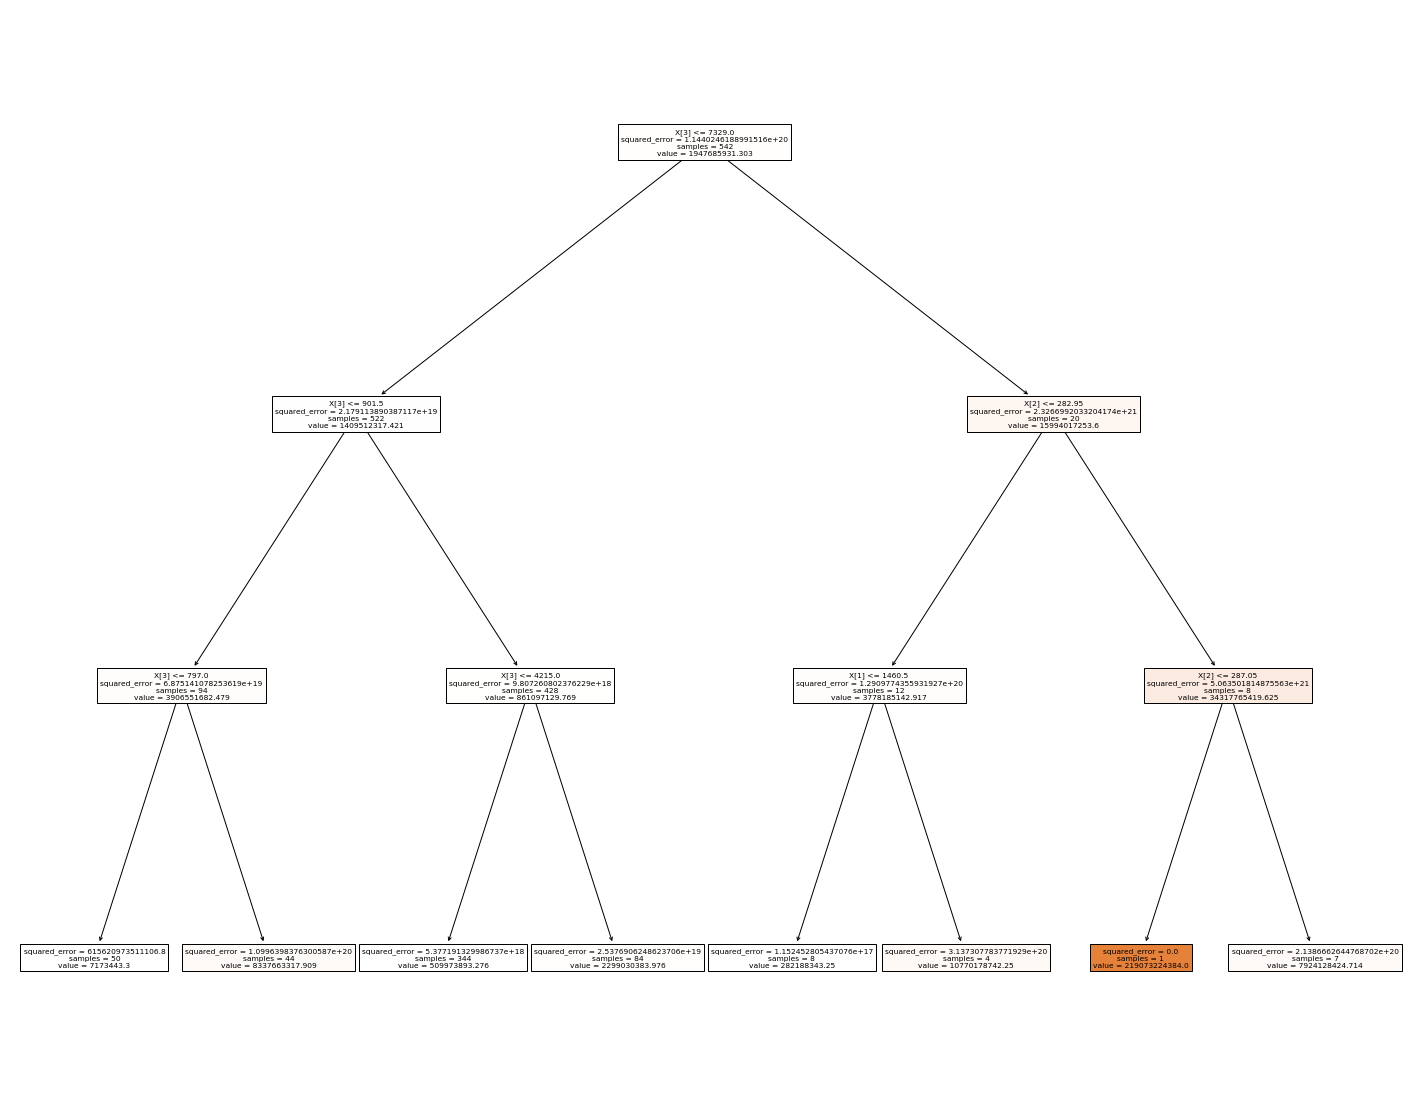

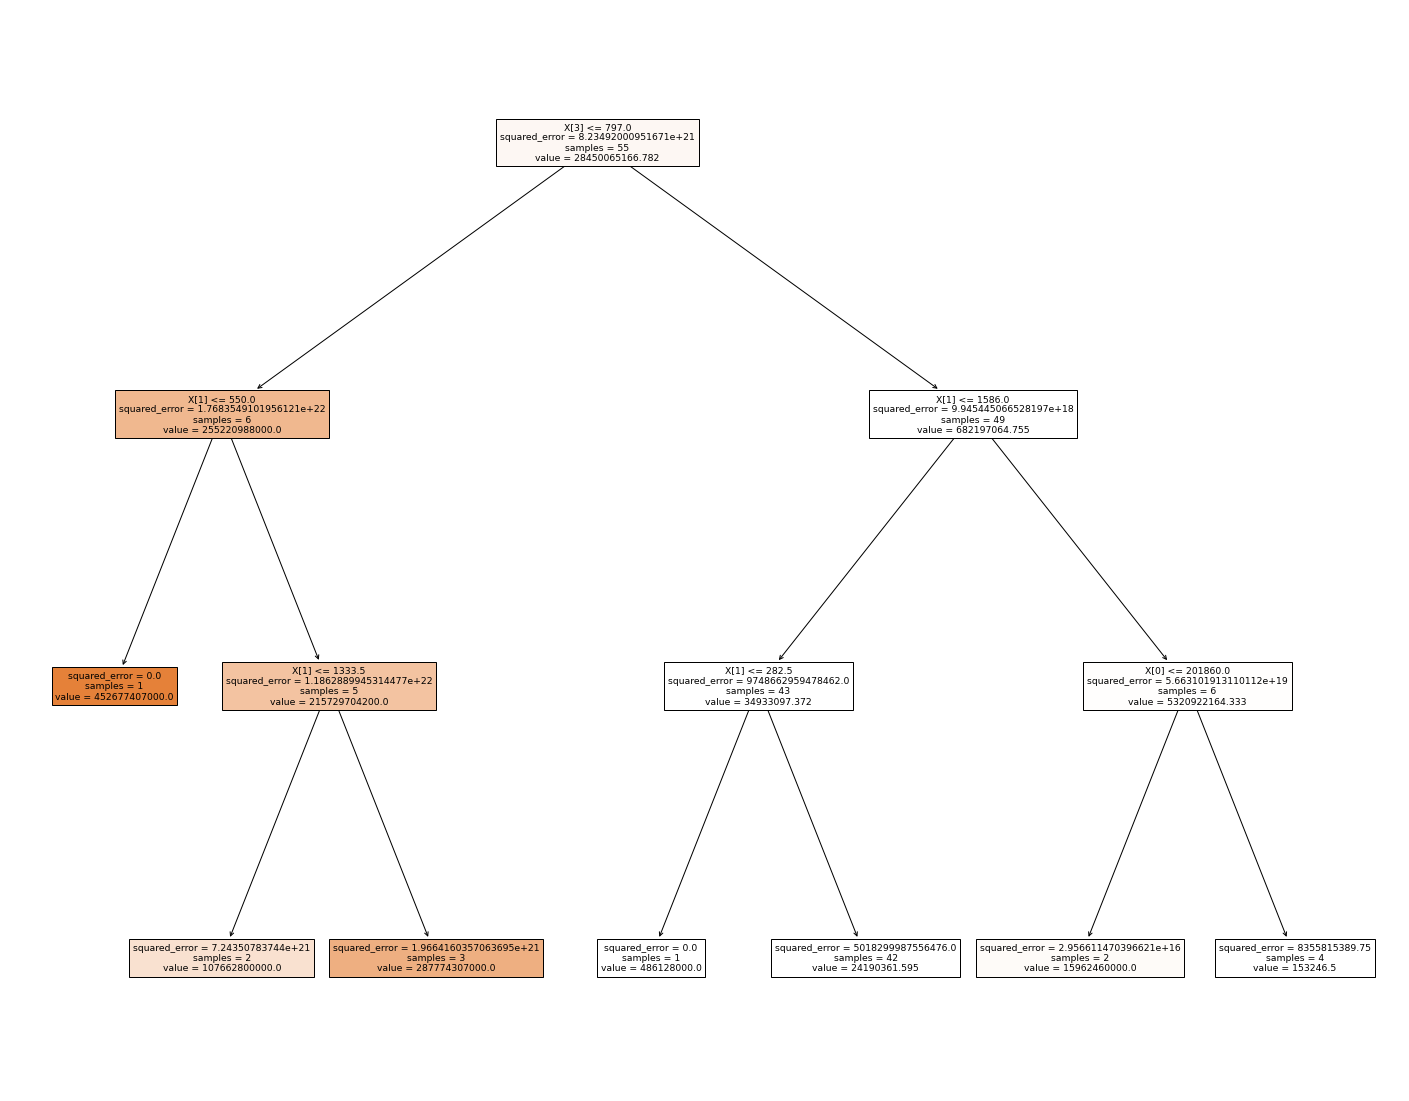

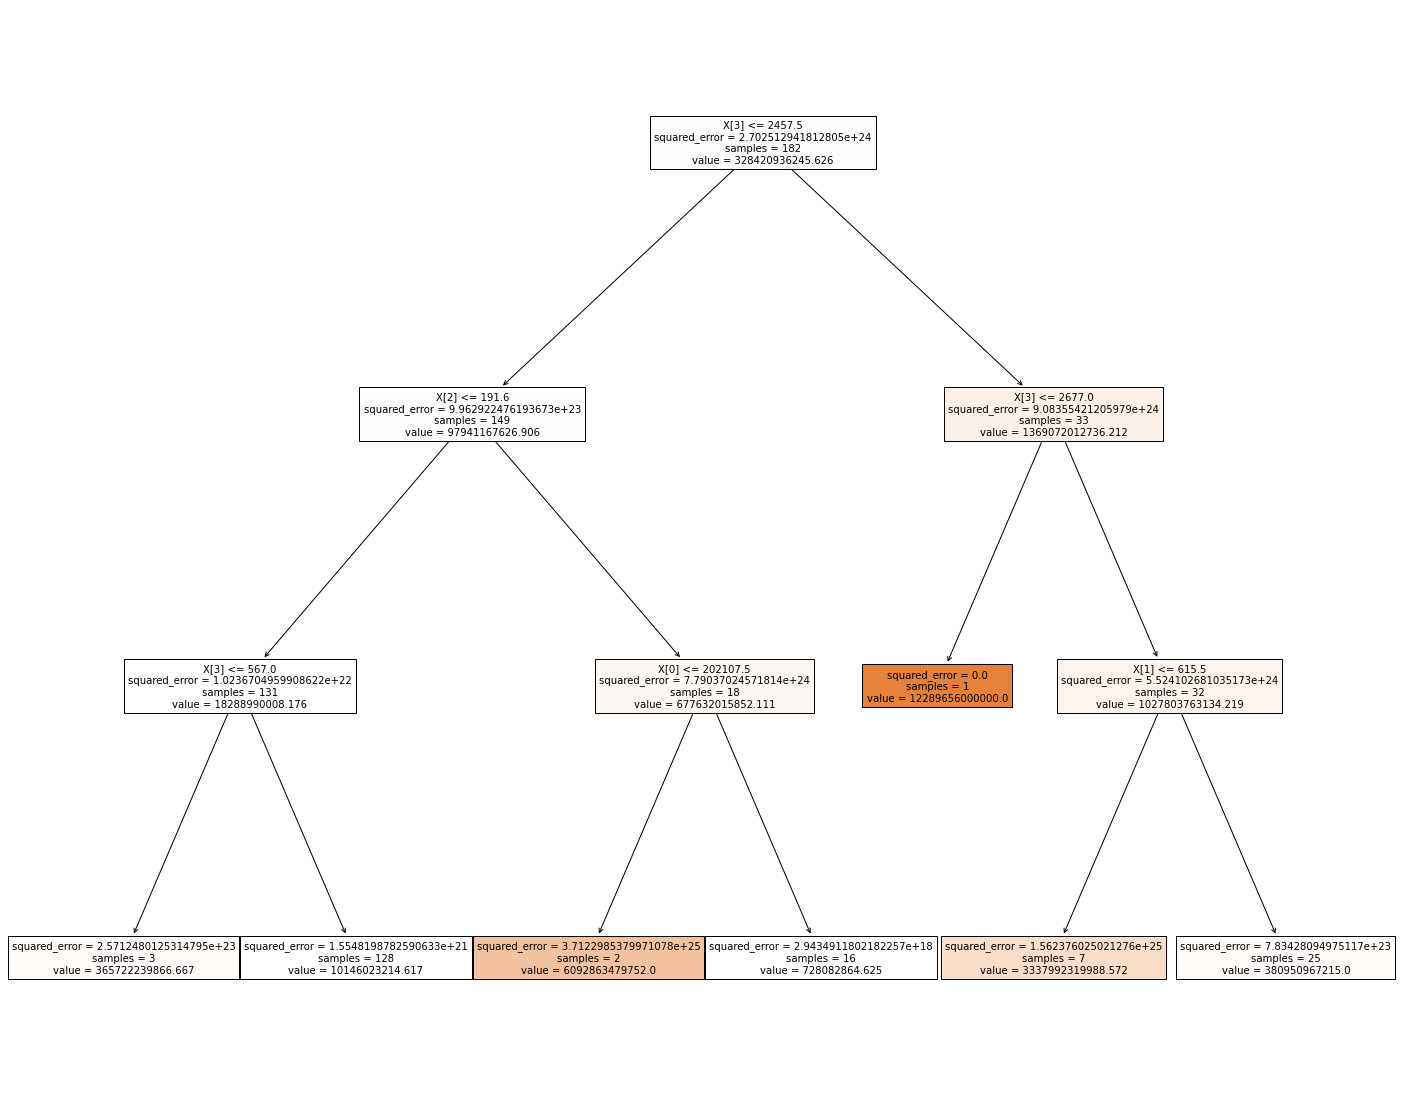

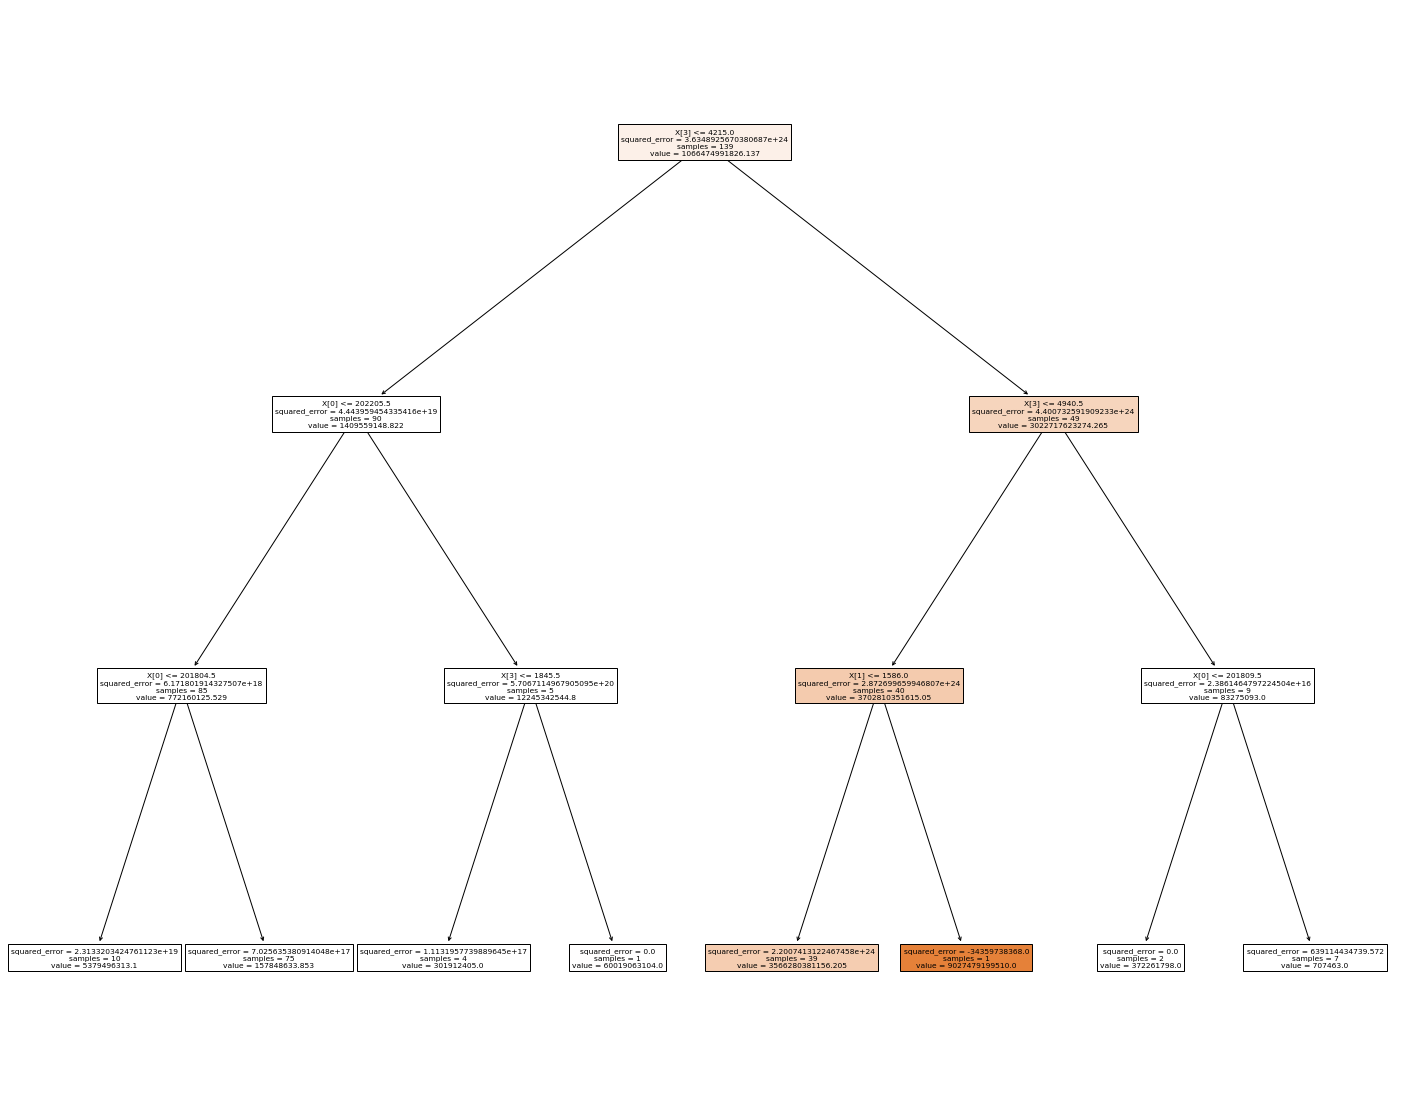

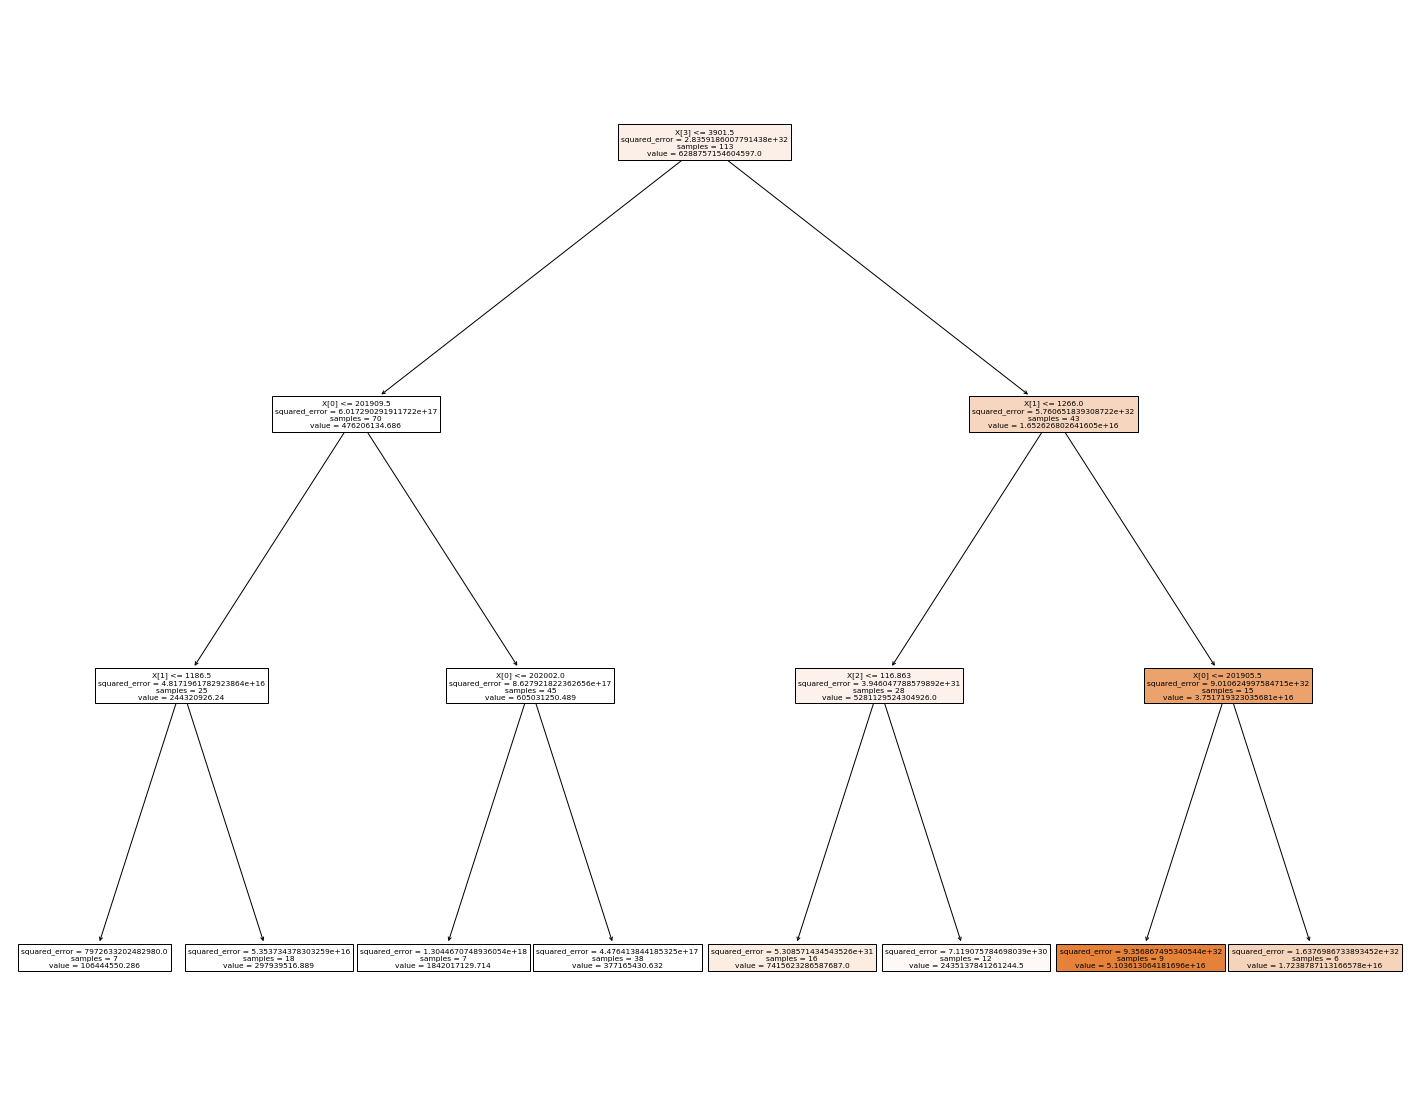

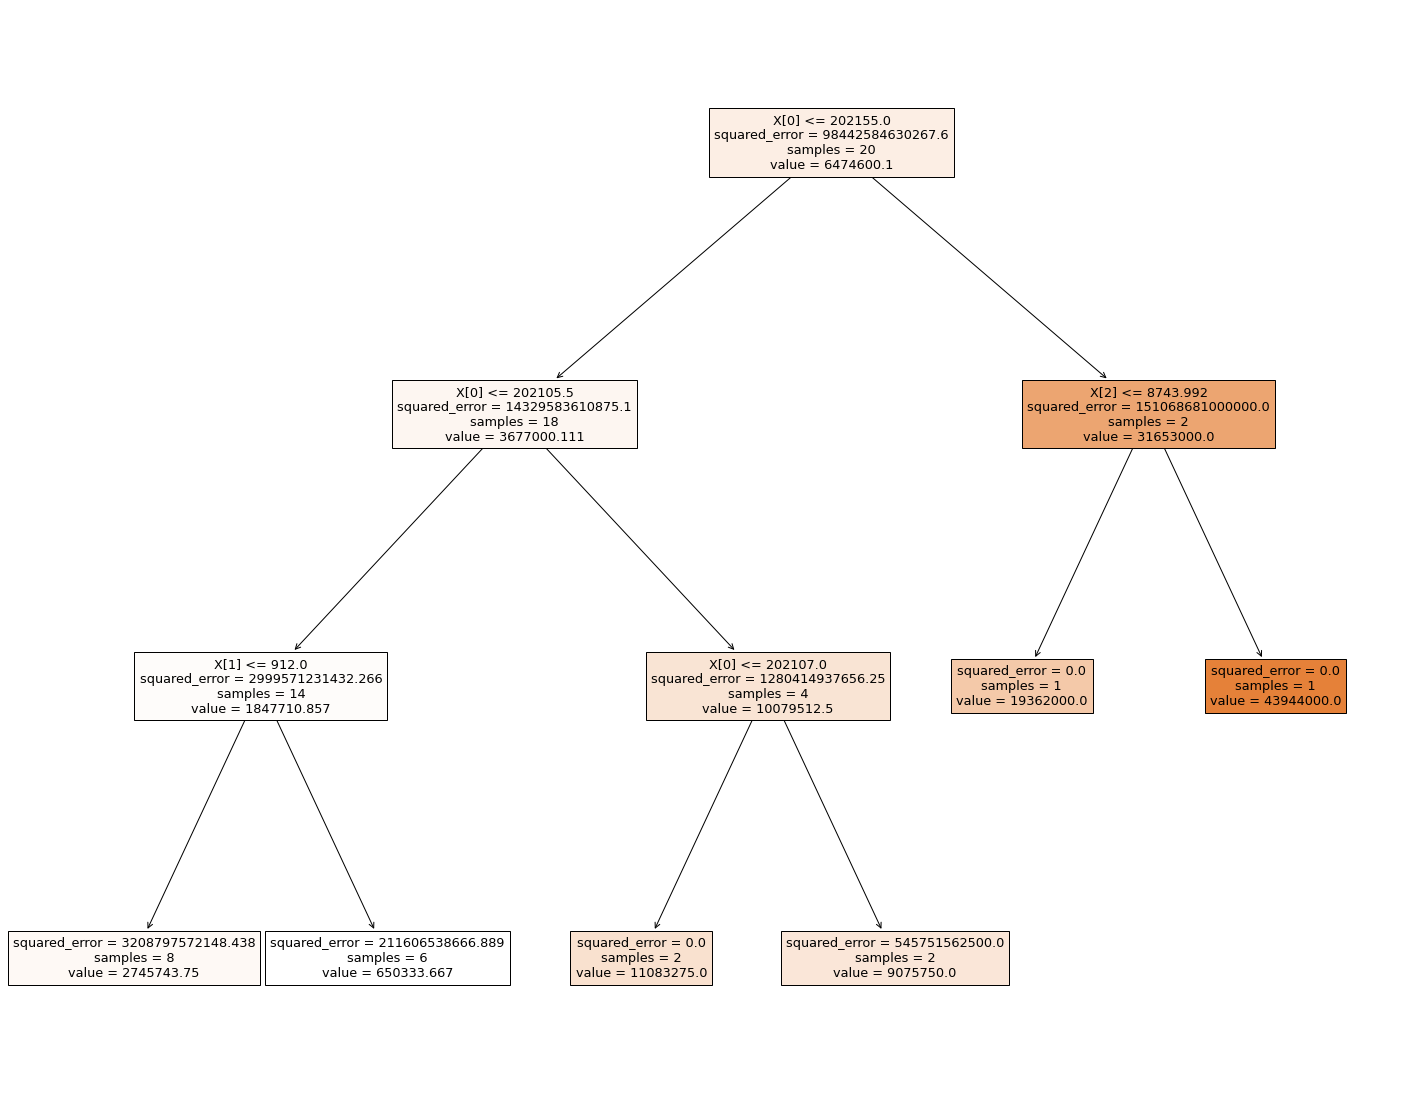

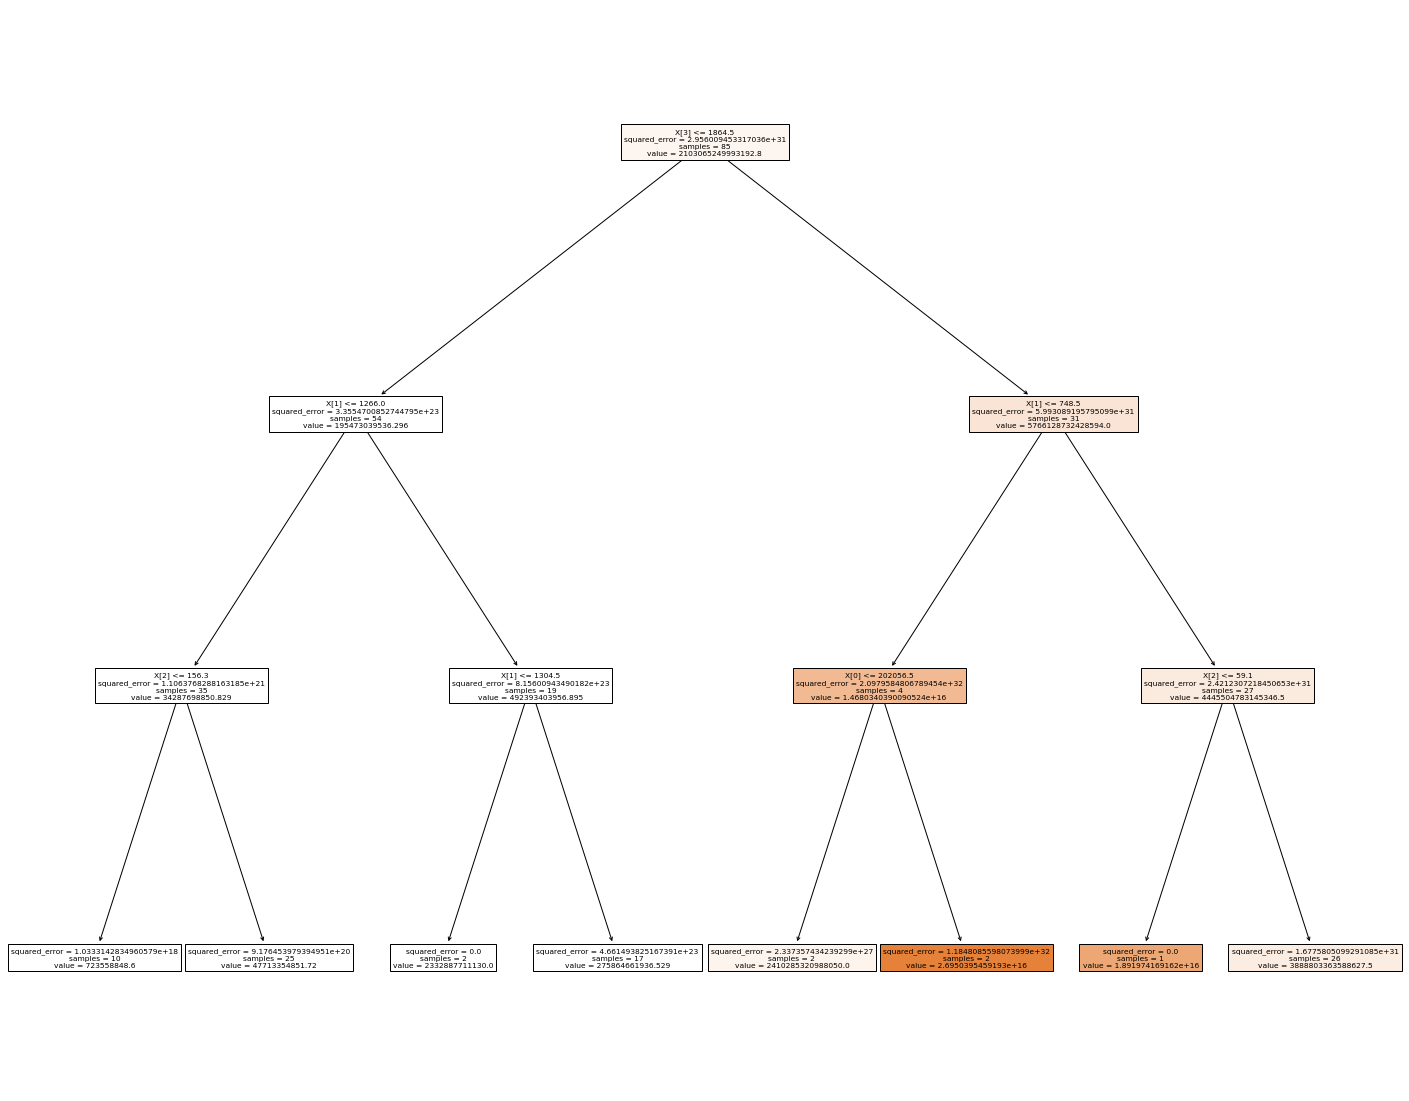

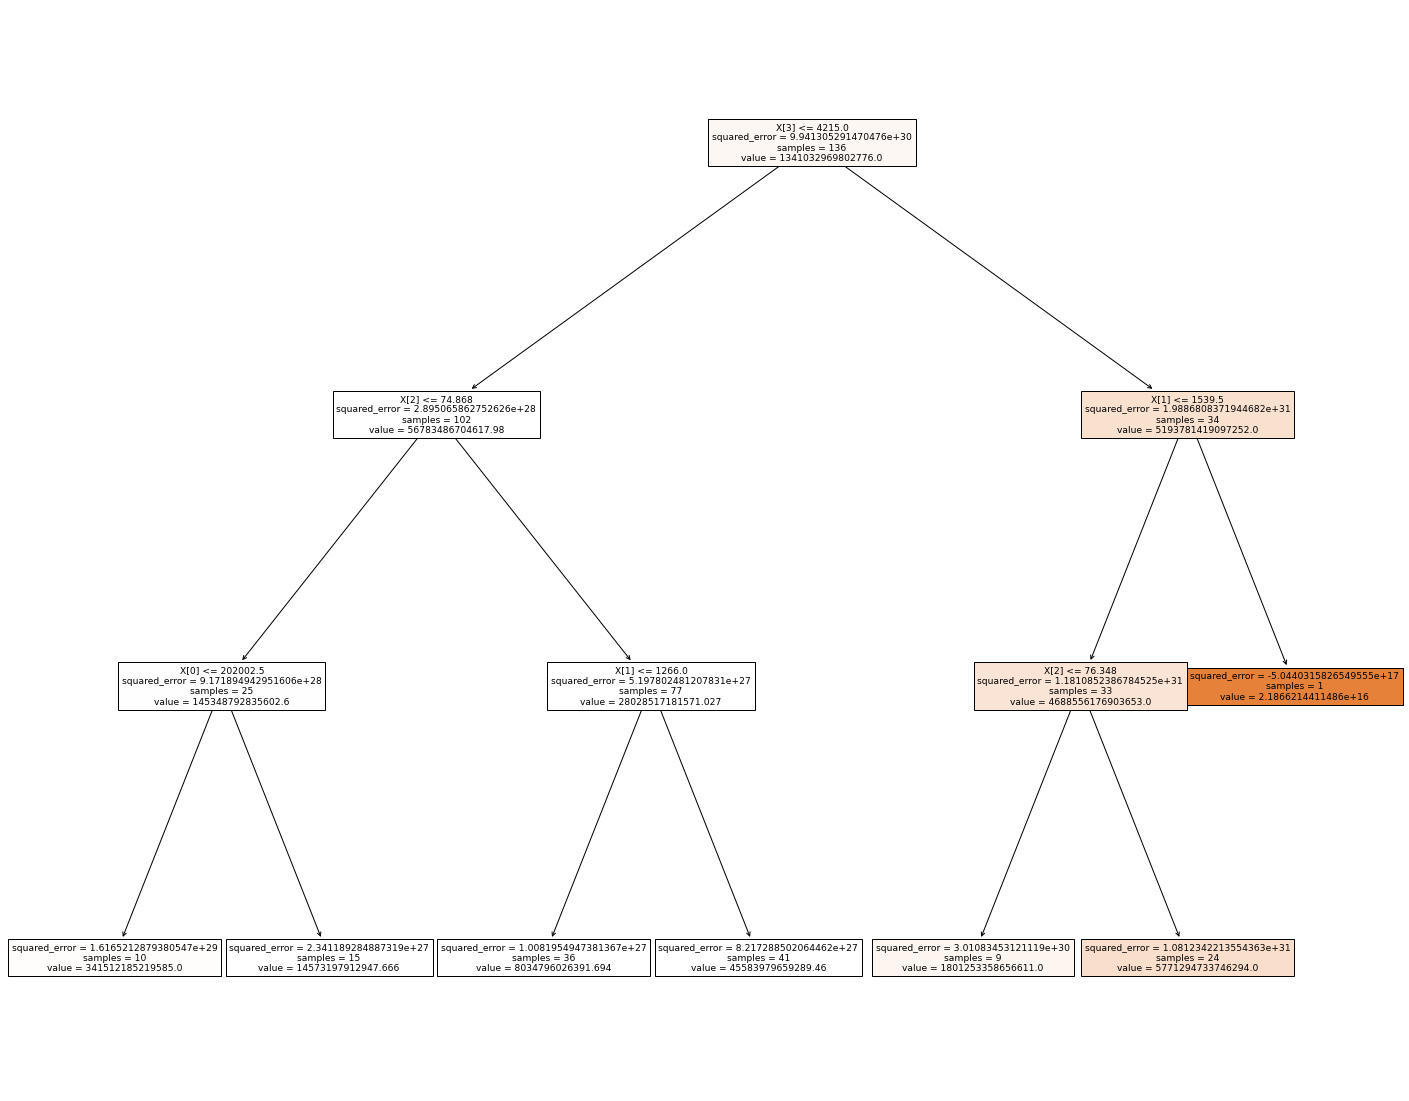

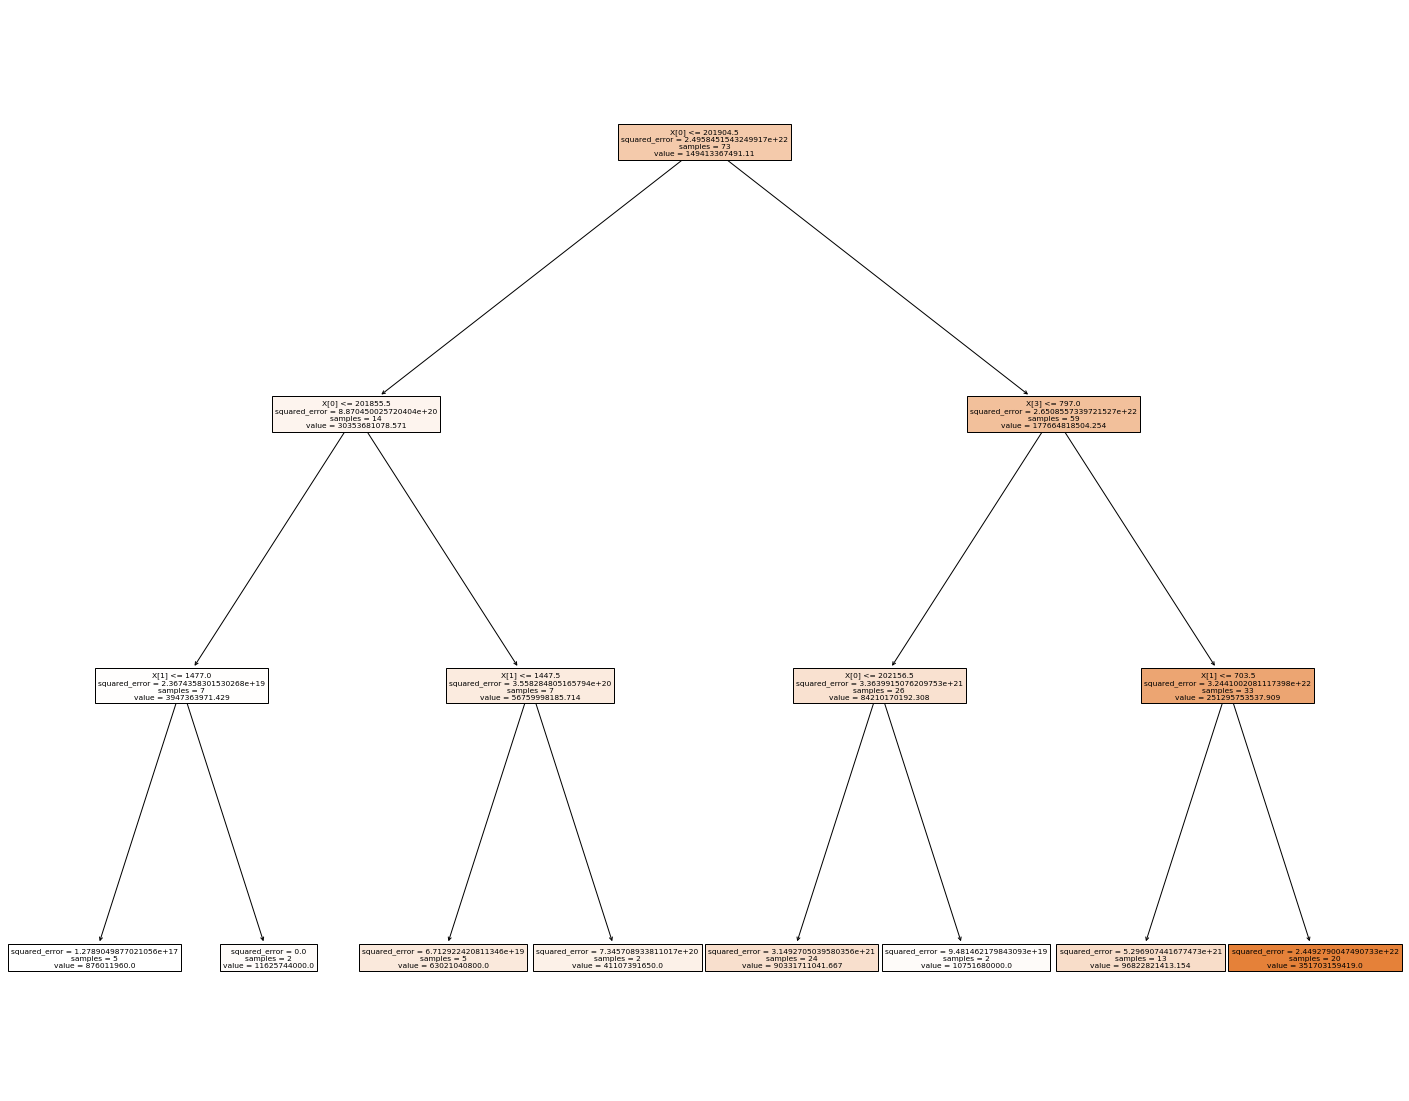

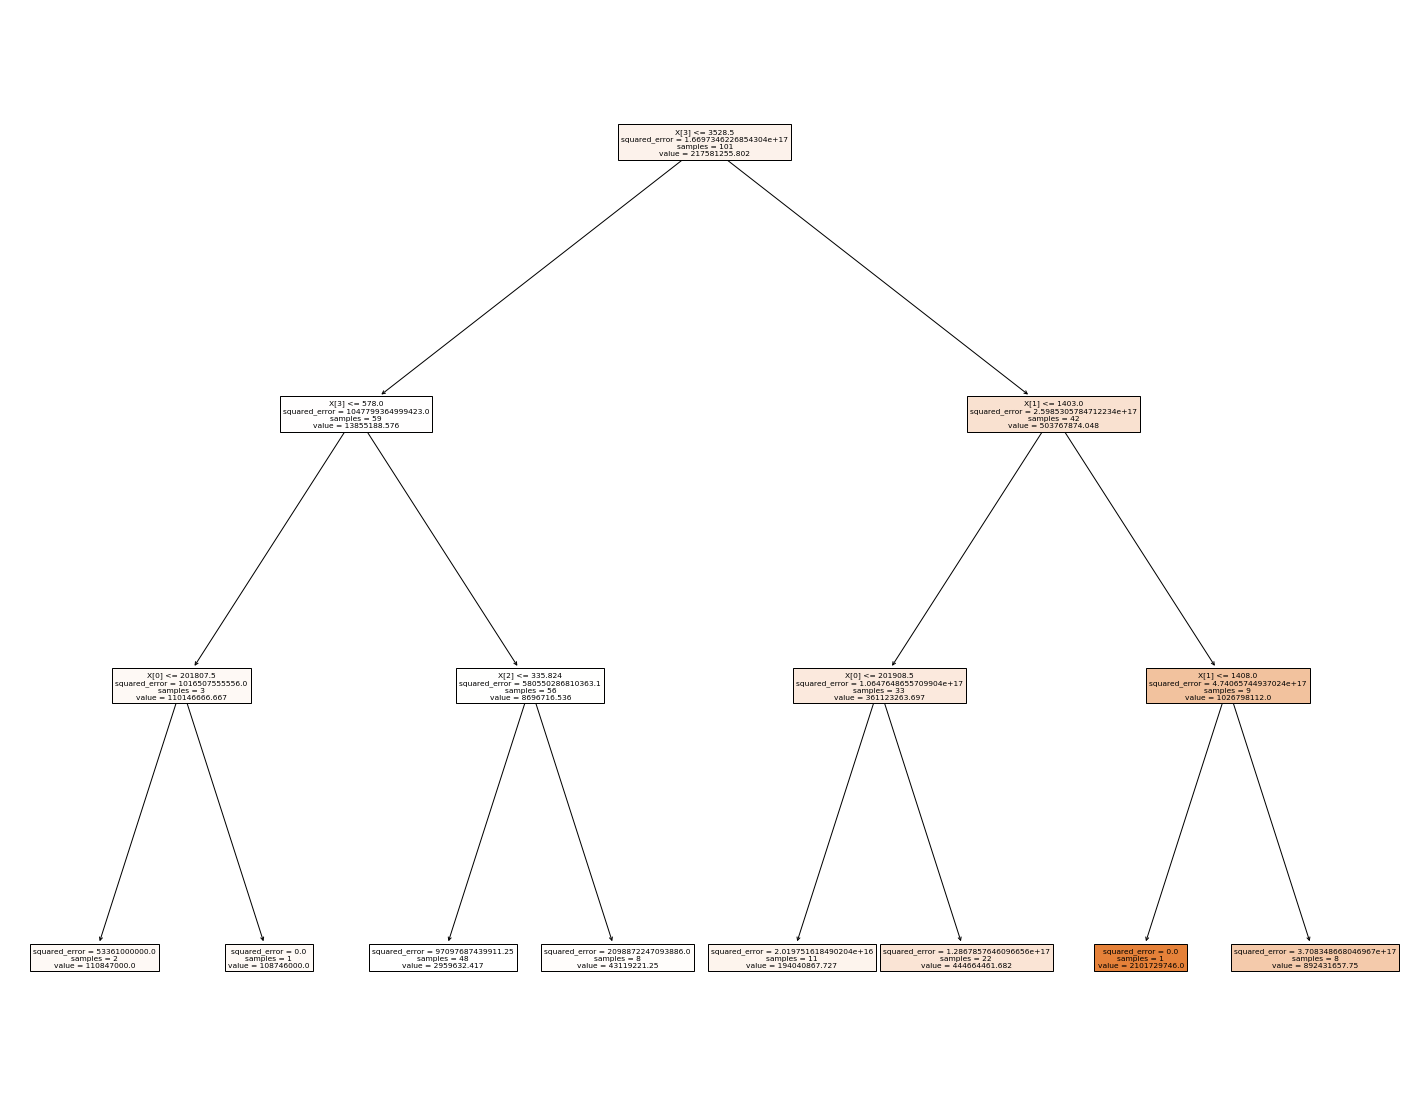

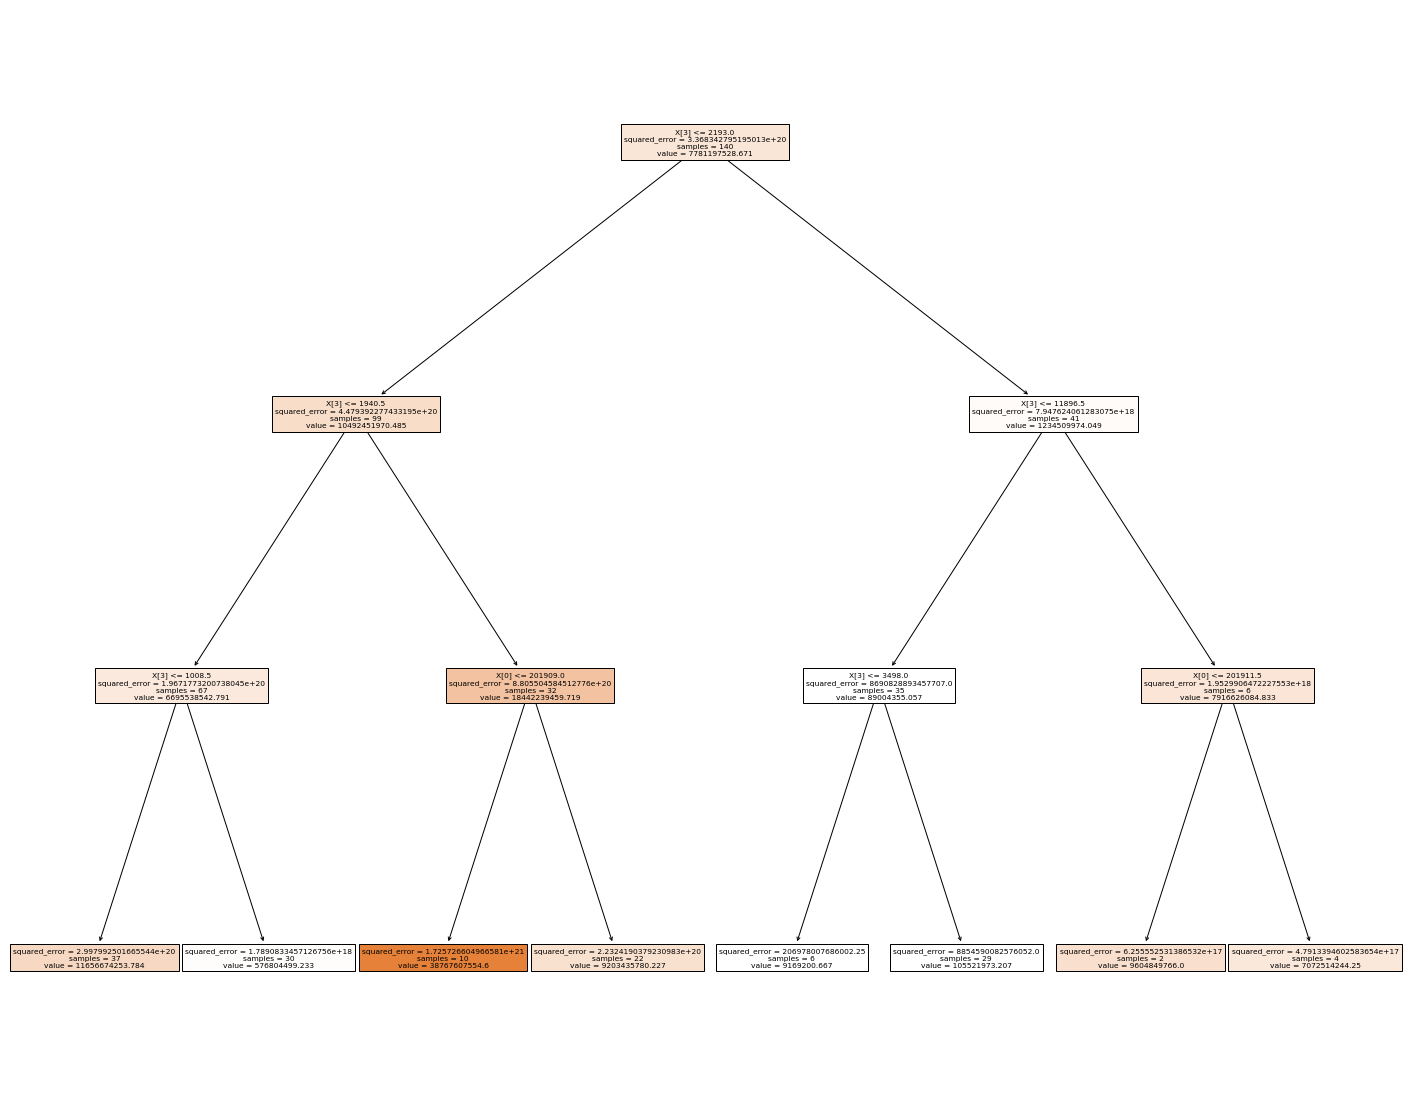

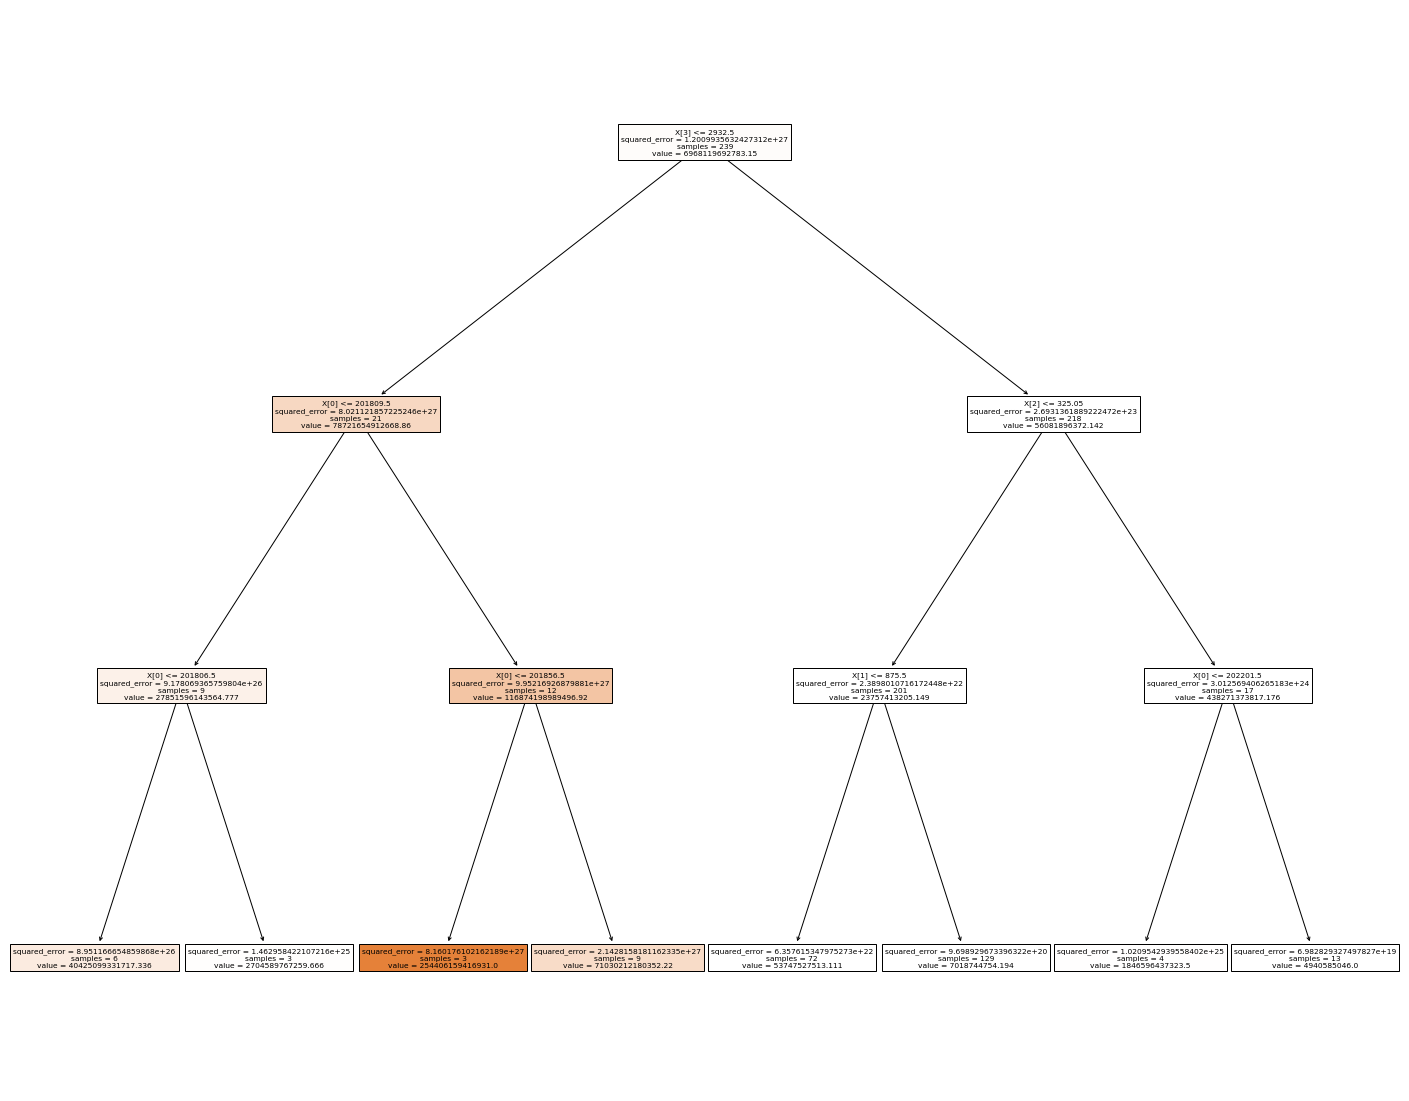

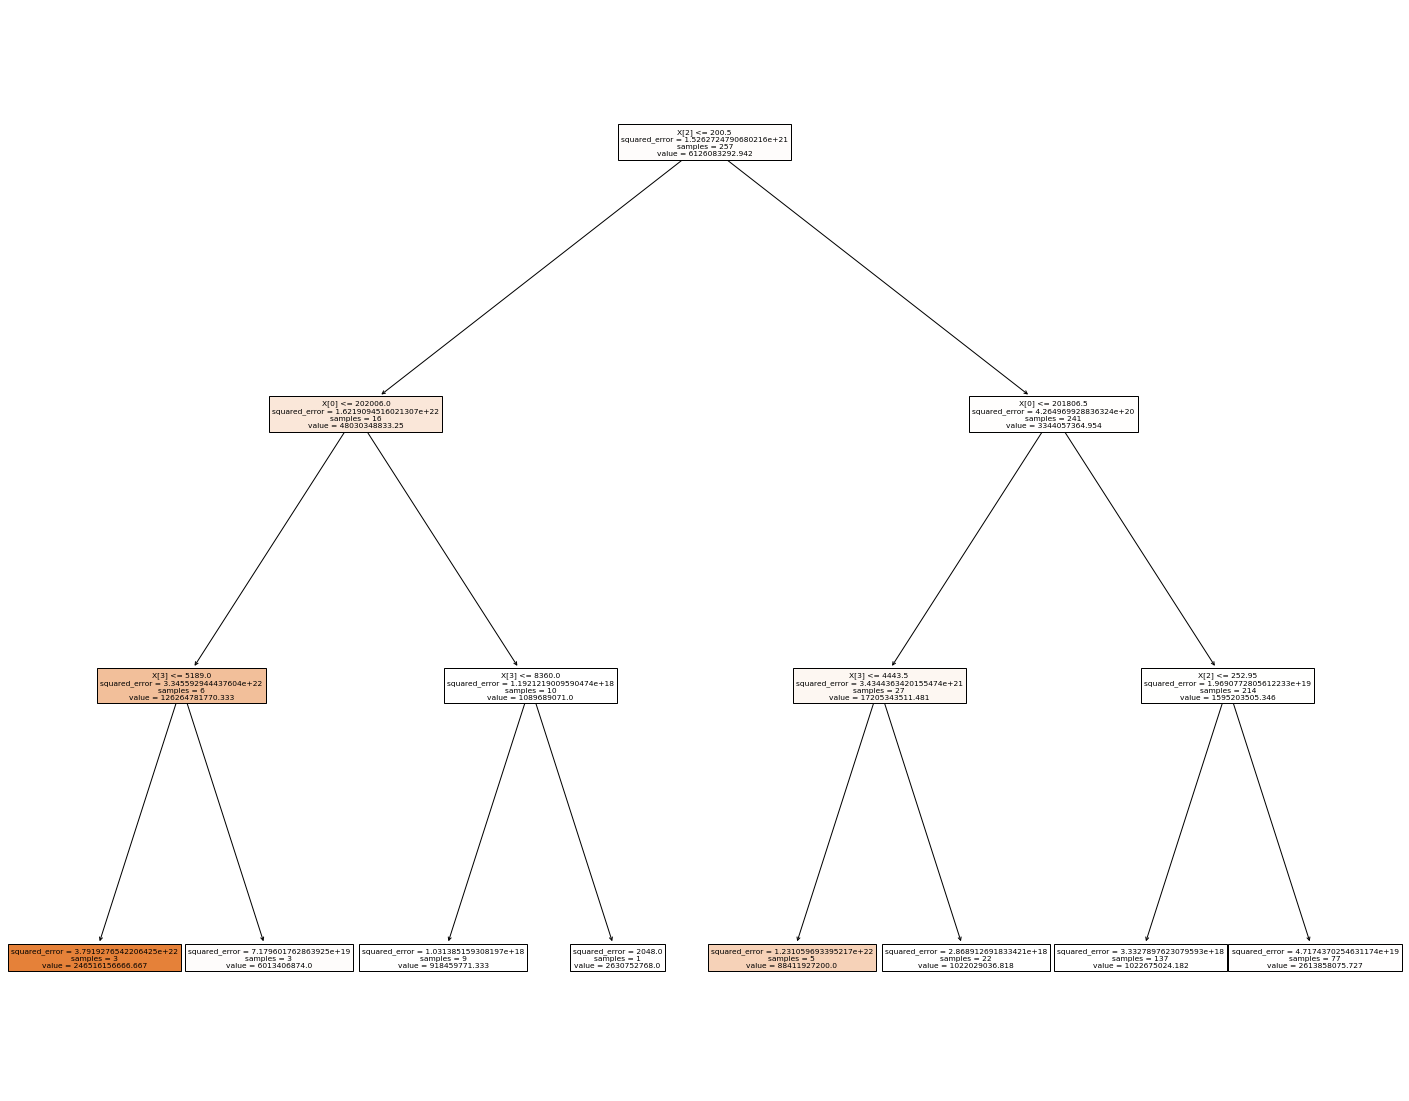

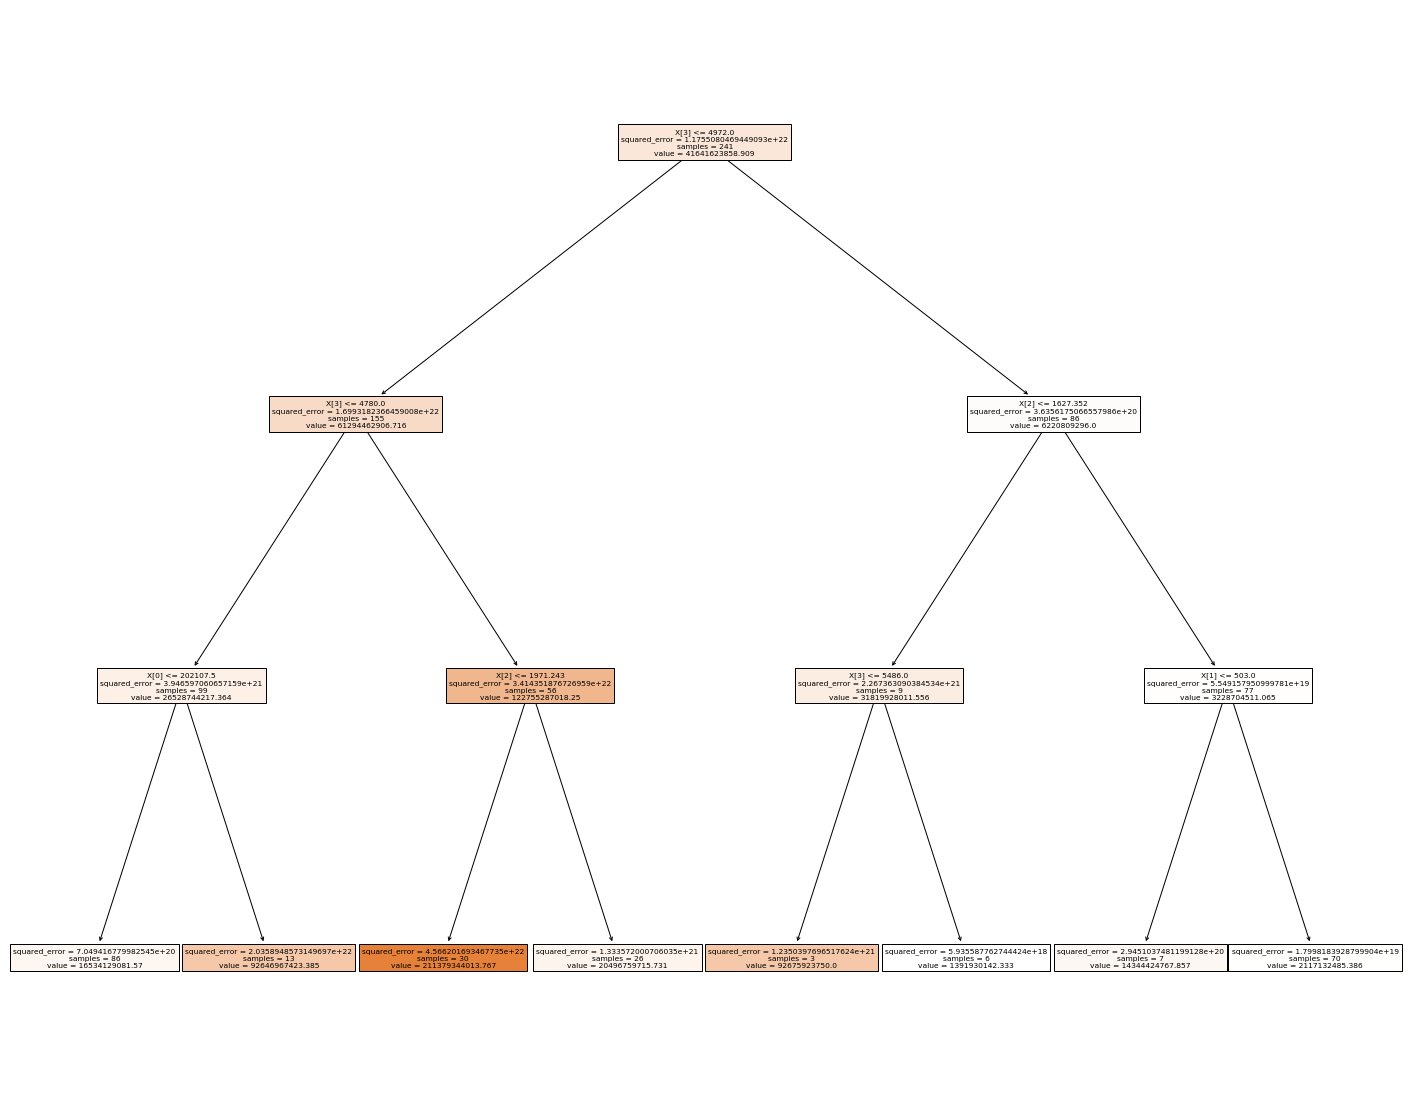

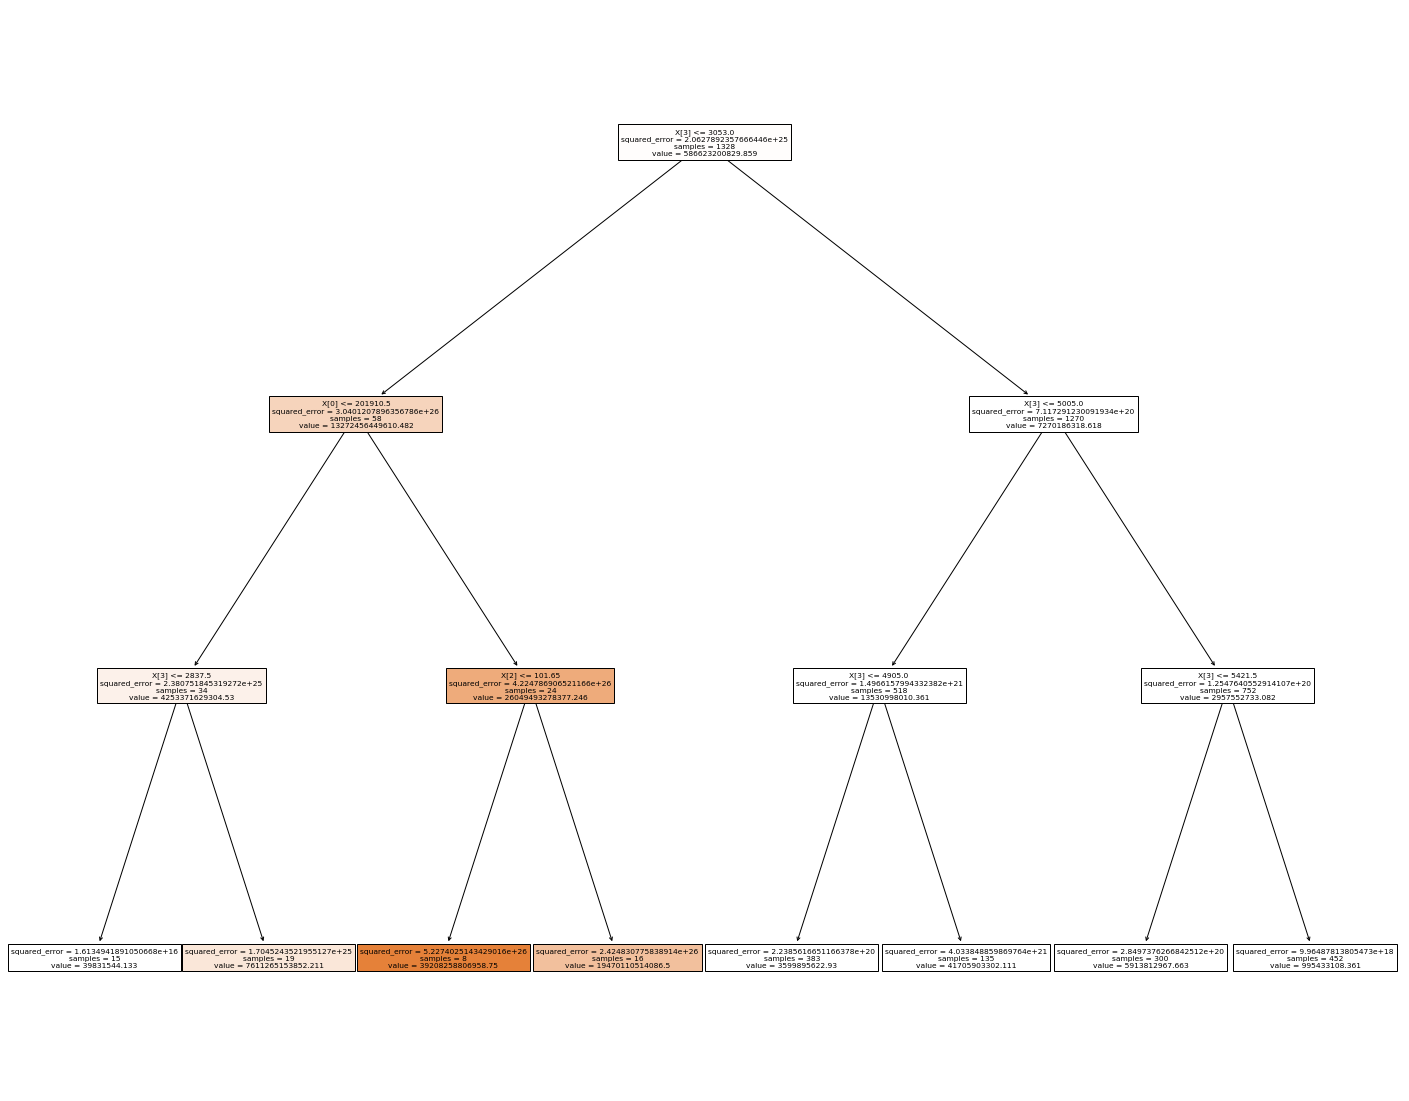

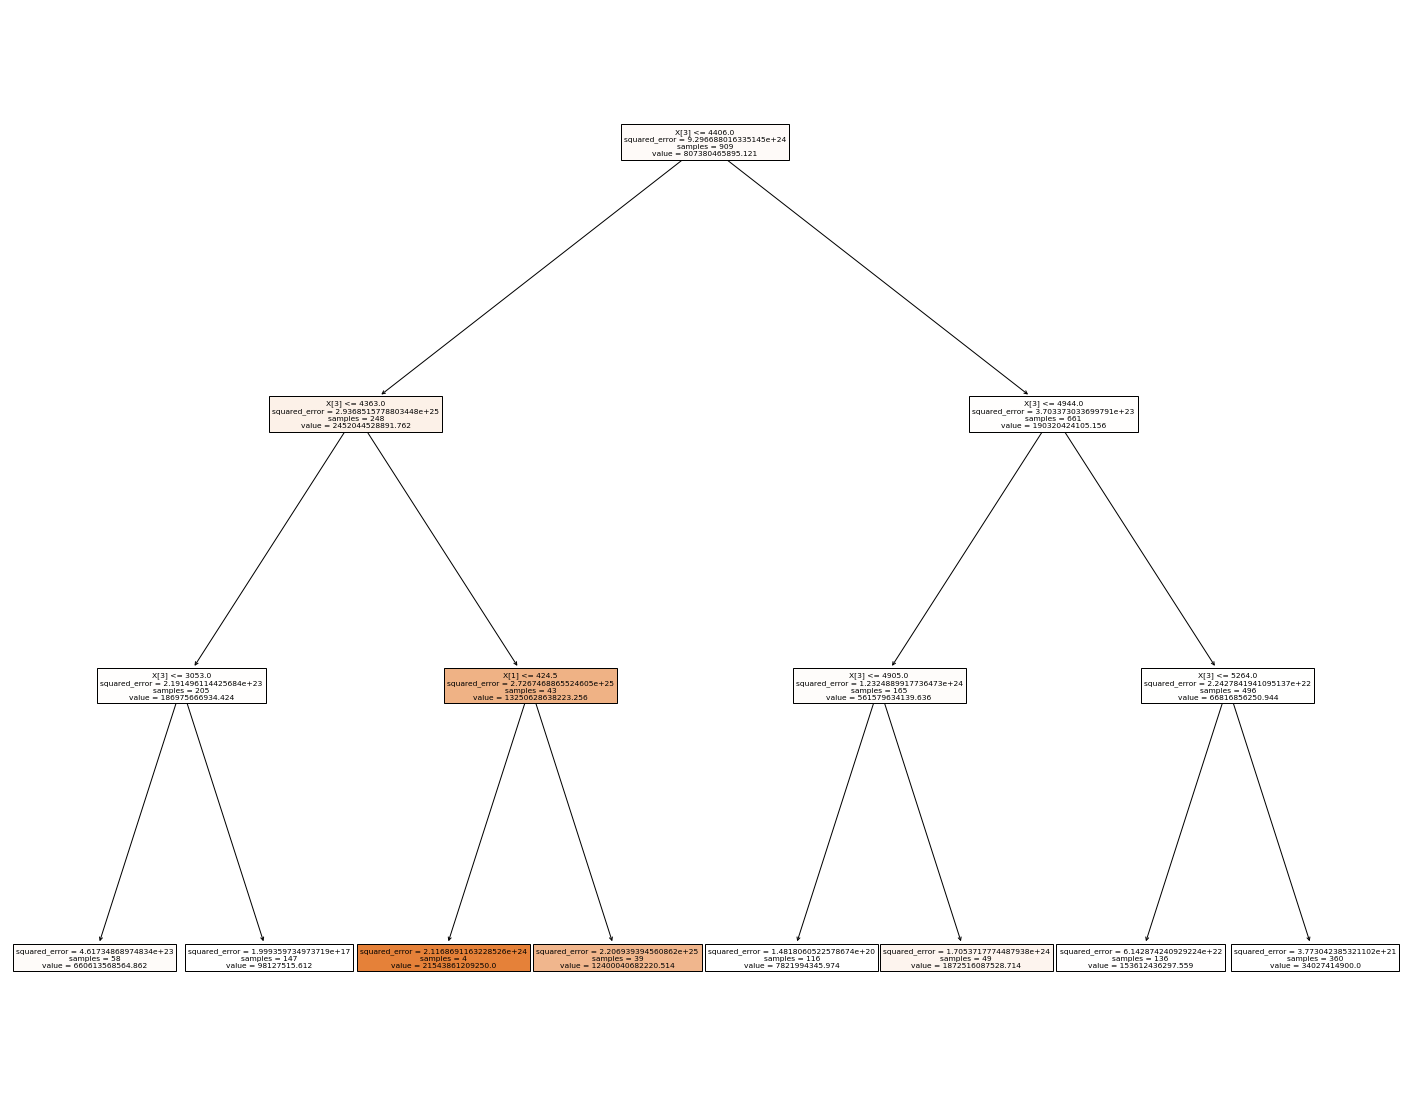

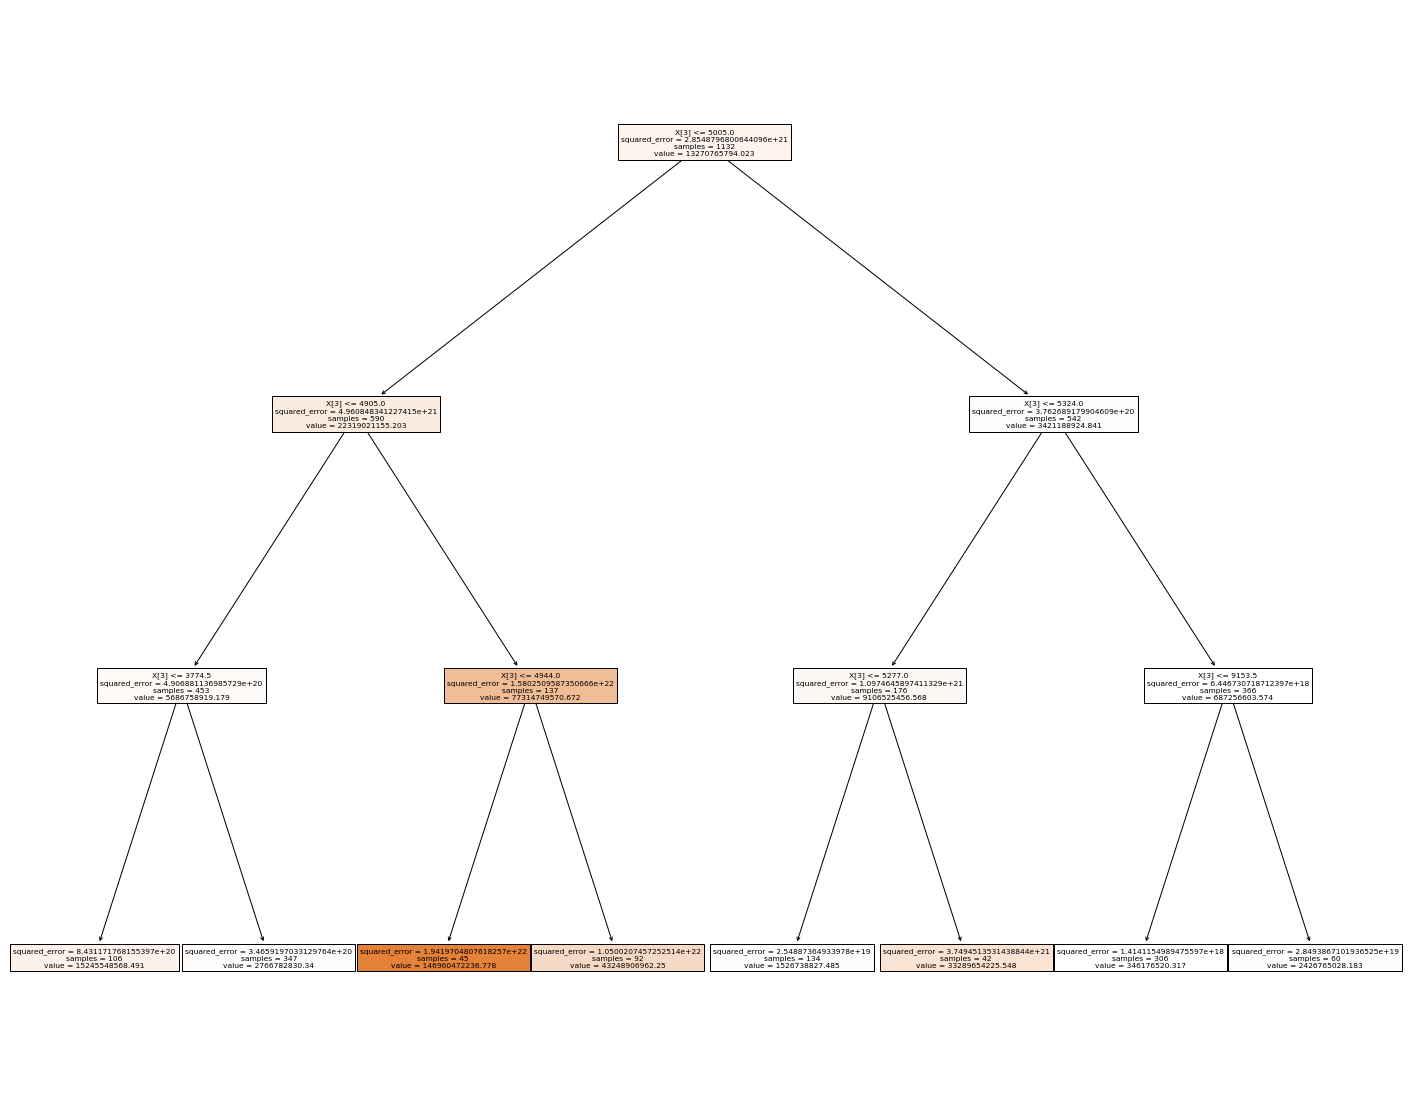

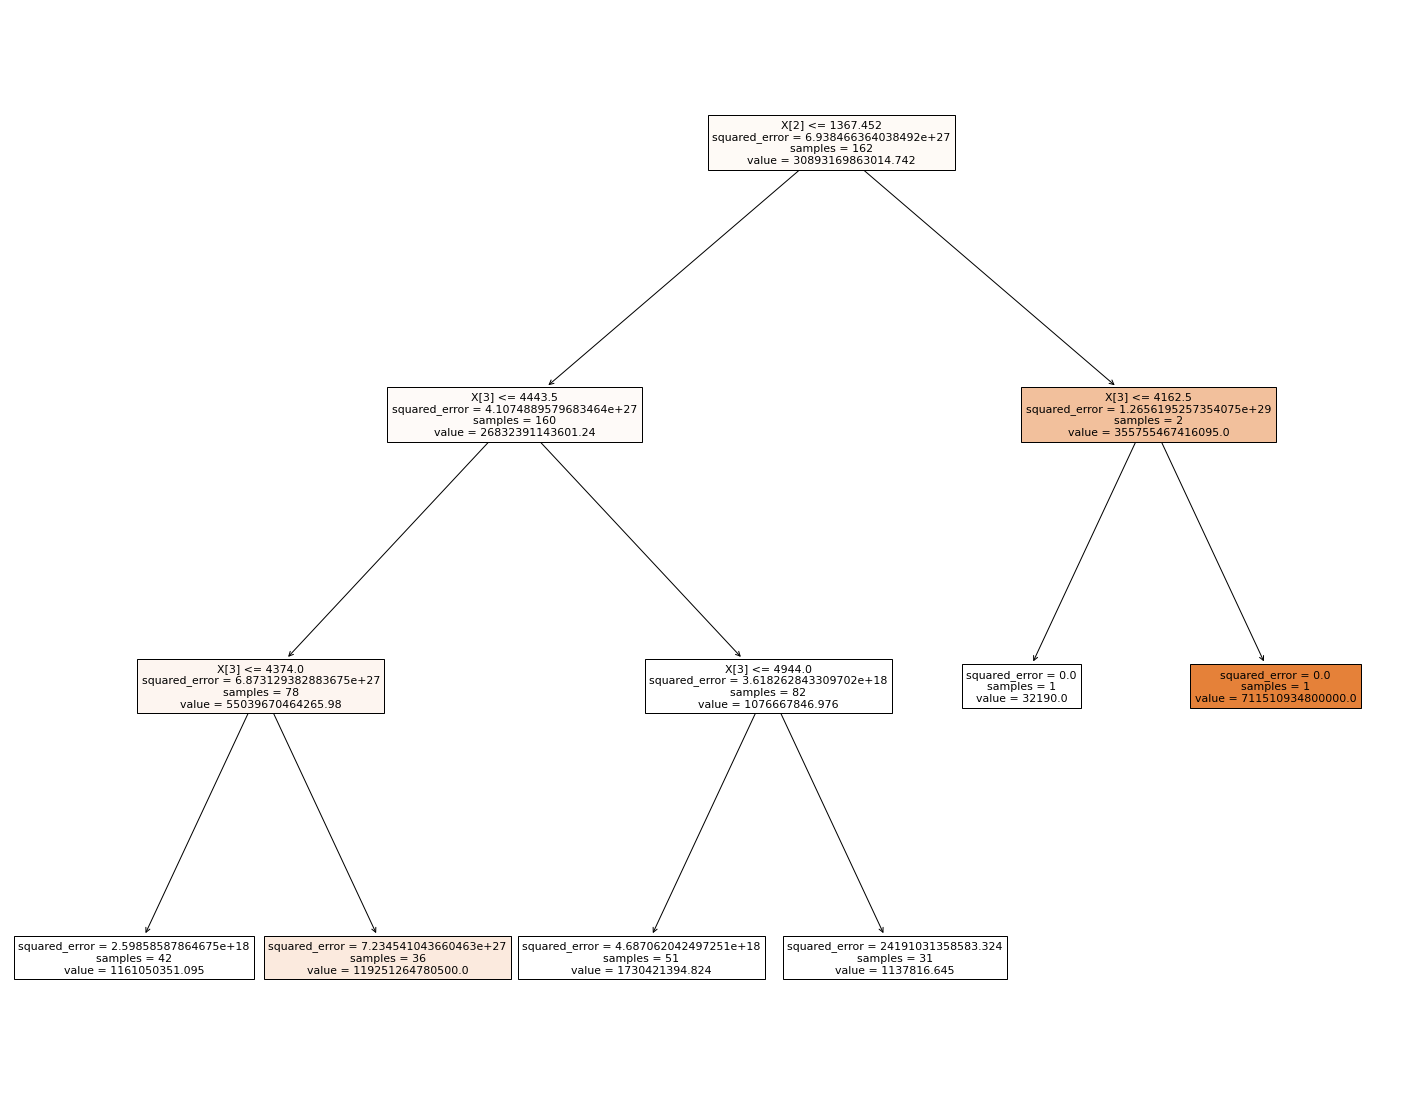

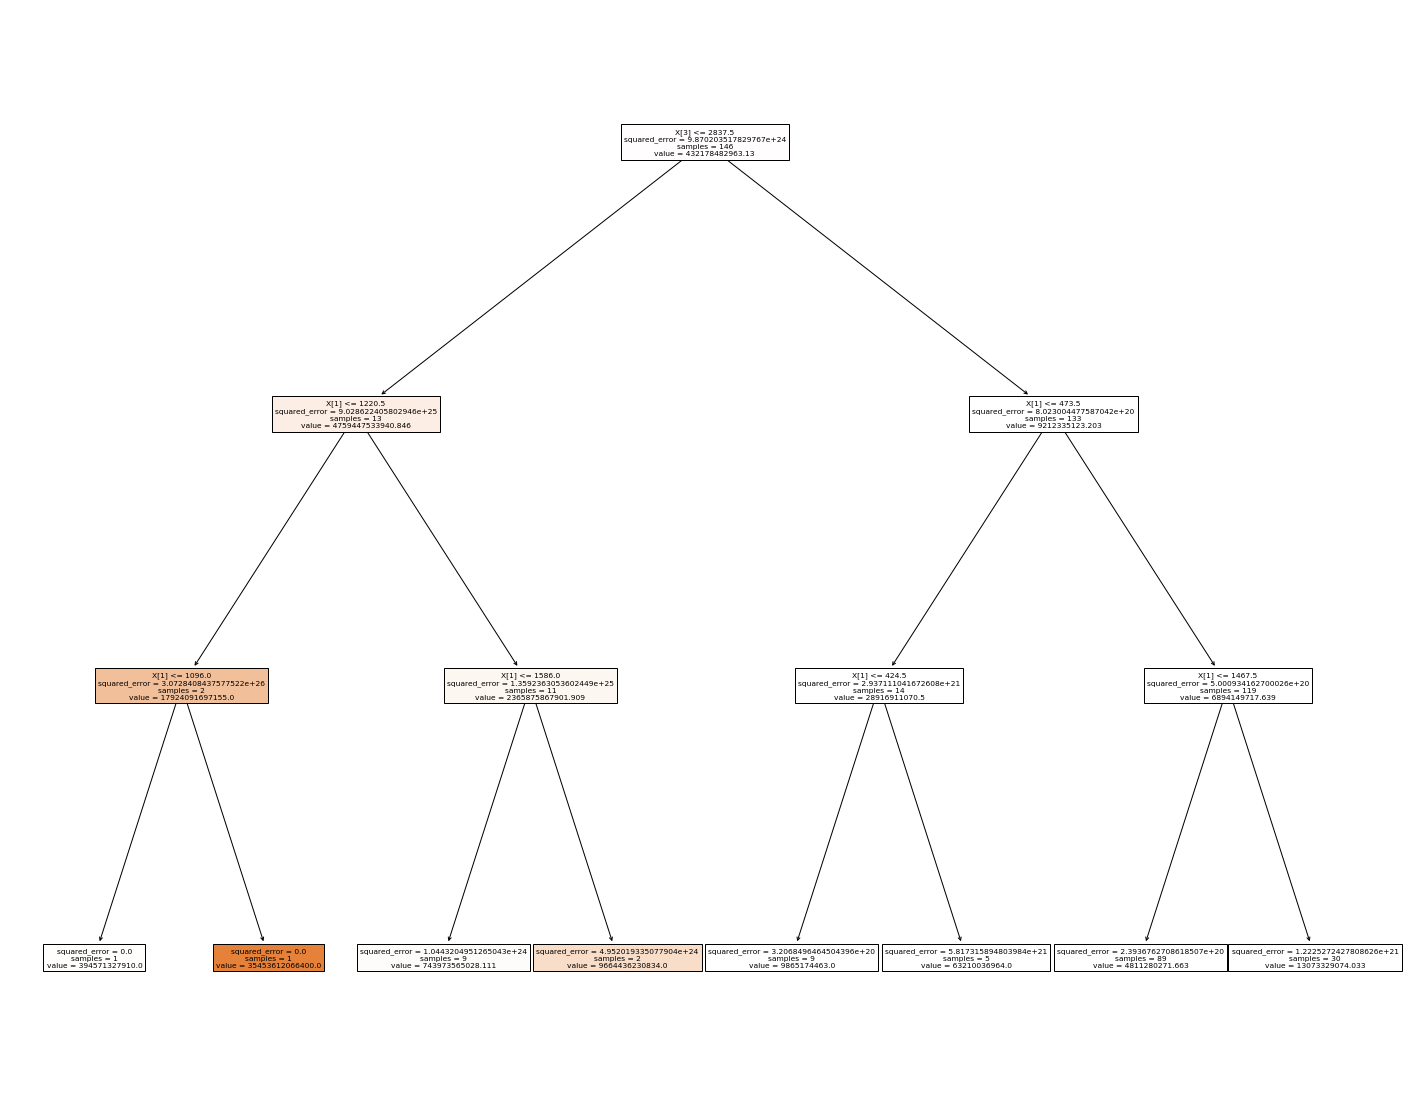

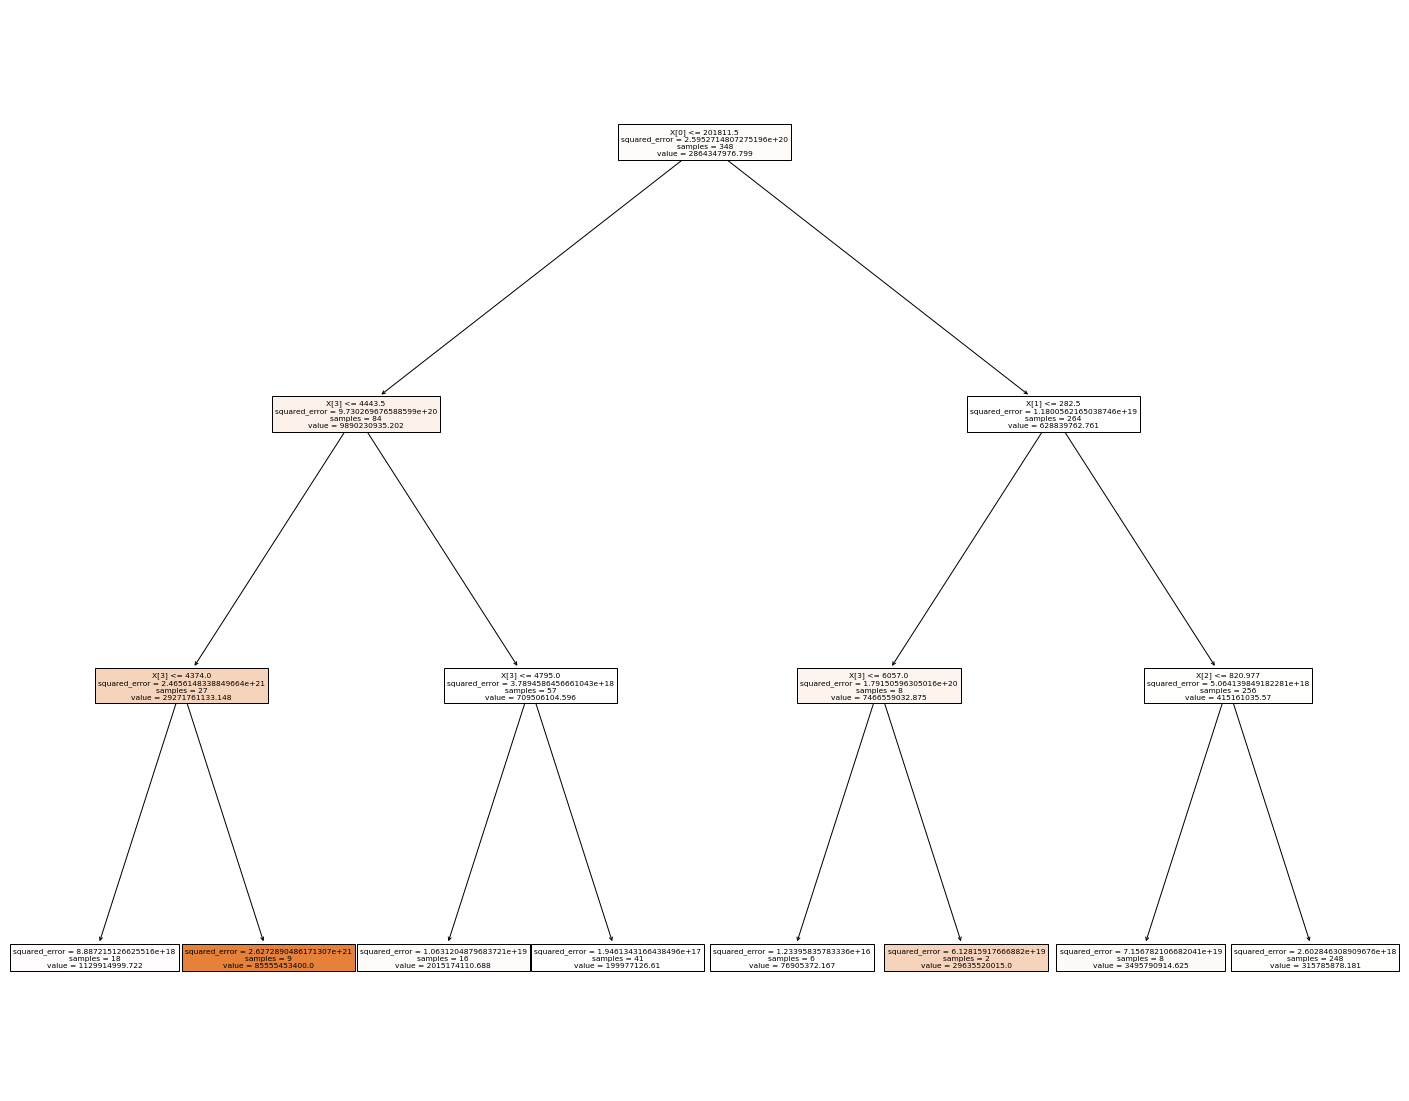

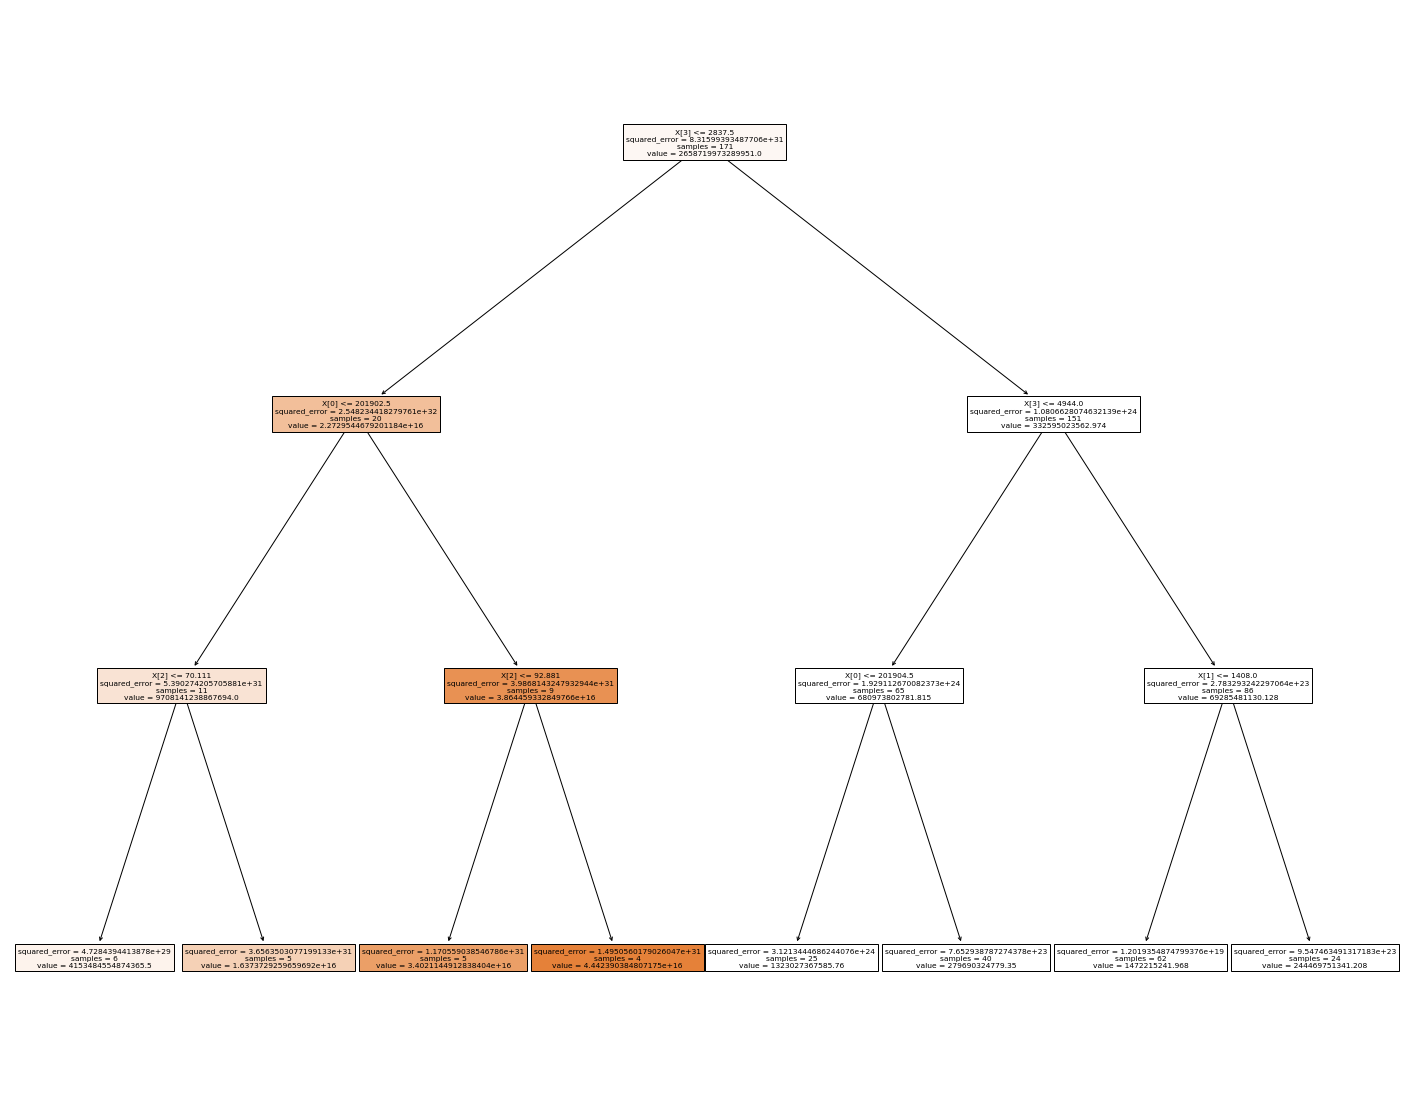

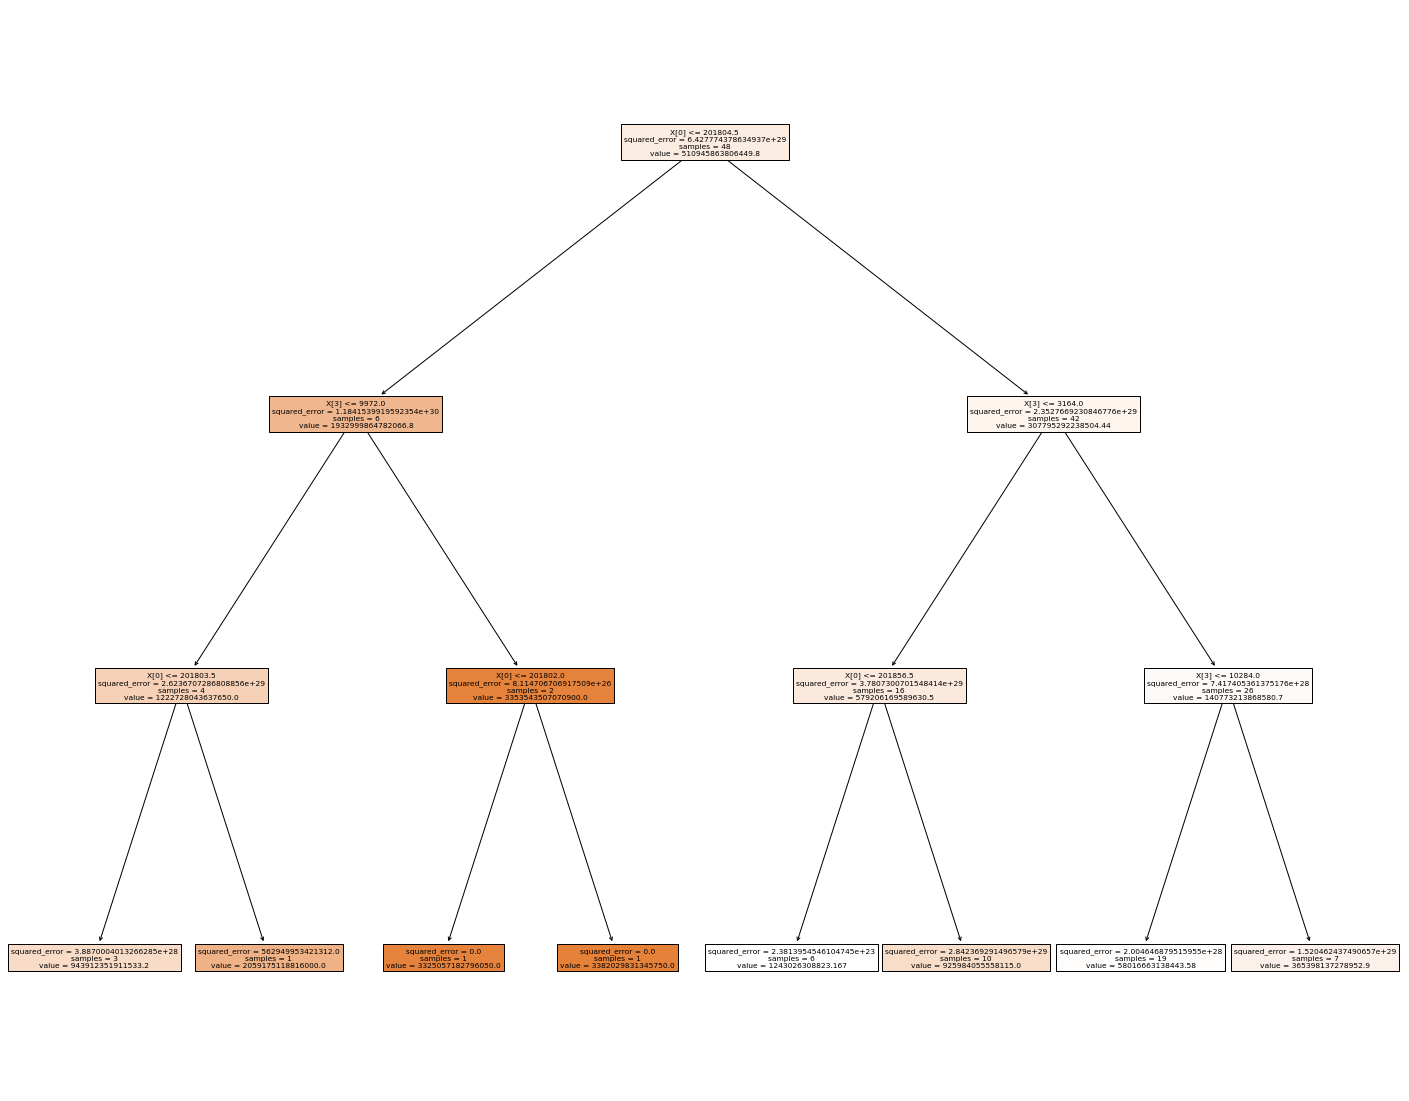

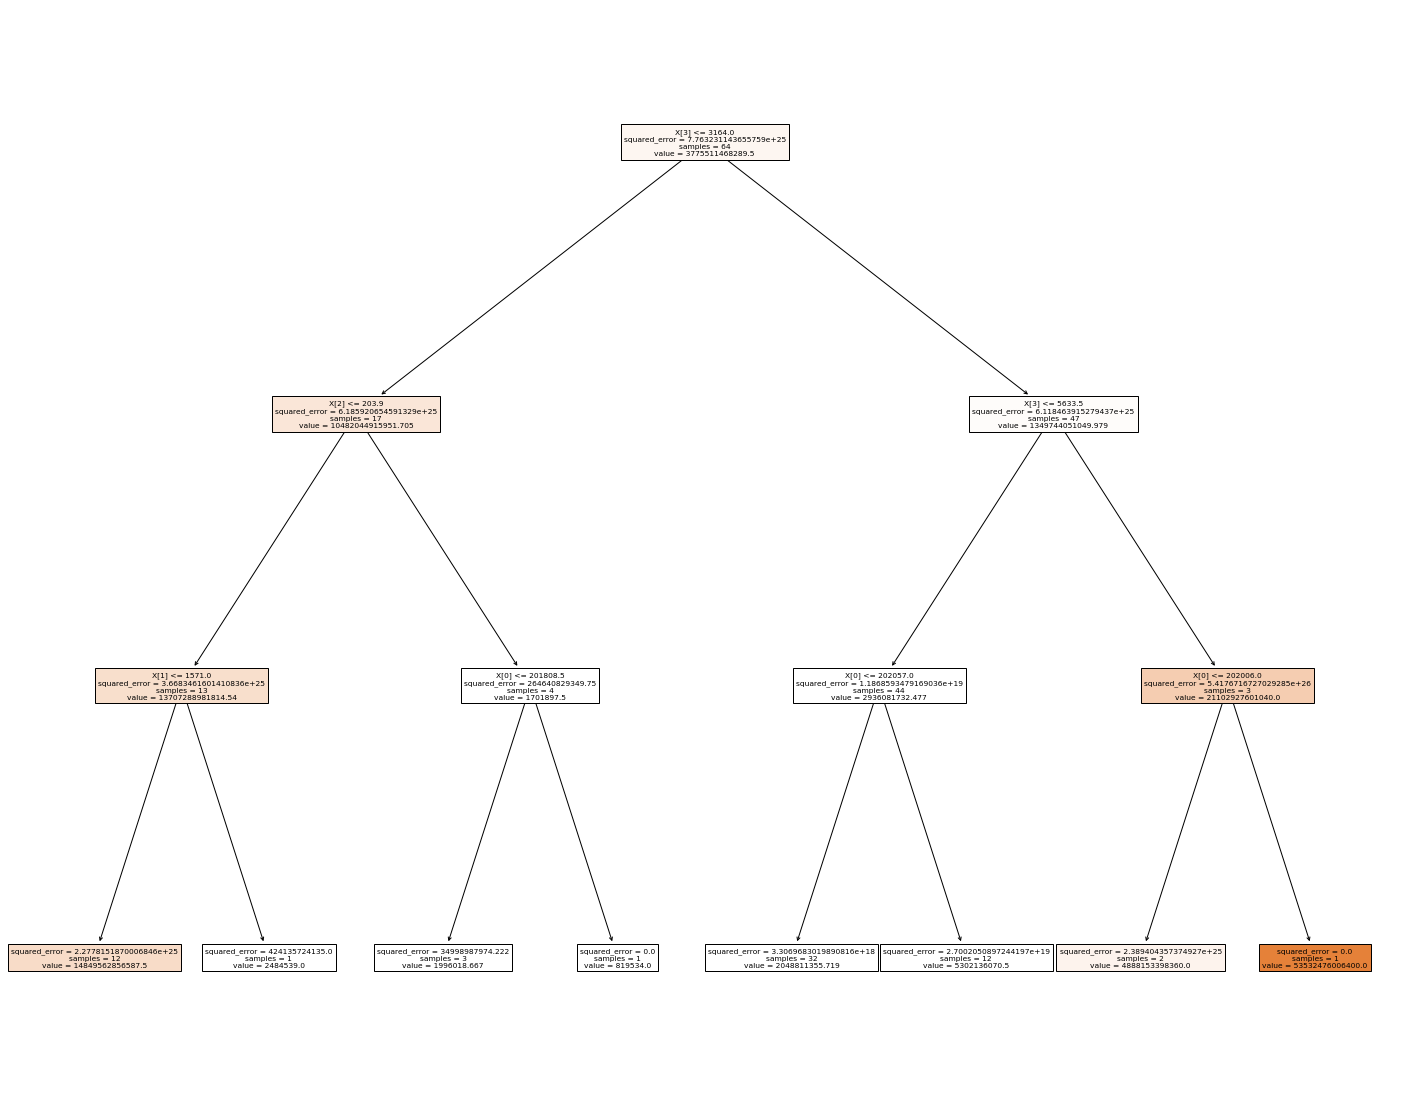

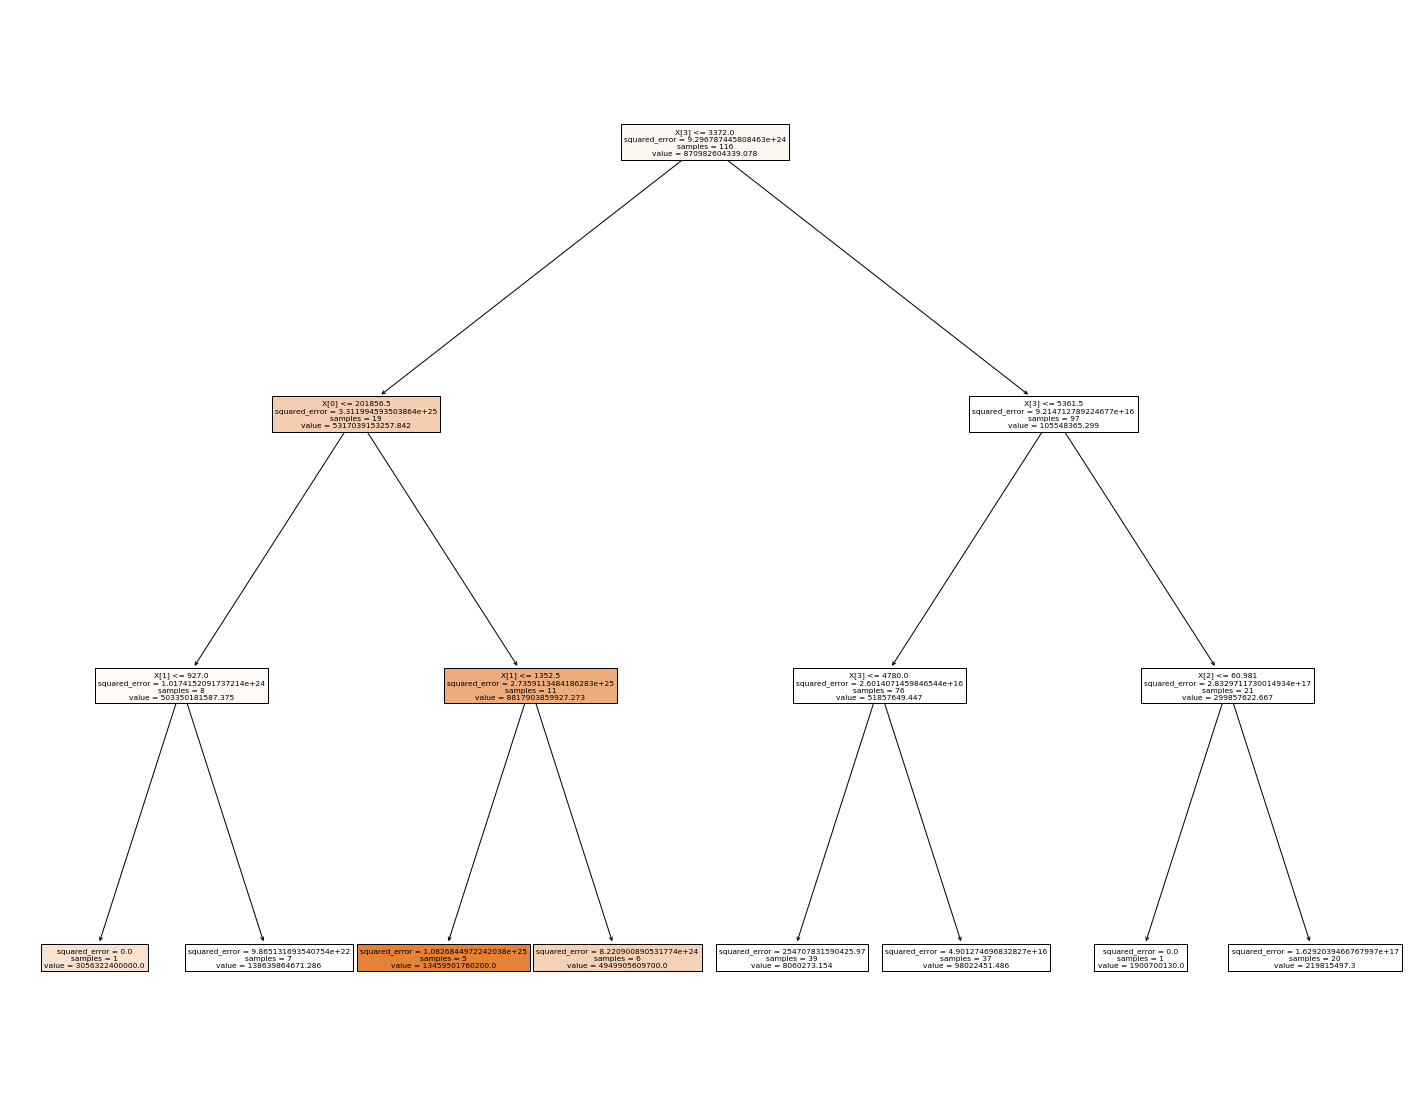

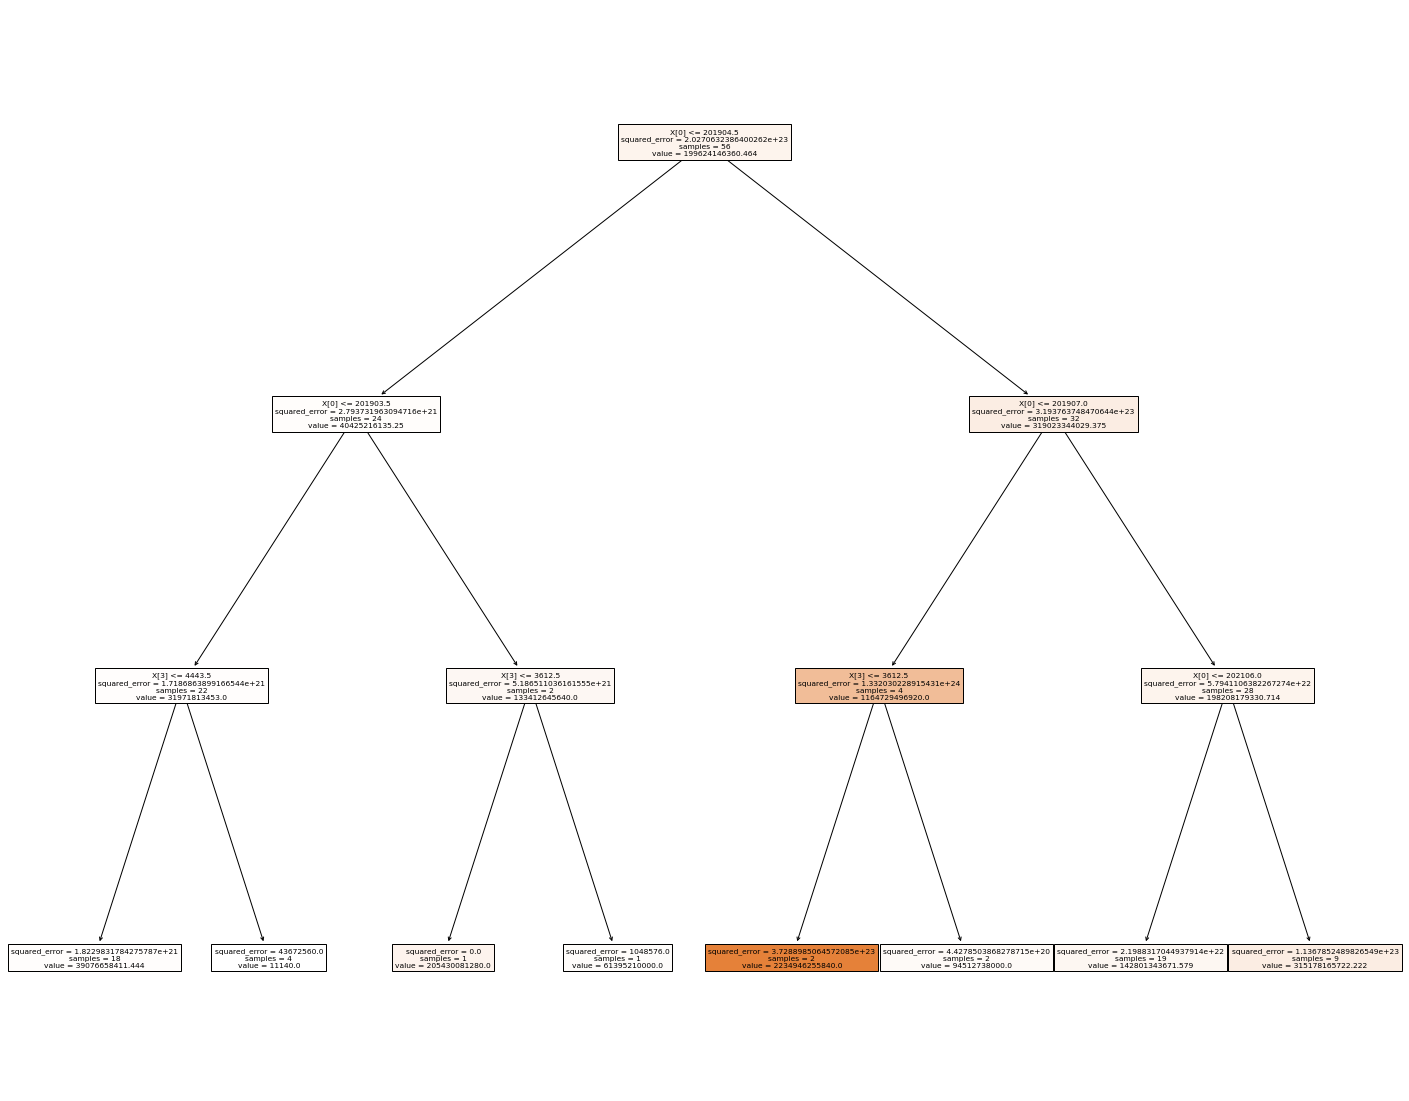

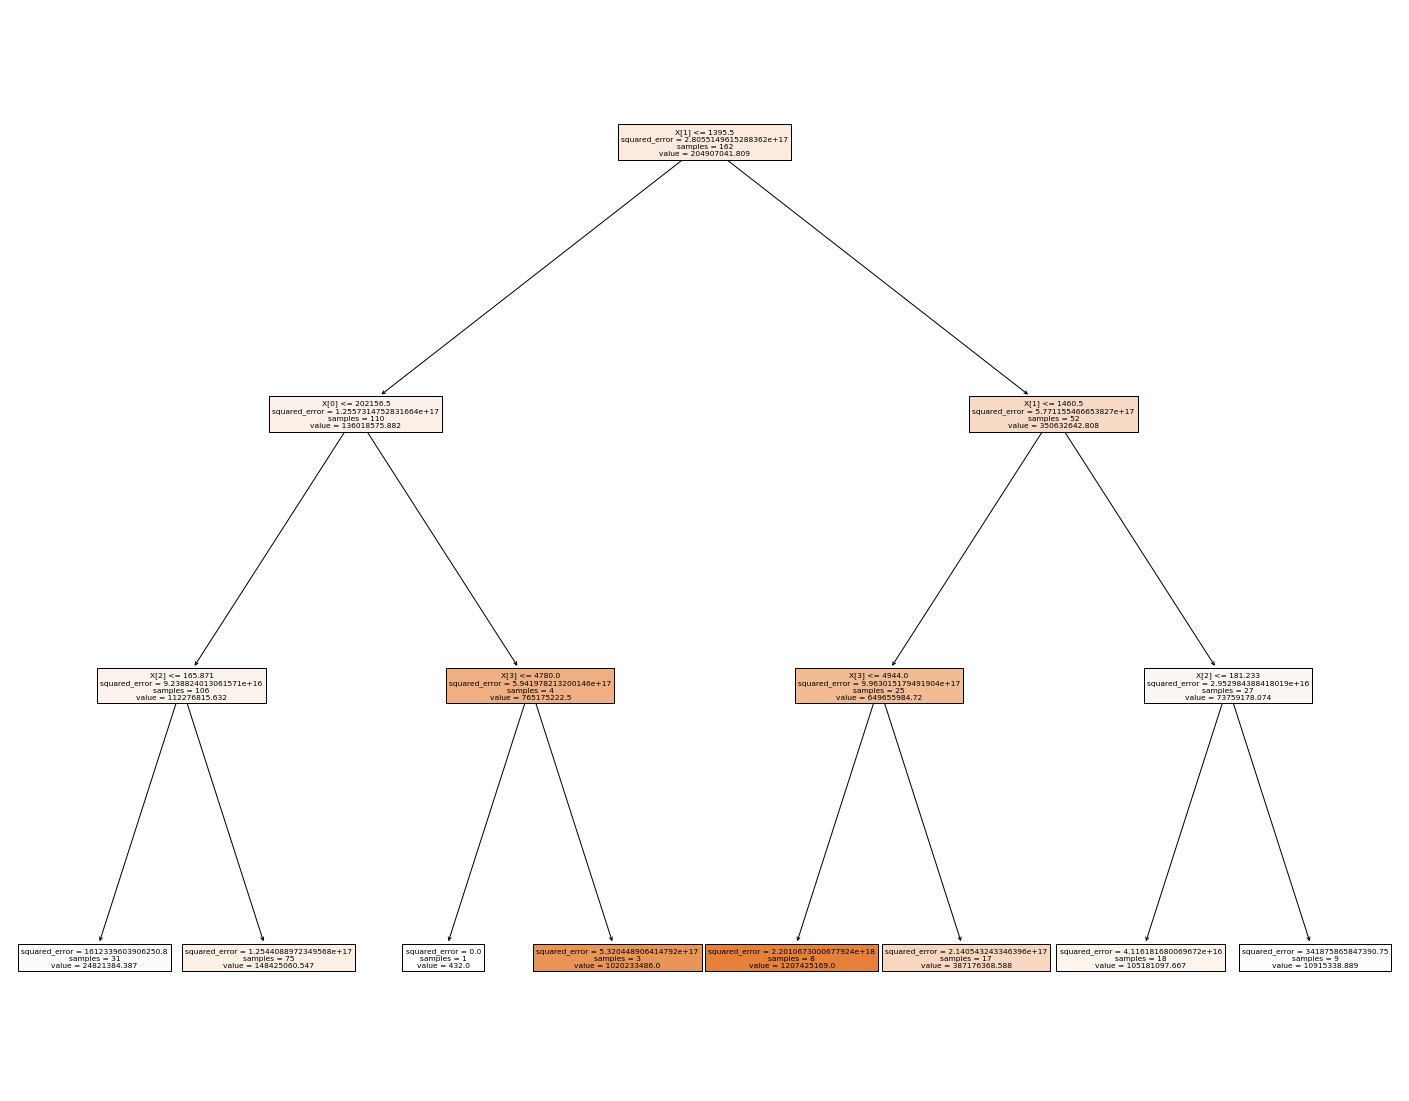

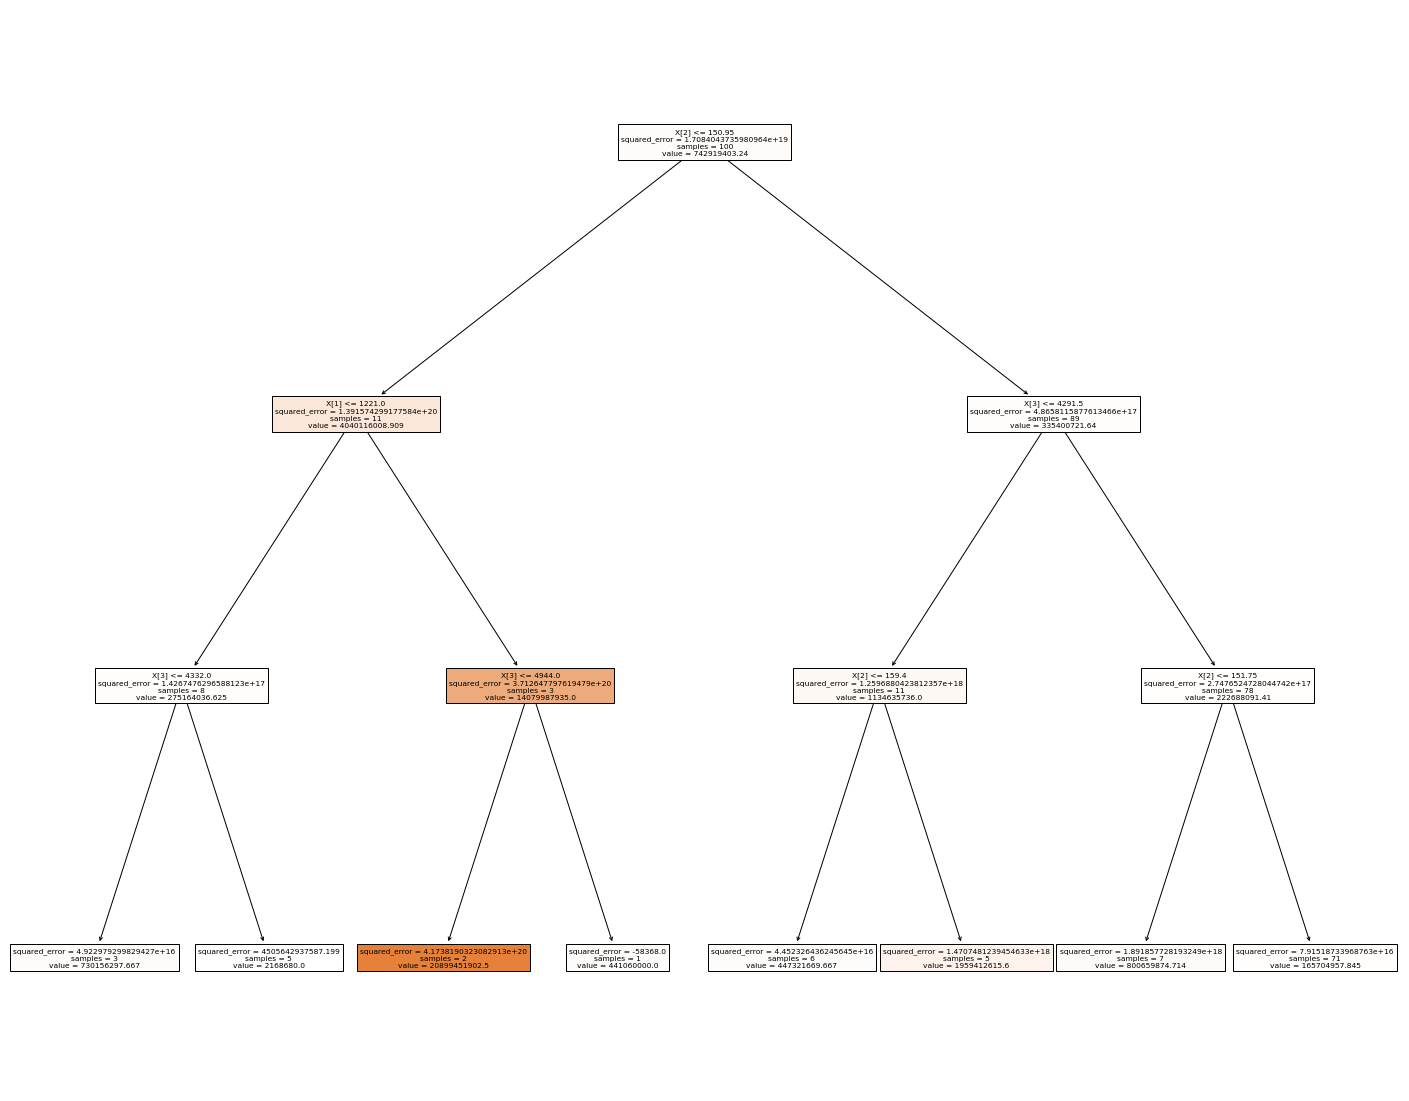

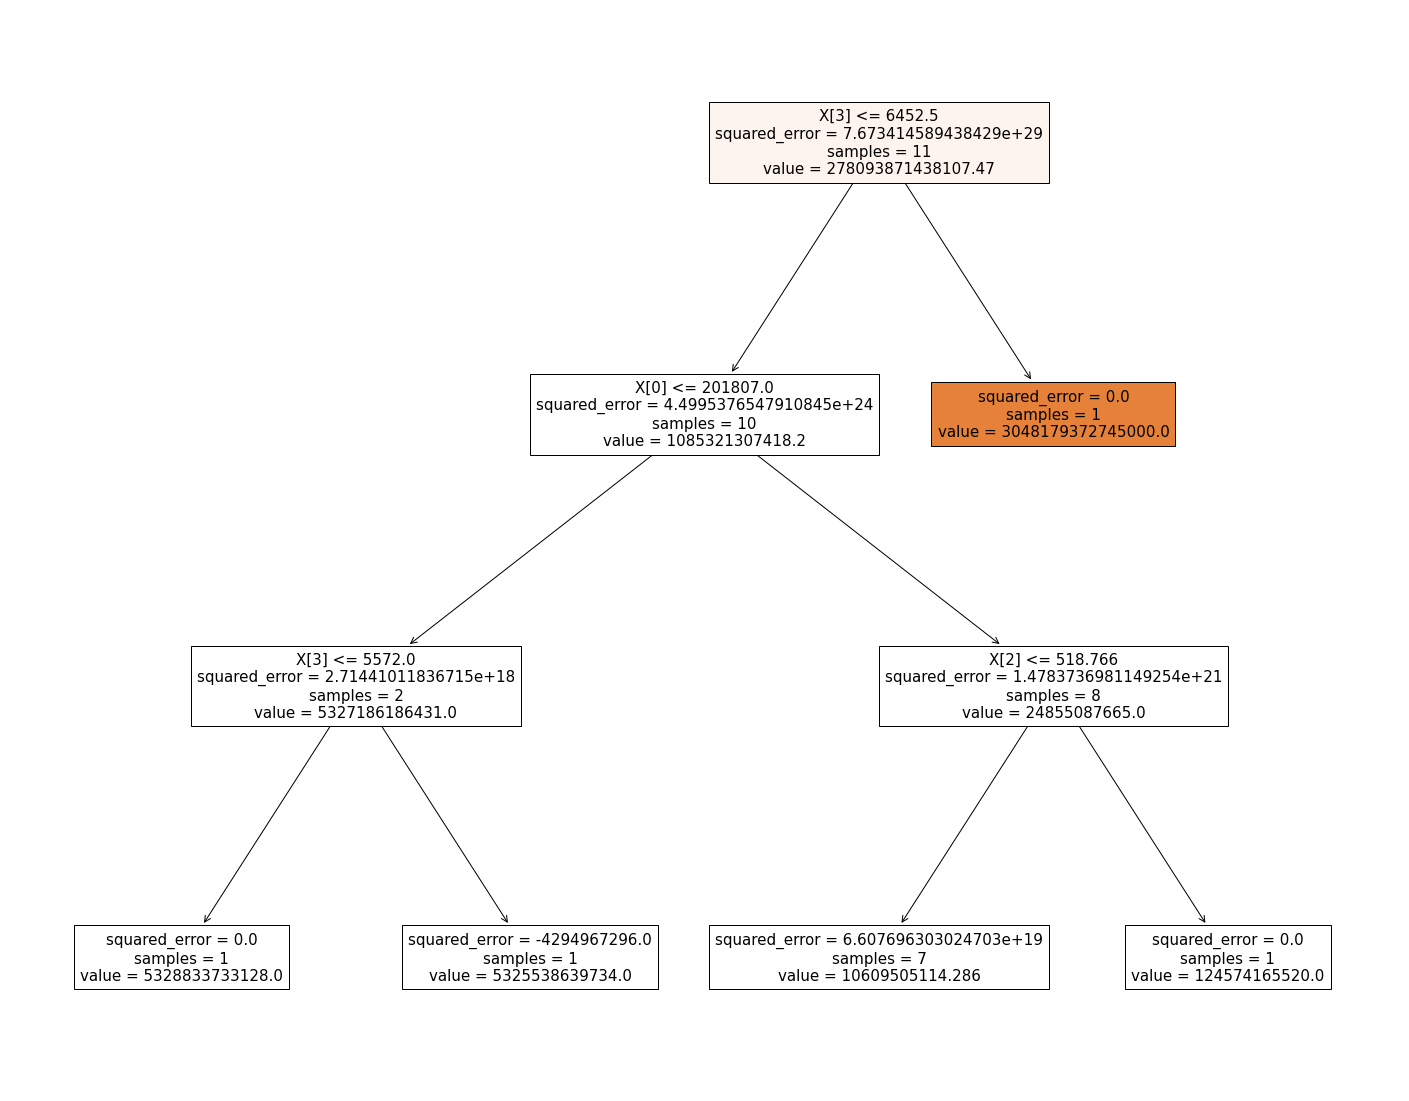

In [18]:
decision_tree_regression_model=tree.DecisionTreeRegressor(max_depth=3, random_state=1234)
for df_name in df_list:  
    # print(df_name.split("_")[1] + "_" + df_name.split("_")[3])
    if locals()[df_name].shape[0] > 1:
        X=locals()[df_name].drop(columns="TOTAL_SOLD_USD")
        Y=locals()[df_name]['TOTAL_SOLD_USD']
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2,random_state=0)
######################################################################################################################        
#                                       Decision Tree Regression                                                     #
######################################################################################################################
        decision_tree_regression_model.fit(x_train, y_train)
        decision_tree_regression_predictions = decision_tree_regression_model.predict(x_test)
        decision_tree_regression_model_mae=mean_absolute_error(y_test, decision_tree_regression_predictions)
        decision_tree_regression_model_rmse=np.sqrt(metrics.mean_squared_error(y_test, decision_tree_regression_predictions))
        decision_tree_regression_model_score=decision_tree_regression_model.score(x_test,y_test)
        # print("\n\nMean Absolute Error:",decision_tree_regression_model_mae)
        # print("RMSE: ",decision_tree_regression_model_rmse)
        # print("Accuracy score of the model : ", decision_tree_regression_model_score)
        models_comparison_matrix = models_comparison_matrix.append({
            'Regression_Commodity_Partner': df_name.split("_")[1] + "_" + df_name.split("_")[3],
            'Predictive_Analysis_Model': decision_tree_regression_model.__class__.__name__ + "_with_" + str(decision_tree_regression_model.get_params()['max_leaf_nodes']) + "_max_leaf_modes",
            'Accuracy_Score': decision_tree_regression_model_score,
            'Mean_Absolute_Error' : decision_tree_regression_model_mae,
            'Root_Mean_Squared_Error':decision_tree_regression_model_rmse
        }, ignore_index=True)
        print(df_name)
        fig = plt.figure(figsize=(25,20))
        tree.plot_tree(decision_tree_regression_model,filled=True)

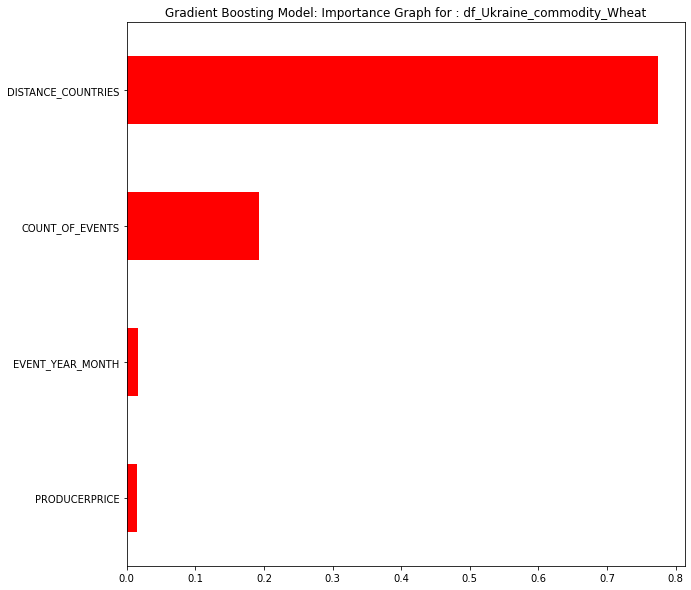

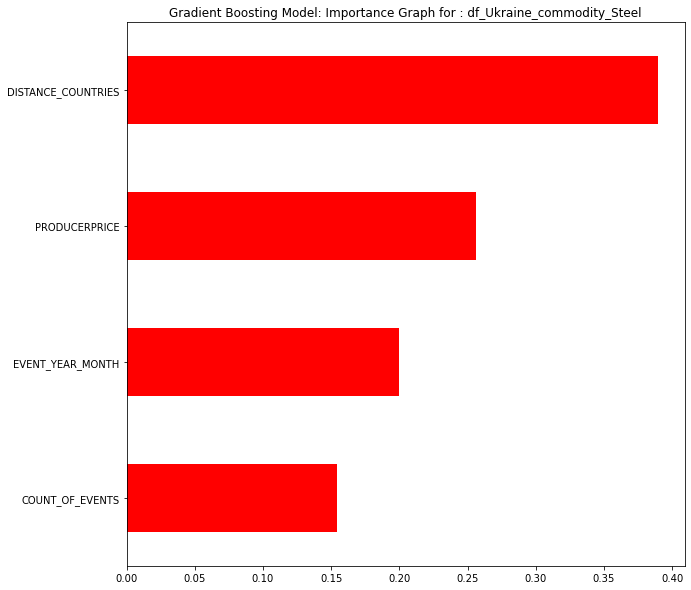

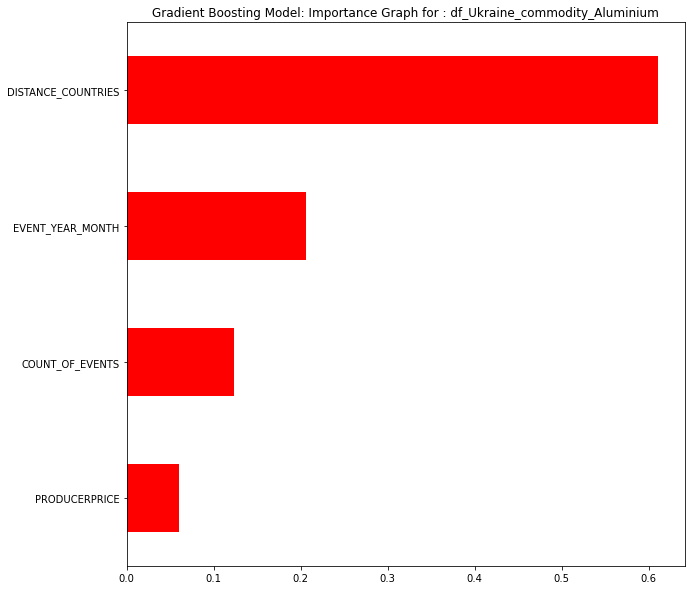

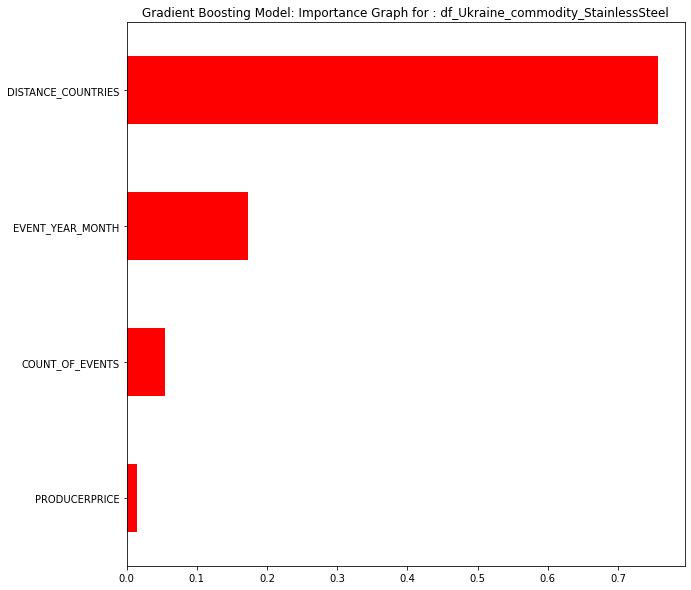

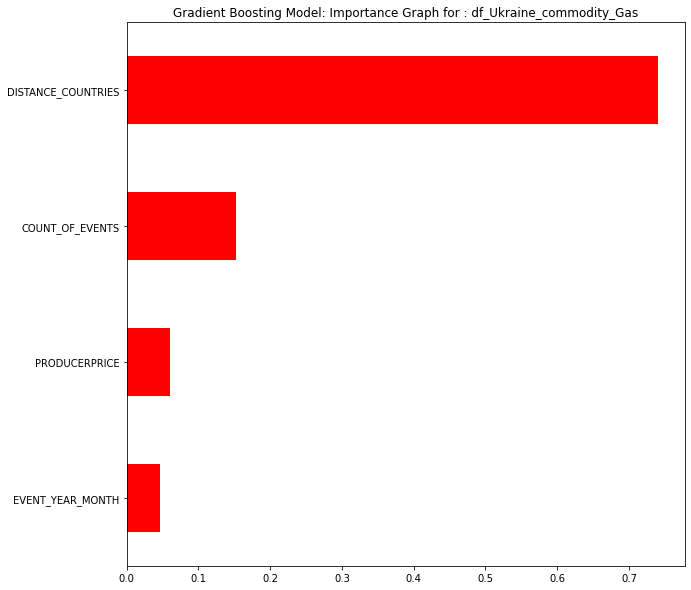

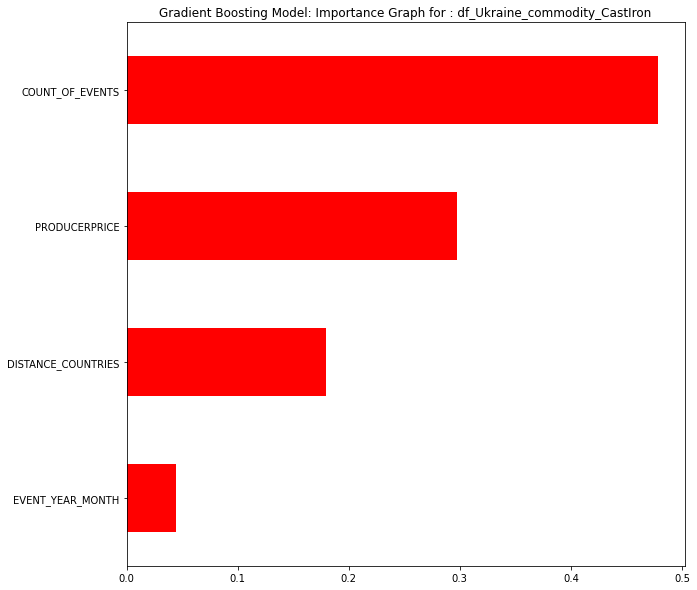

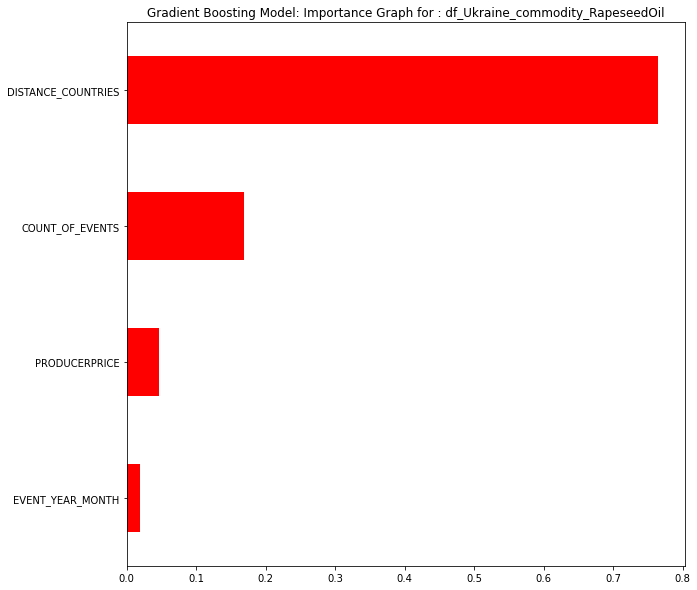

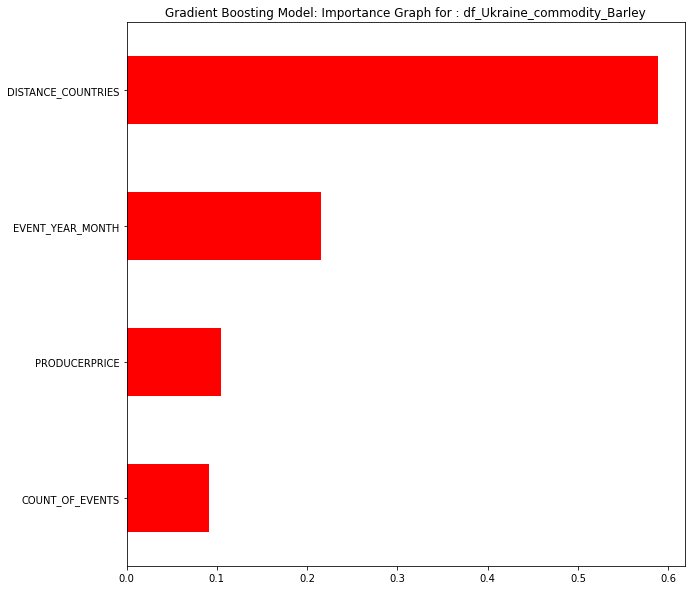

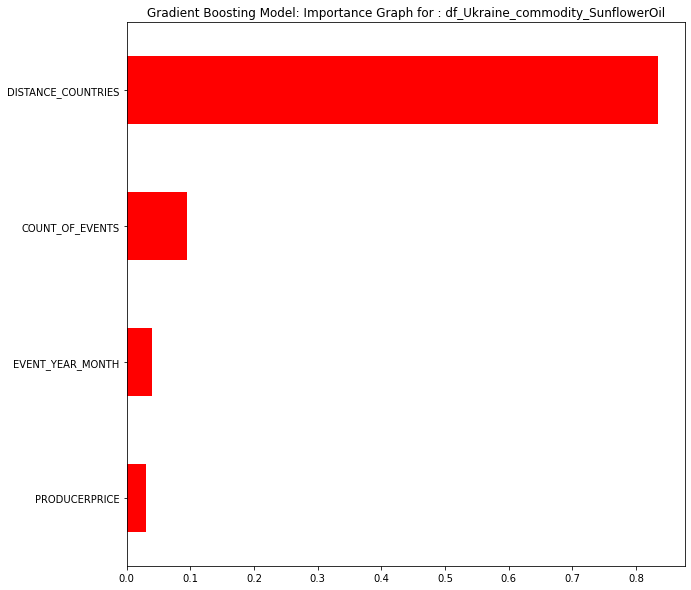

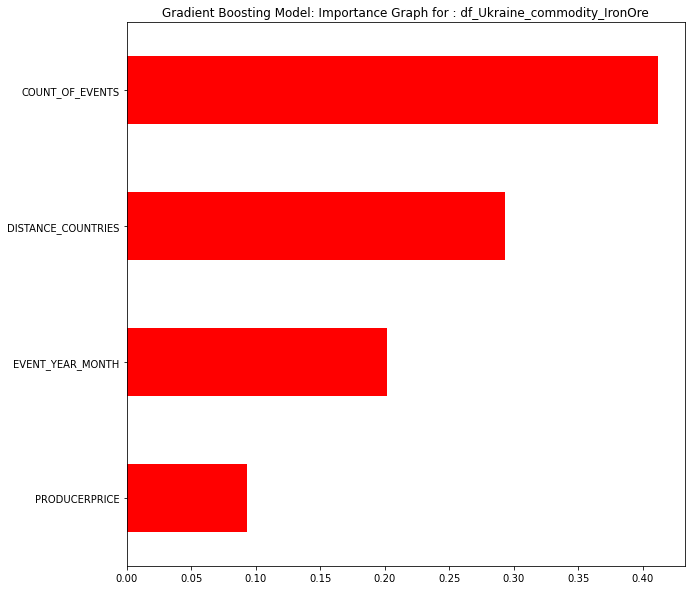

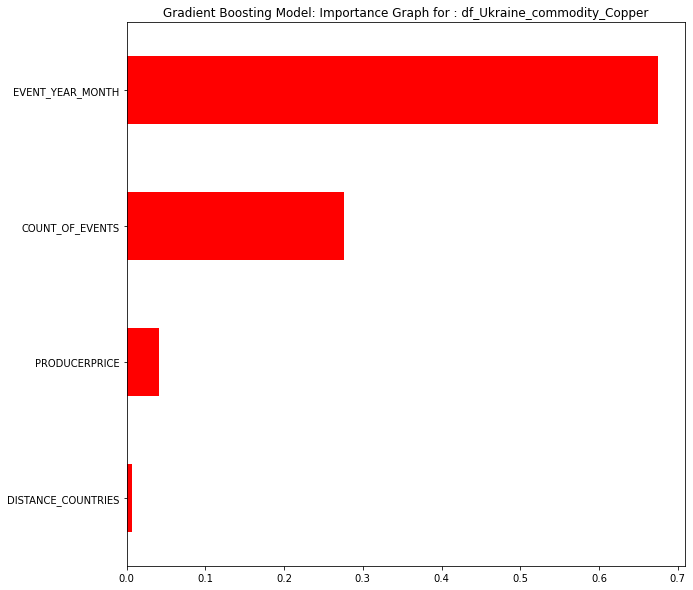

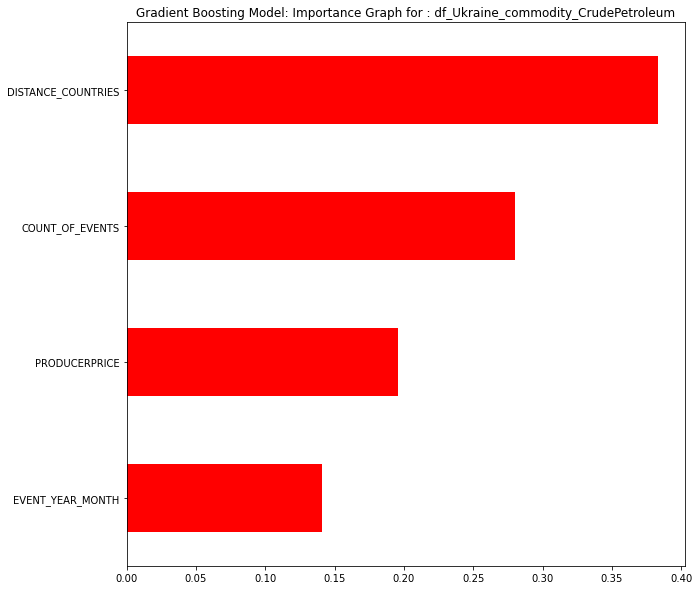

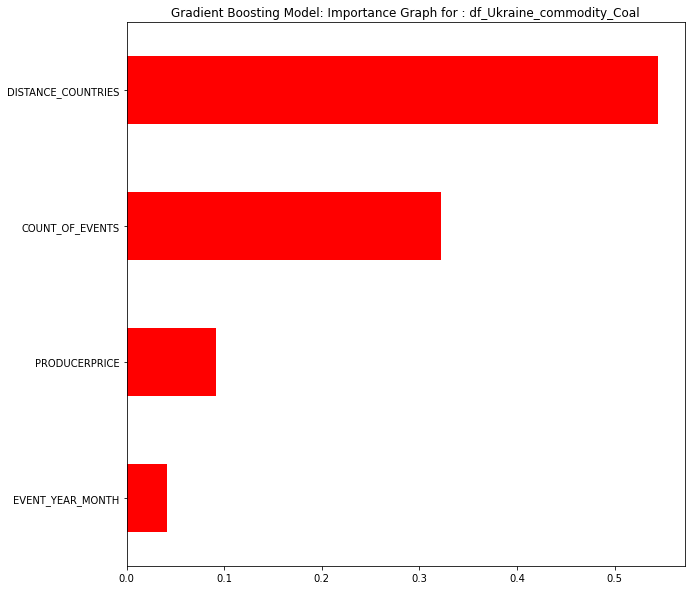

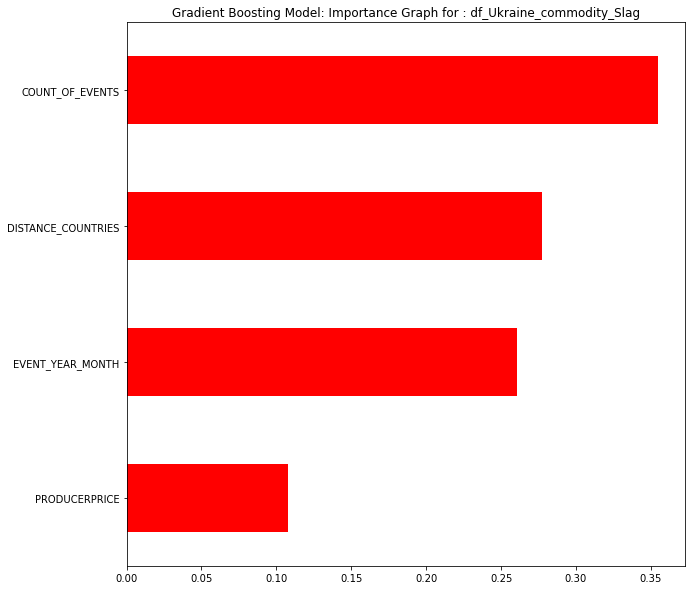

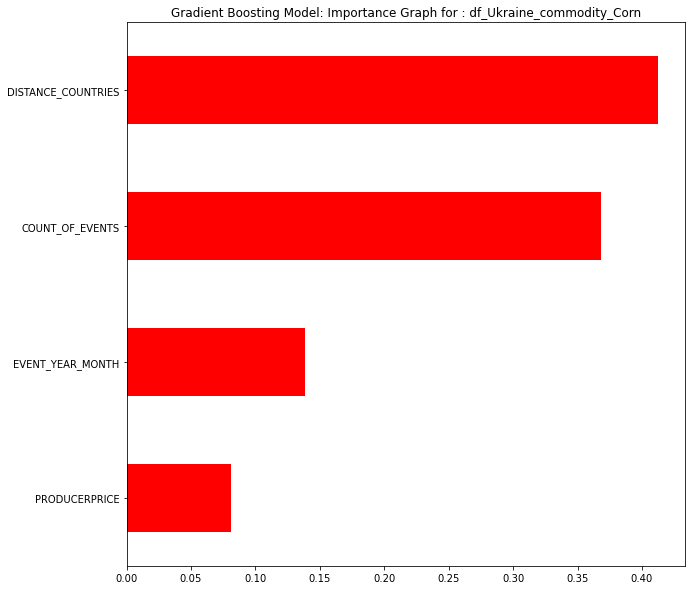

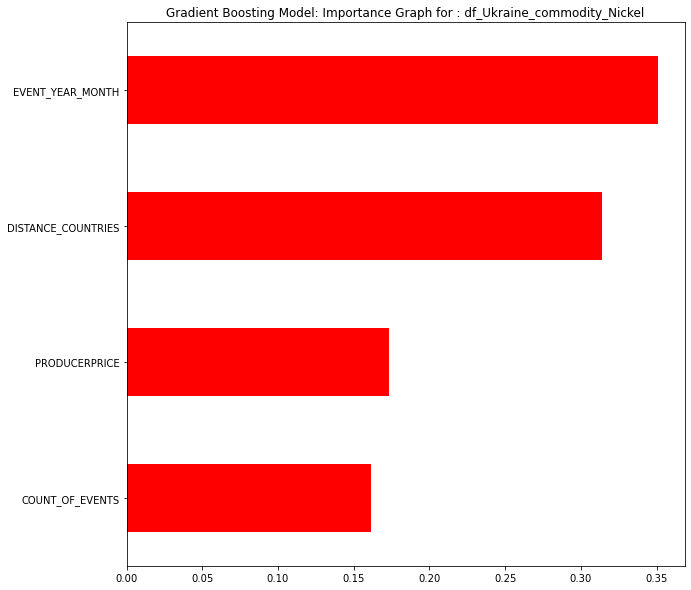

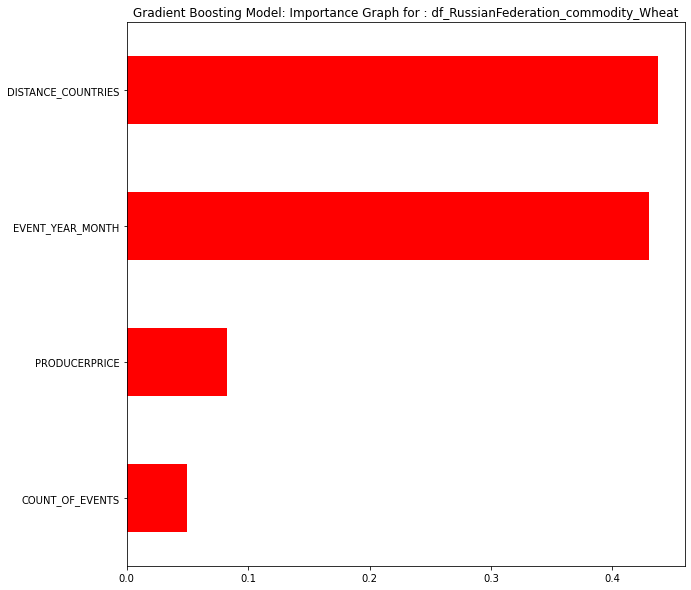

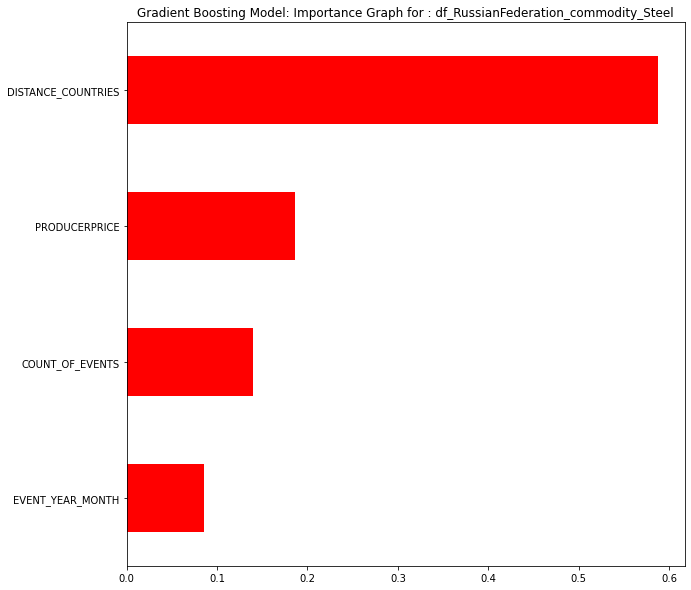

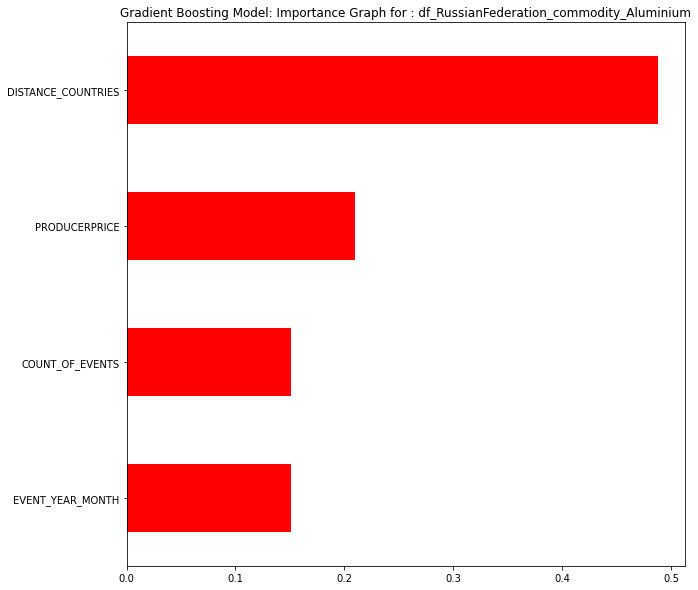

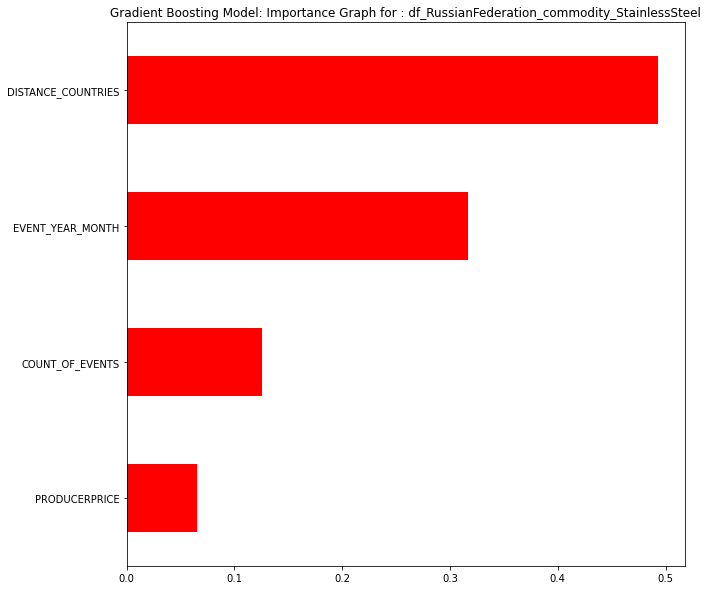

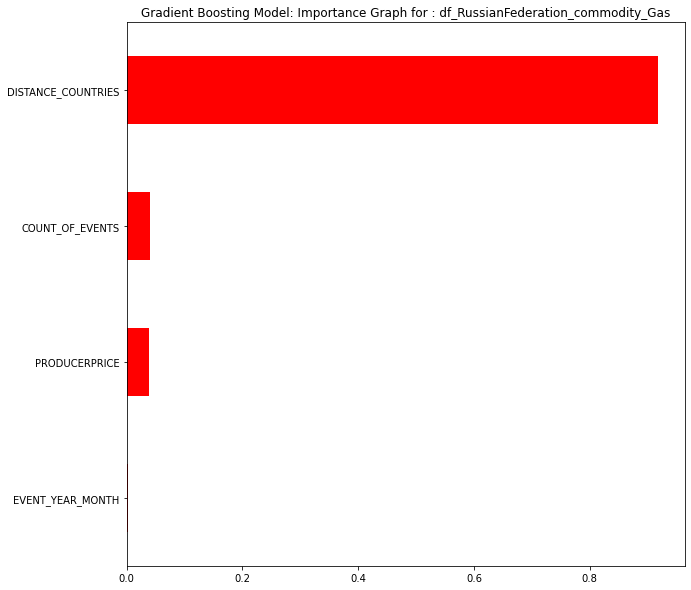

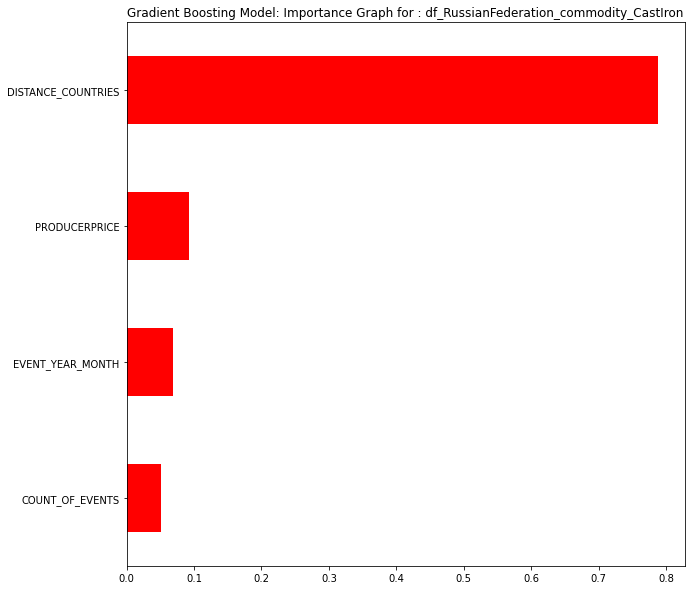

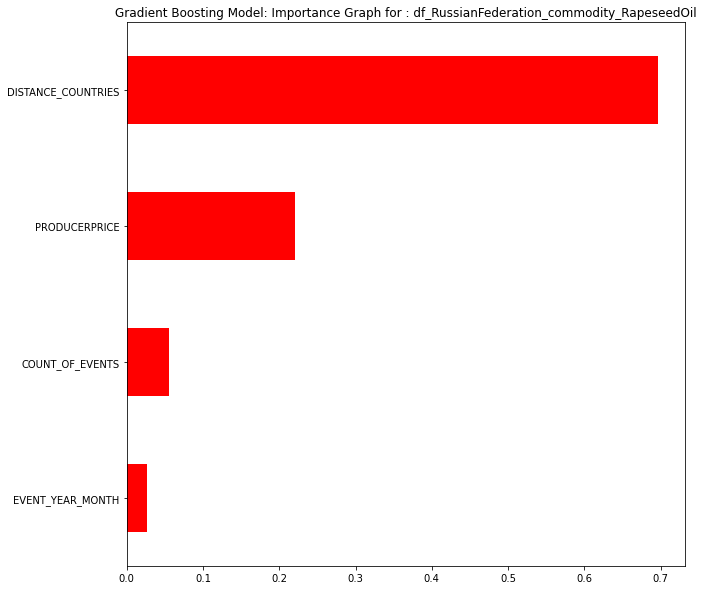

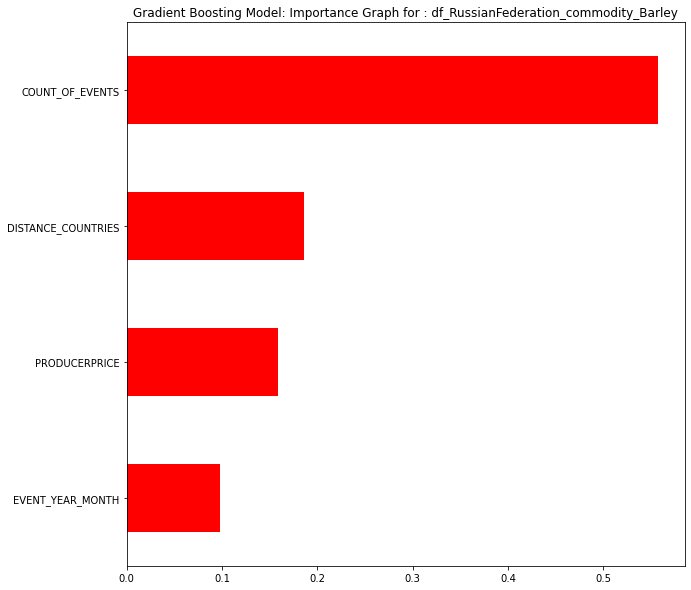

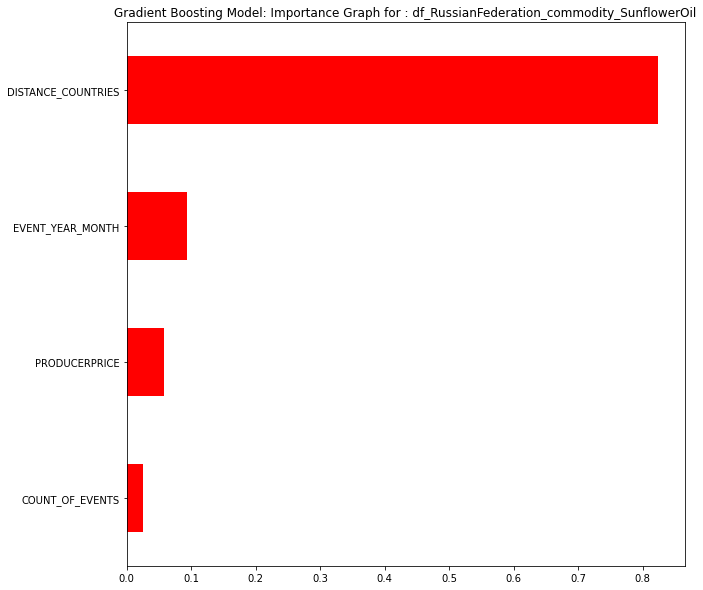

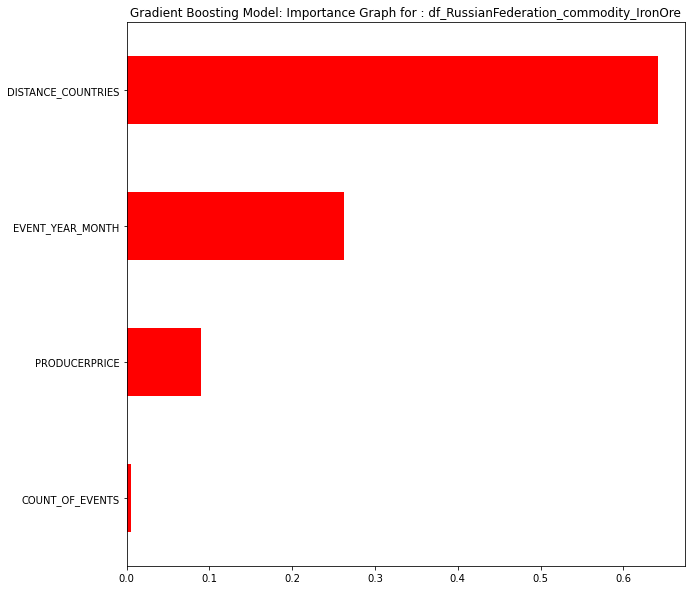

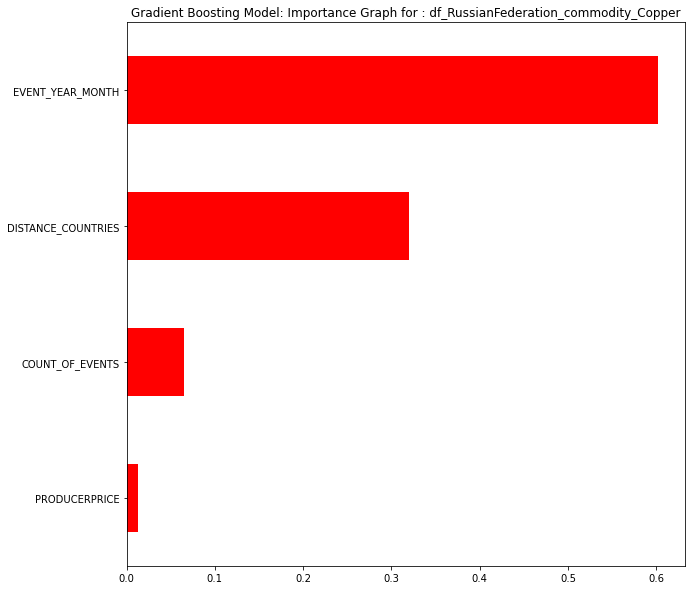

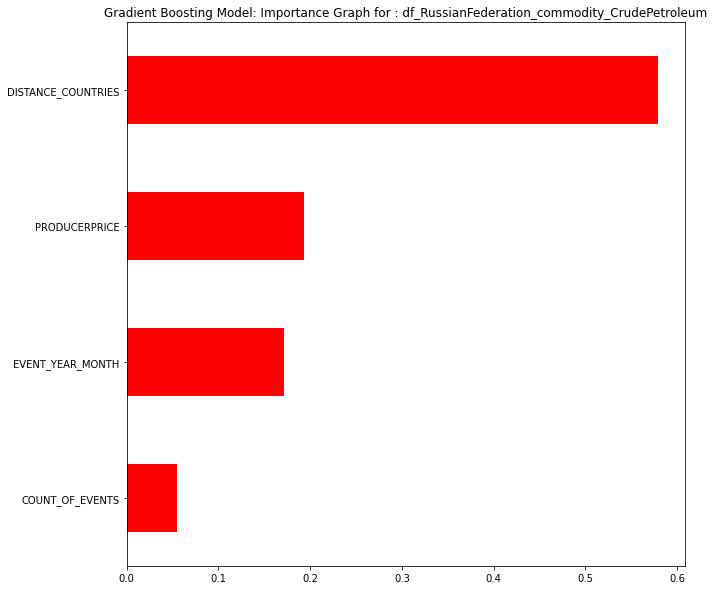

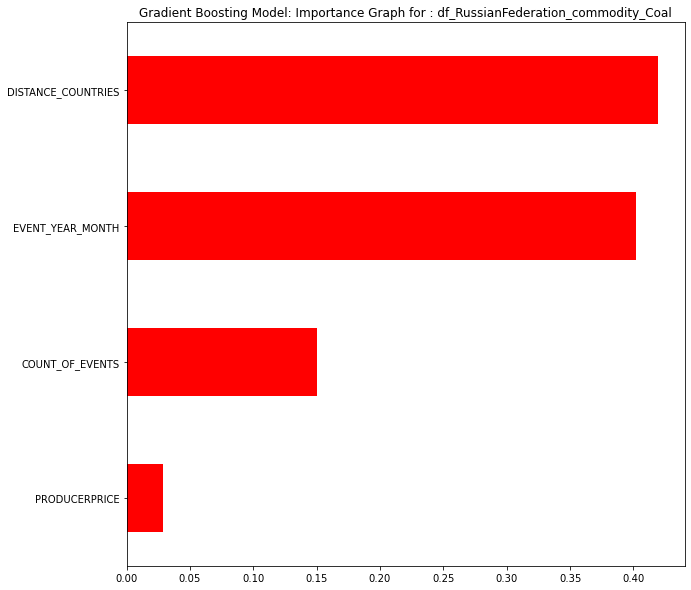

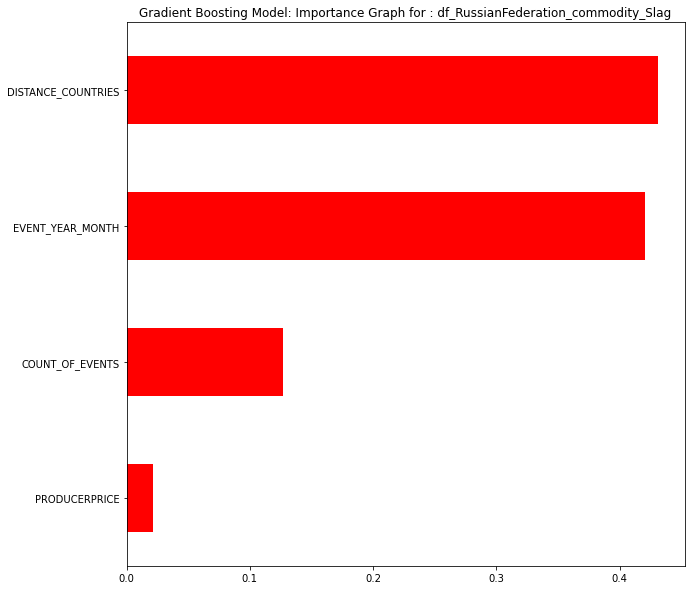

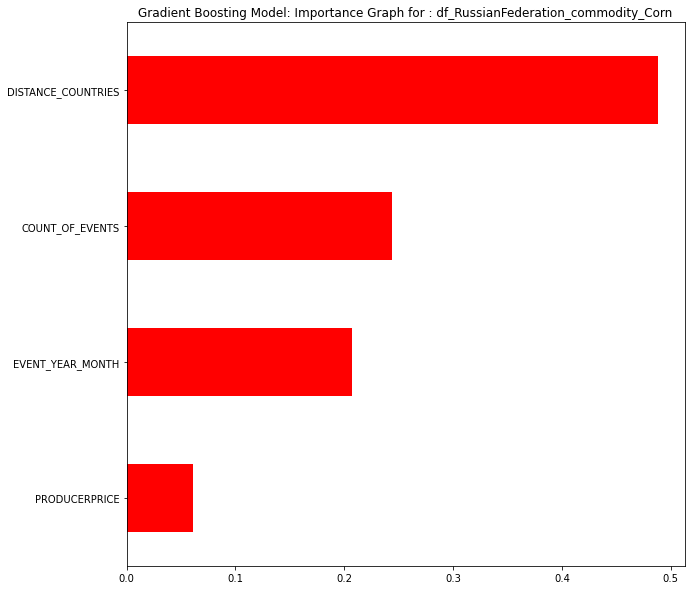

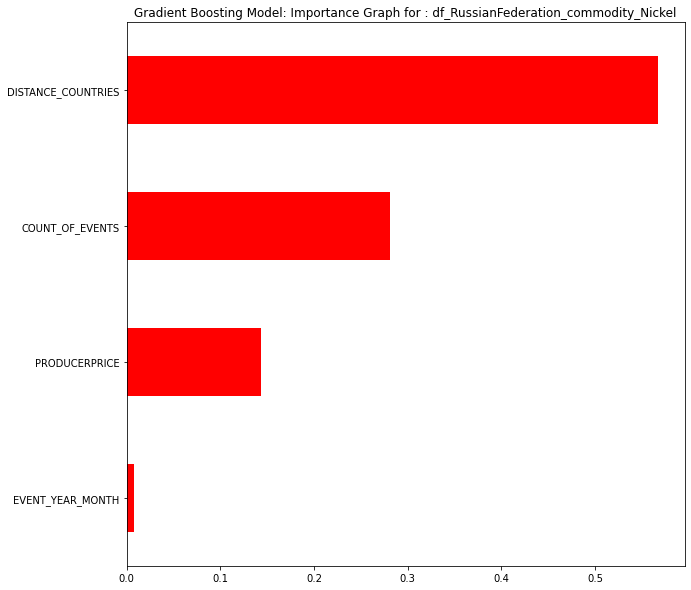

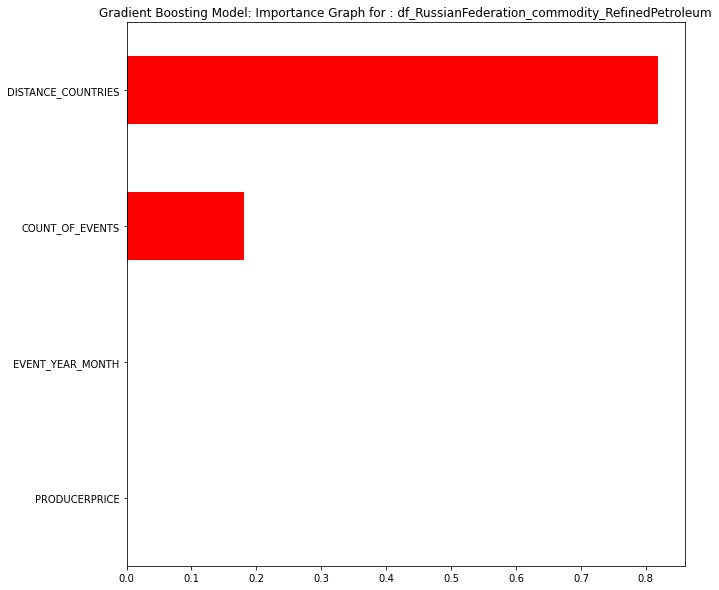

In [19]:
gradient_boost_regression_model = GradientBoostingRegressor()
for df_name in df_list:  
    # print(df_name.split("_")[1] + "_" + df_name.split("_")[3])
    if locals()[df_name].shape[0] > 1:
        X=locals()[df_name].drop(columns="TOTAL_SOLD_USD")
        Y=locals()[df_name]['TOTAL_SOLD_USD']
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2,random_state=0)
######################################################################################################################        
#                                       Gradient Boost Regression                                                    #
######################################################################################################################        
        gradient_boost_regression_model.fit(x_train, y_train)
        gradient_boost_regression_predictions = gradient_boost_regression_model.predict(x_test)
        gradient_boost_regression_model_mae=mean_absolute_error(y_test, gradient_boost_regression_predictions)
        gradient_boost_regression_model_rmse=np.sqrt(metrics.mean_squared_error(y_test, gradient_boost_regression_predictions))
        gradient_boost_regression_model_score=gradient_boost_regression_model.score(x_test,y_test)
        # print("\n\nMean Absolute Error:",gradient_boost_regression_model_mae)
        # print("RMSE: ",gradient_boost_regression_model_rmse)
        # print("Accuracy score of the model : ", gradient_boost_regression_model_score)
        models_comparison_matrix = models_comparison_matrix.append({
            'Regression_Commodity_Partner': df_name.split("_")[1] + "_" + df_name.split("_")[3],
            'Predictive_Analysis_Model': gradient_boost_regression_model.__class__.__name__, 
            'Accuracy_Score': gradient_boost_regression_model_score,
            'Mean_Absolute_Error' : gradient_boost_regression_model_mae,
            'Root_Mean_Squared_Error':gradient_boost_regression_model_rmse
        }, ignore_index=True)
        
        columns=x_train.columns
        importance_gb=gradient_boost_regression_model.feature_importances_
        gbr_graph=pd.Series(importance_gb, columns)
        fig = plt.figure(figsize=(10,10))
        gbr_graph.sort_values().plot.barh(color='Red')
        title="Gradient Boosting Model: Importance Graph for : " + df_name
        plt.title(title)

        


In [20]:
print(x_train)

       EVENT_YEAR_MONTH  COUNT_OF_EVENTS  PRODUCERPRICE  DISTANCE_COUNTRIES
10181            201812             1392        480.200                3922
4114             201802             1257        449.200                6217
10416            201901             1166        481.200                3922
9182             201902             1275        480.700                4927
675              201903             1488        477.300                4927
7119             202112              616        556.332                4180
10180            201812             1392        480.200                4927
4132             201802             1257        449.200                4927
674              201903             1488        477.300                3922
6652             201811             1581        478.700                6688
10406            201901             1166        481.200                4927


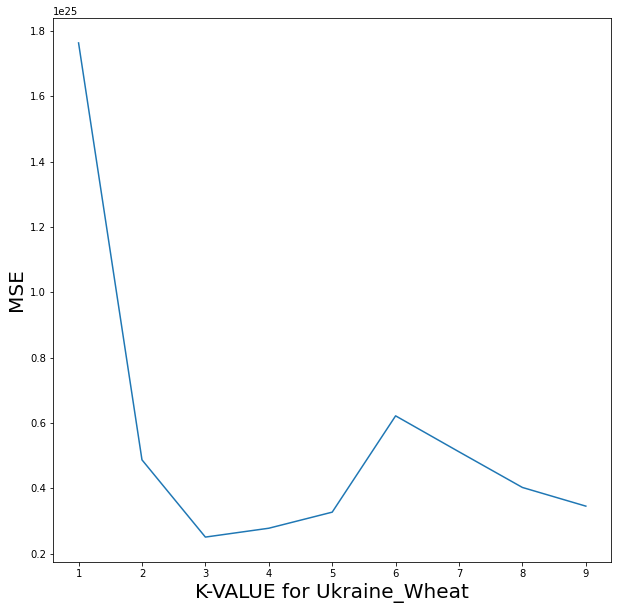

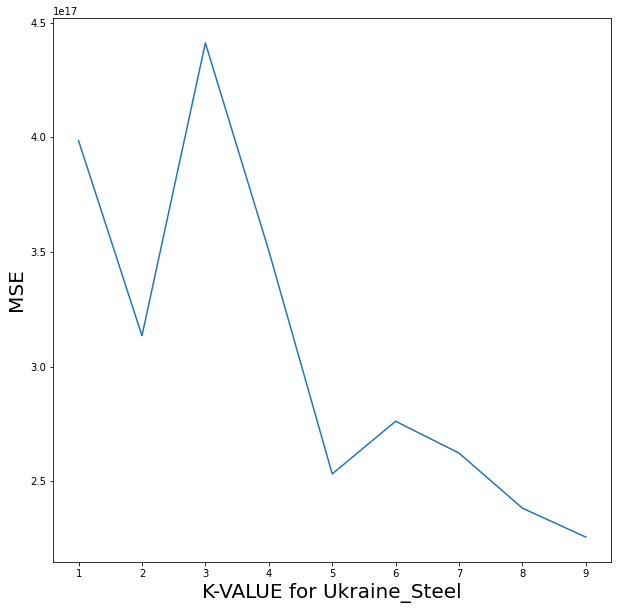

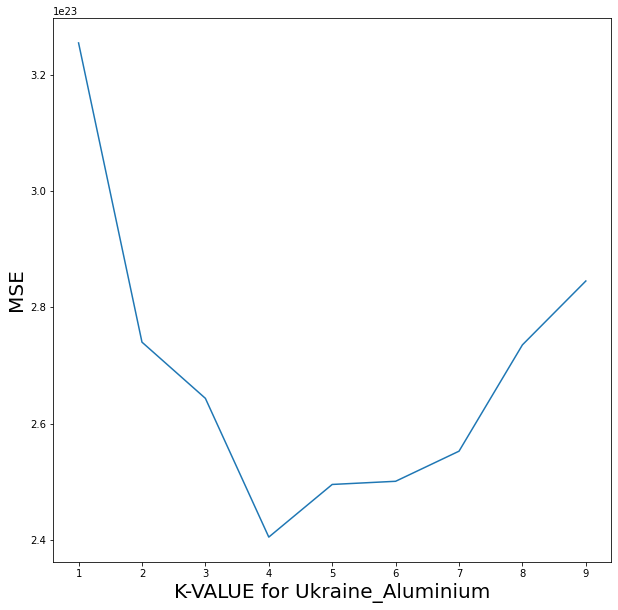

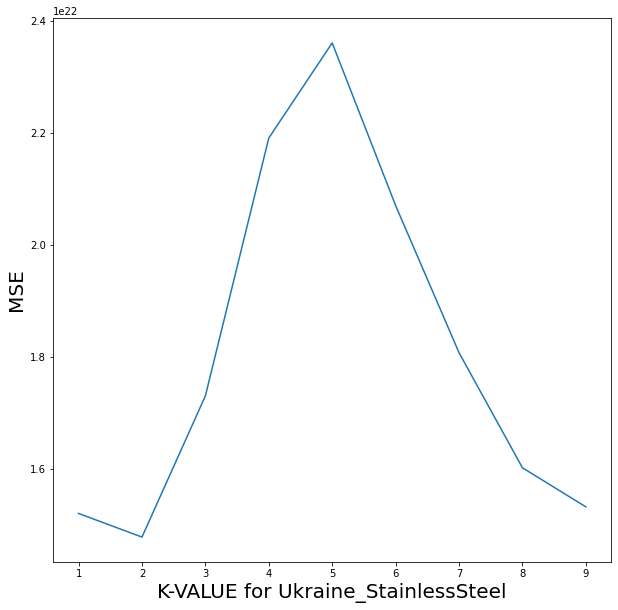

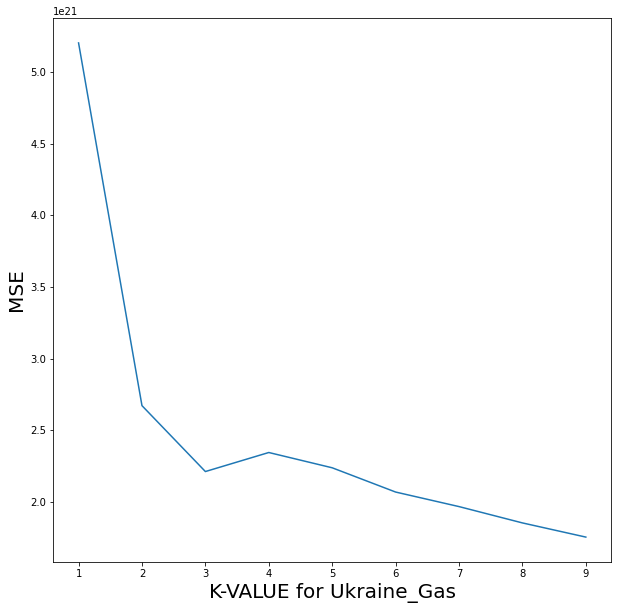

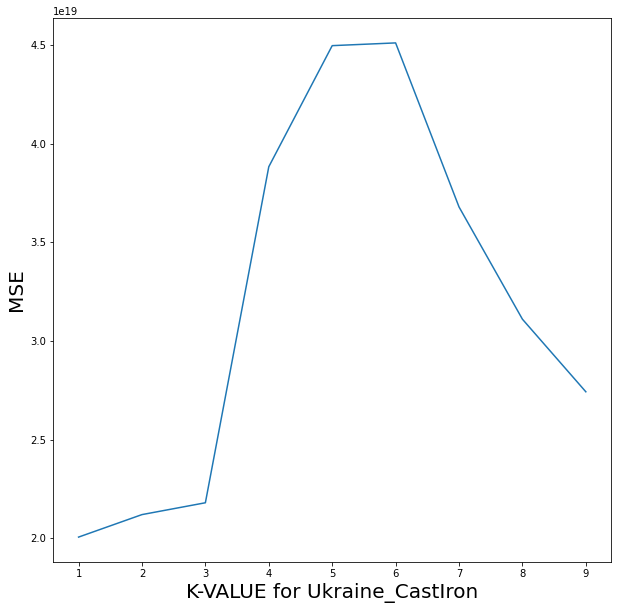

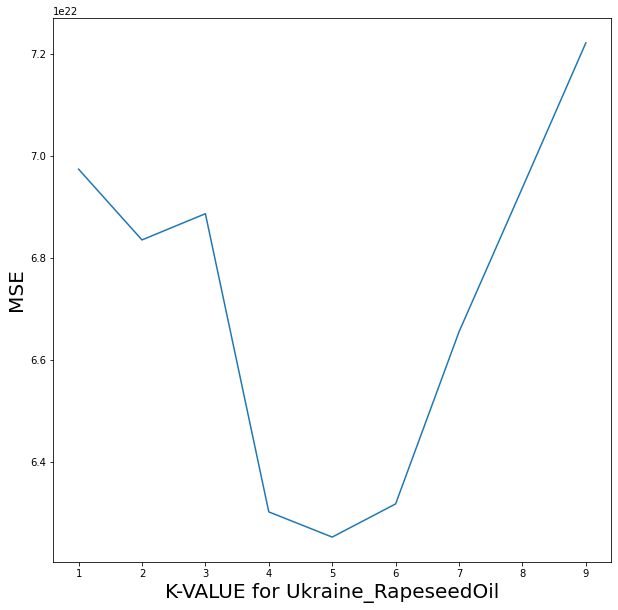

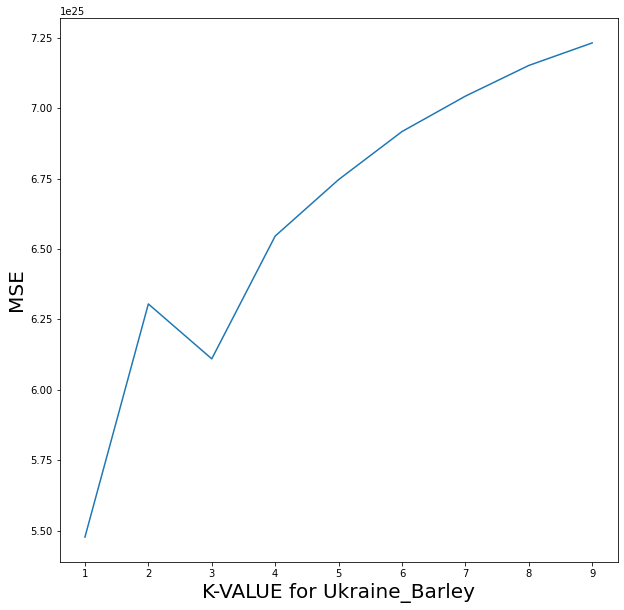

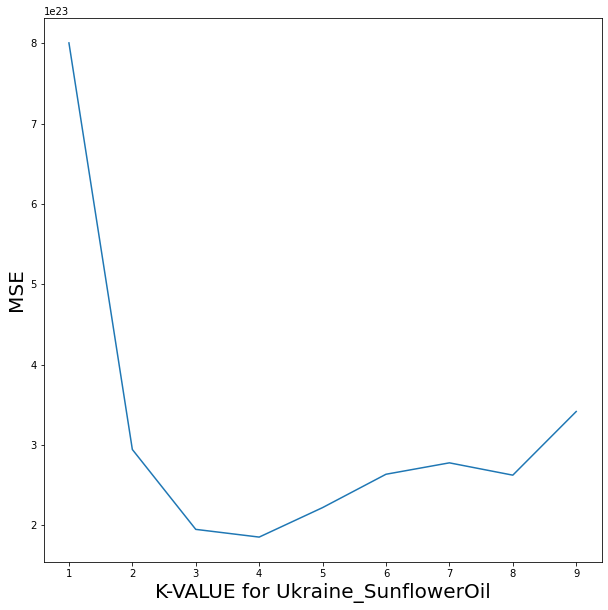

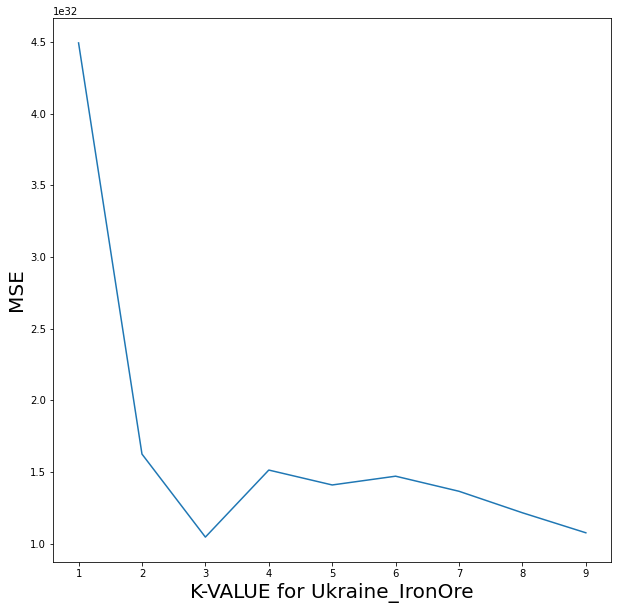

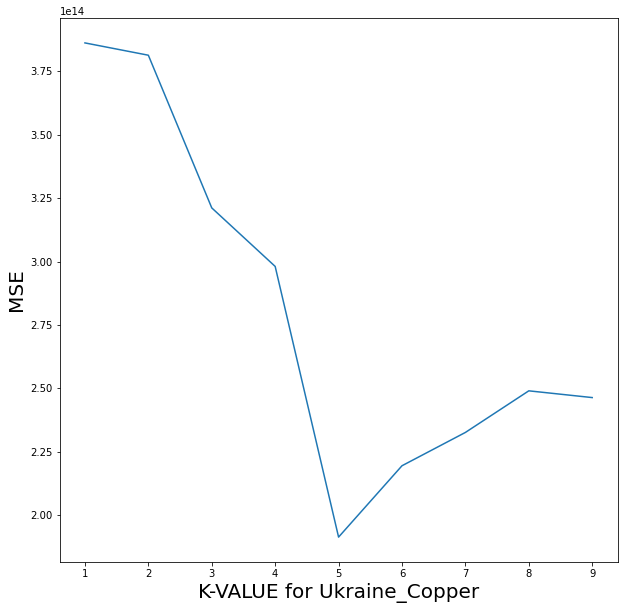

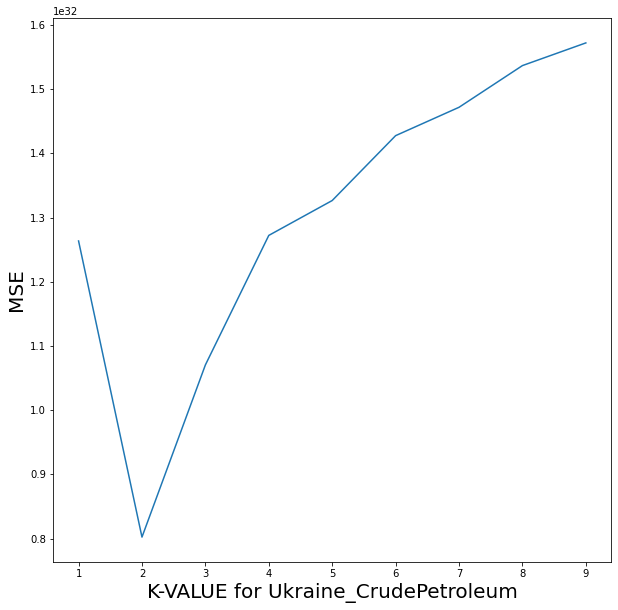

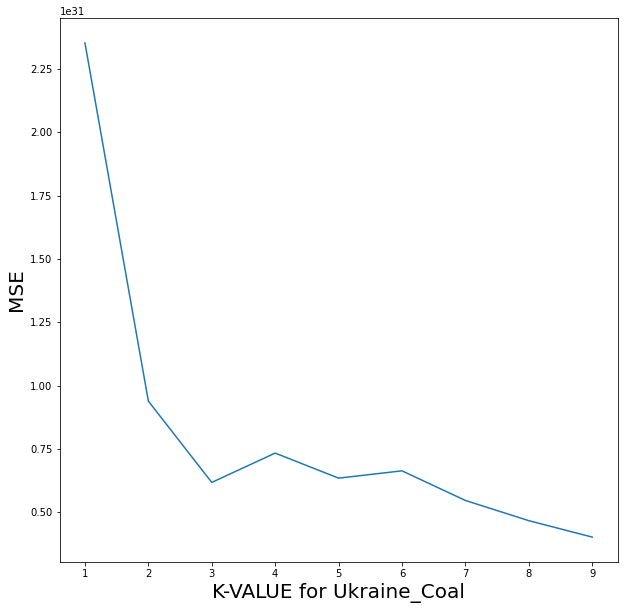

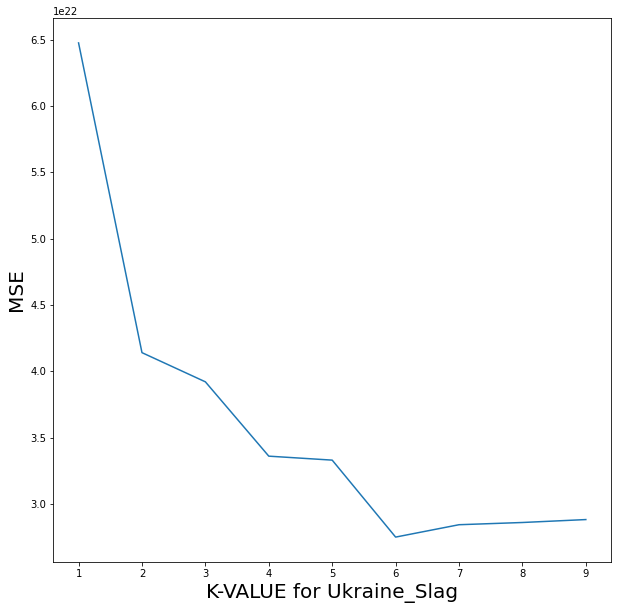

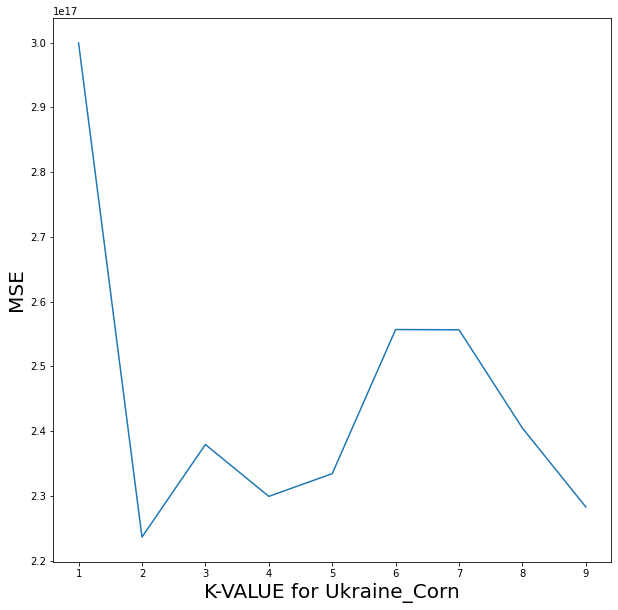

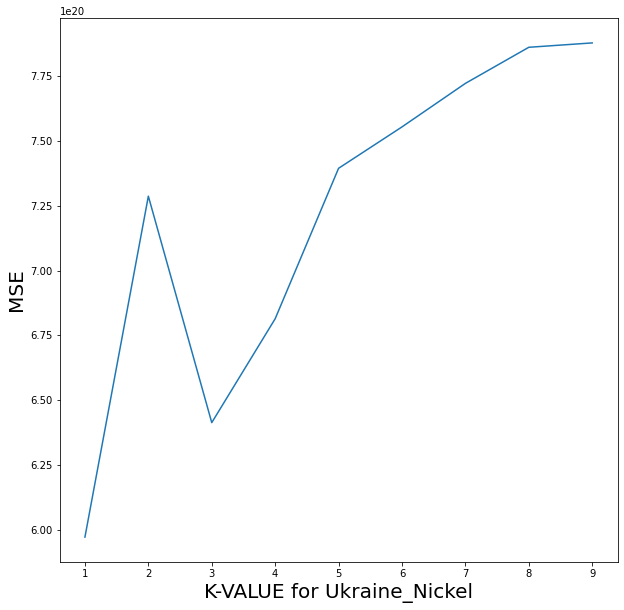

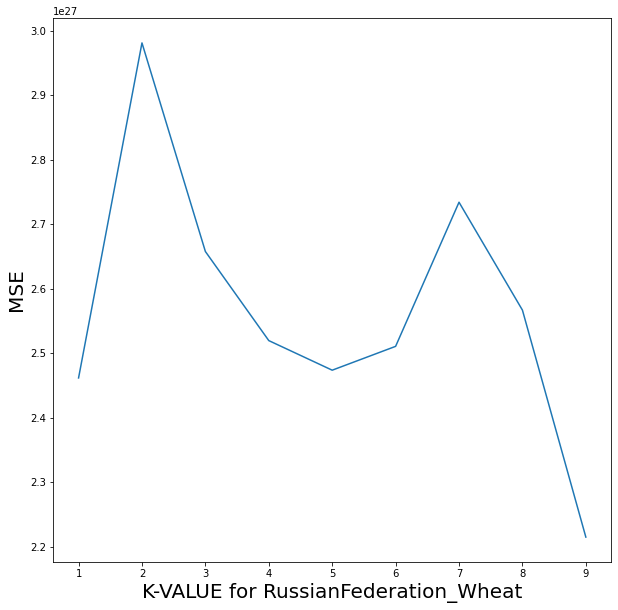

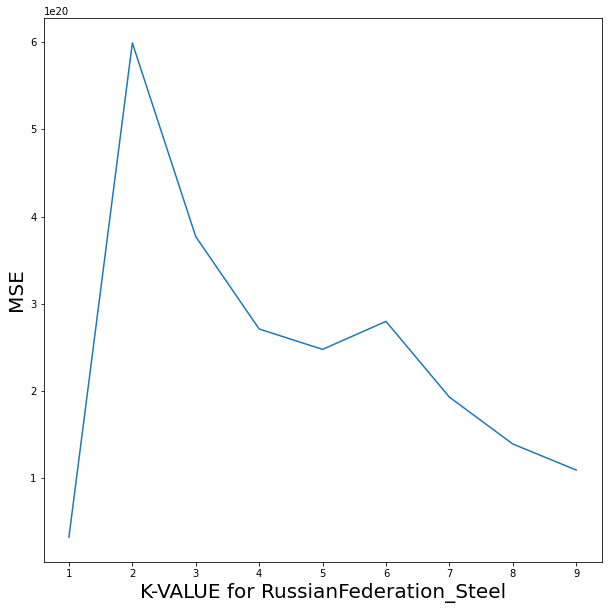

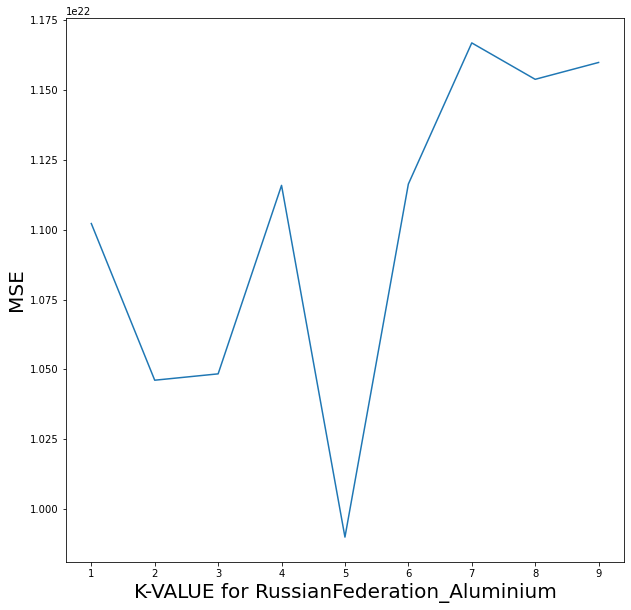

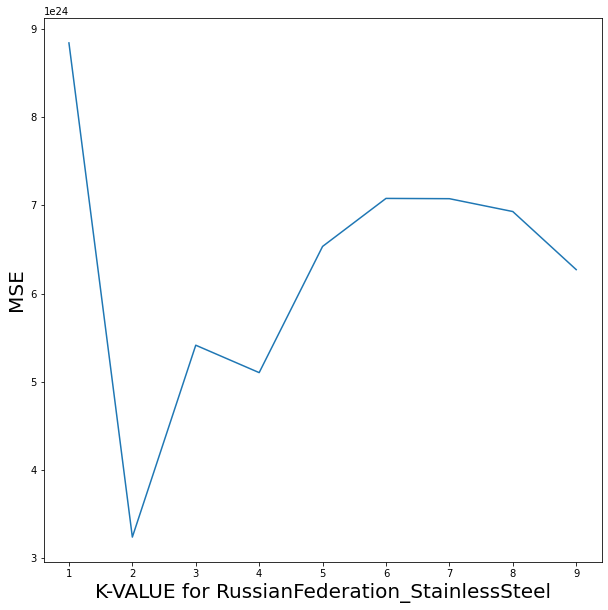

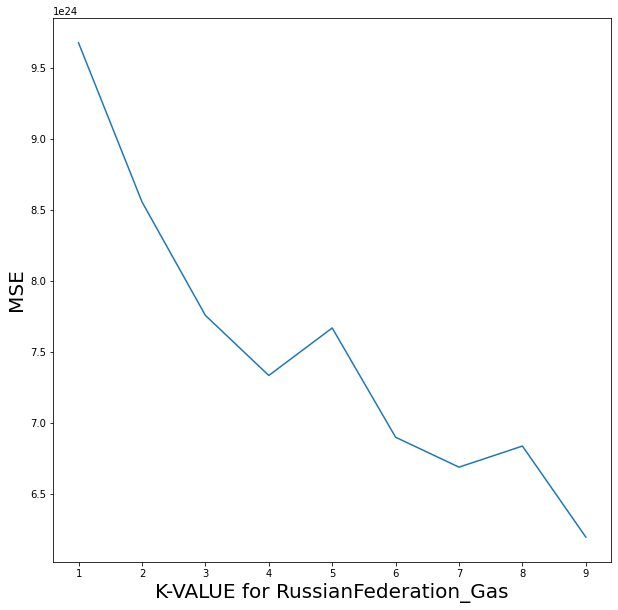

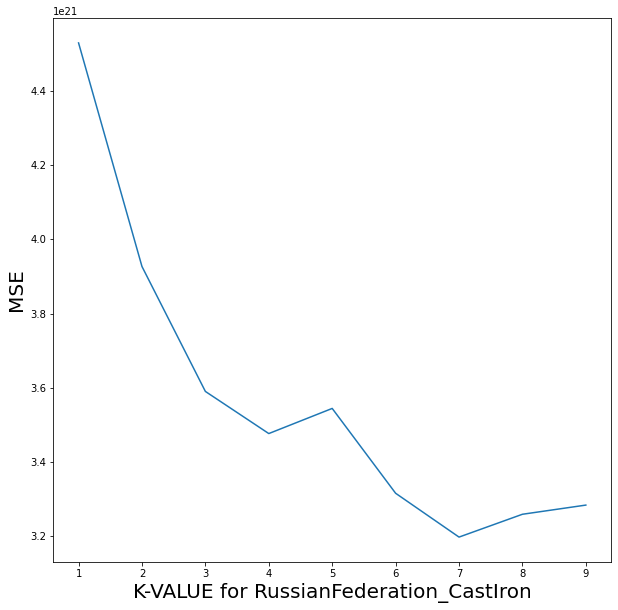

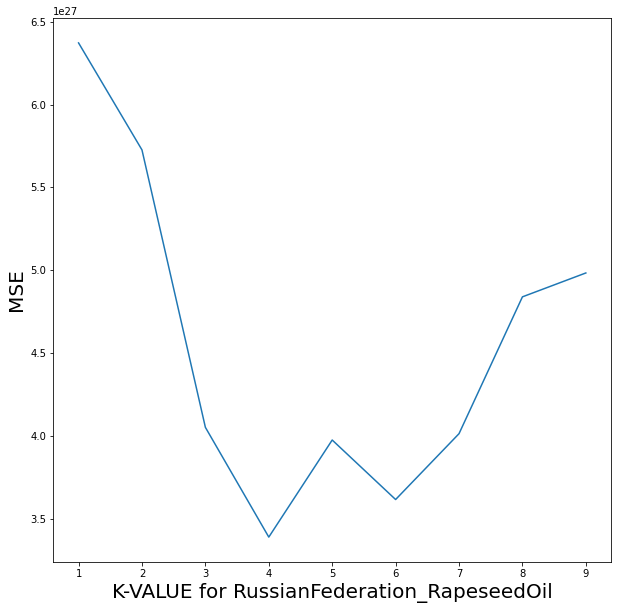

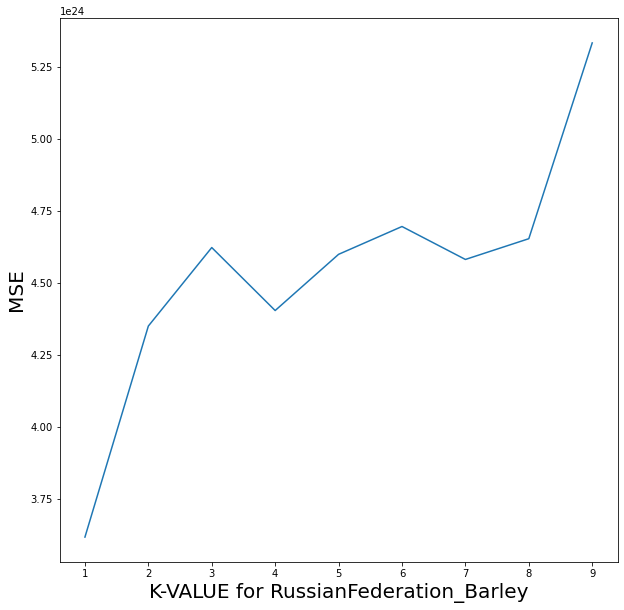

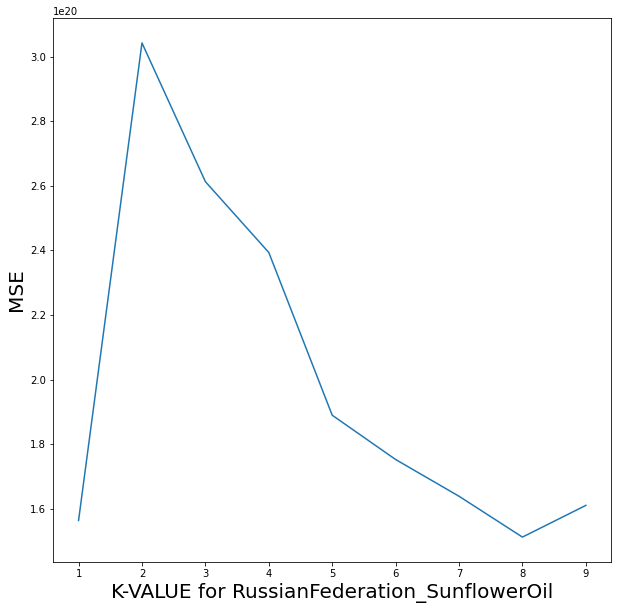

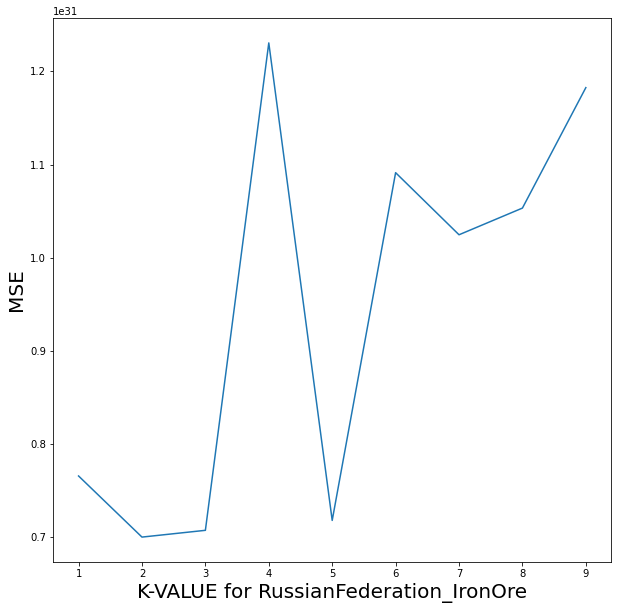

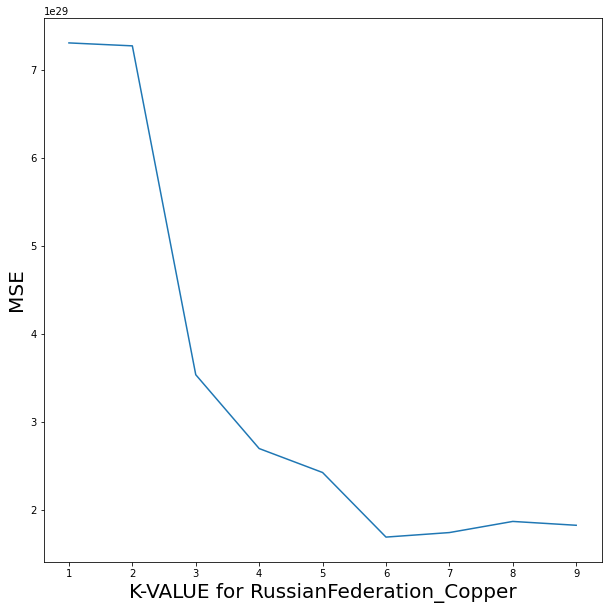

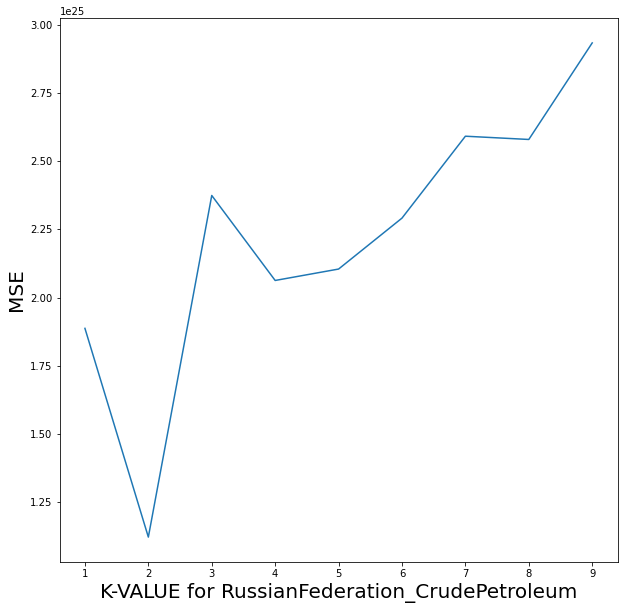

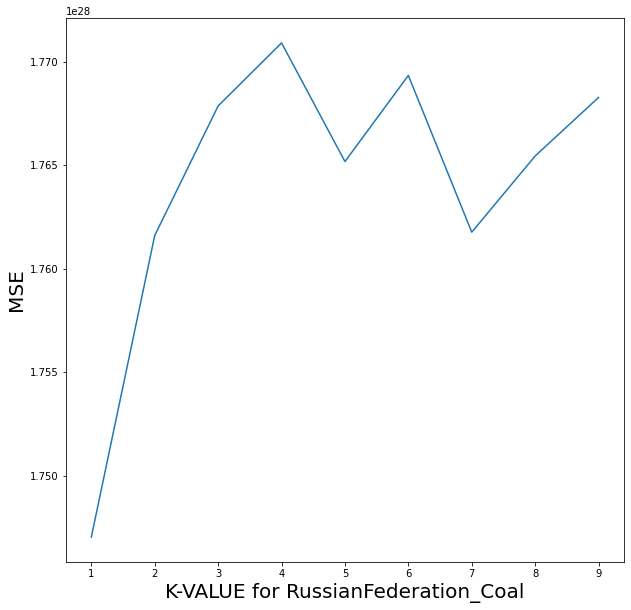

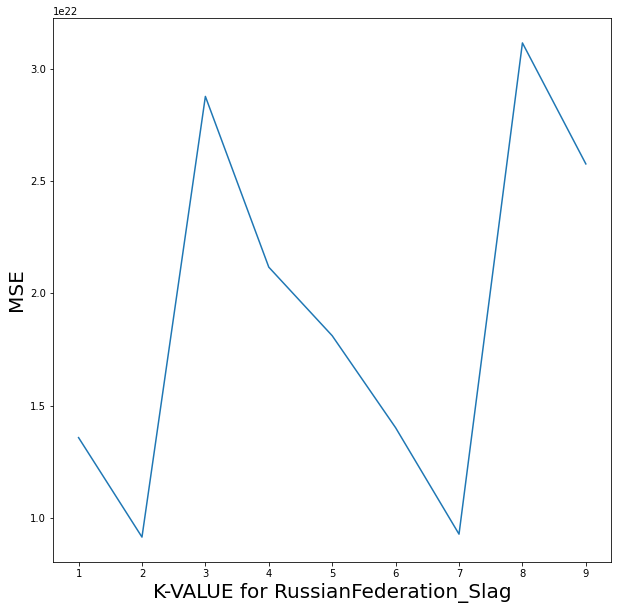

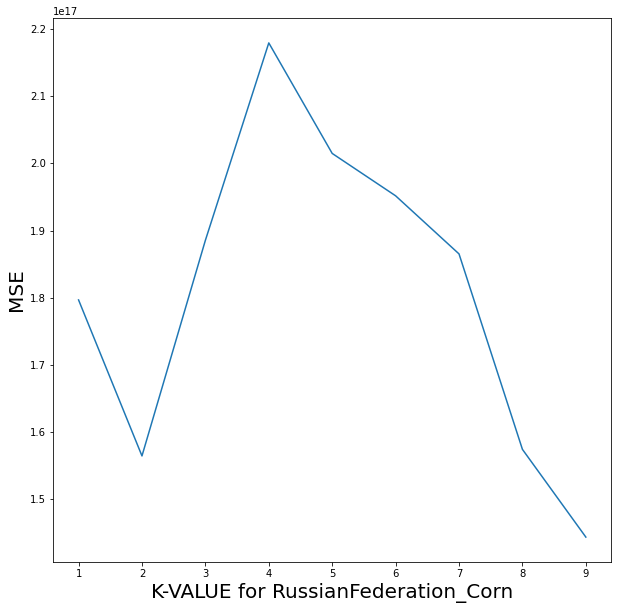

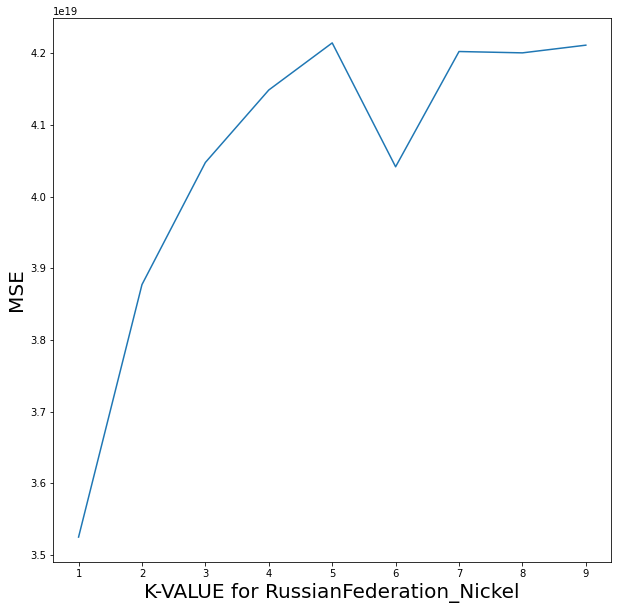

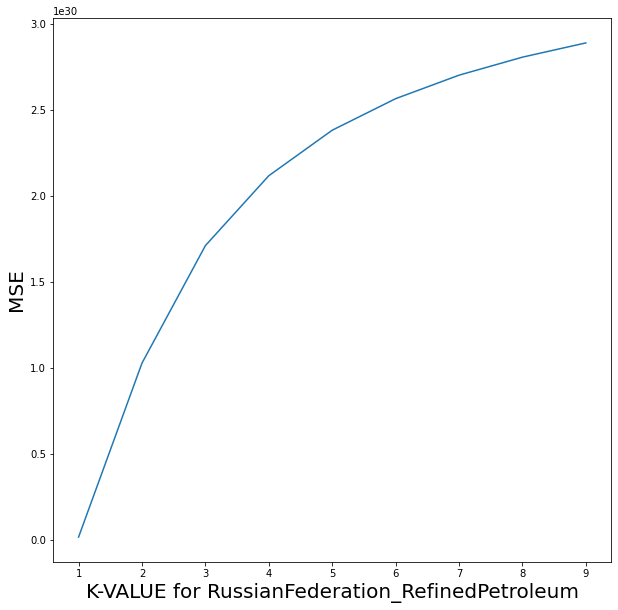

In [21]:
######################################################################################################################
#                                   Various Regression Models.                                                       #
#--------------------------------------------------------------------------------------------------------------------#
######################################################################################################################




for df_name in df_list:  
    # print(df_name.split("_")[1] + "_" + df_name.split("_")[3])
    
    if locals()[df_name].shape[0] > 1:
        X=locals()[df_name].drop(columns="TOTAL_SOLD_USD")
        Y=locals()[df_name]['TOTAL_SOLD_USD']
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2,random_state=0)
######################################################################################################################        
#                                       KNN Neighbor(10 neighbors)                                                   #
######################################################################################################################
        fig,ax=plt.subplots(figsize=(10,10))
        k_list=np.arange(1,10,1)
        knn_dict={}
        for i in k_list:
            KNN_regression_model=neighbors.KNeighborsRegressor(n_neighbors=int(i))
            model_knn=KNN_regression_model.fit(x_train, y_train)
            y_knn_pred=model_knn.predict(x_test)
            KNN_regression_model_mse=mean_squared_error(y_test,y_knn_pred)
            knn_dict[i]=KNN_regression_model_mse
        ax.plot(knn_dict.keys(),knn_dict.values())
        ax.set_xlabel('K-VALUE for ' + df_name.split("_")[1] + "_" + df_name.split("_")[3], fontsize=20)
        ax.set_ylabel('MSE' ,fontsize=20)
        


In [22]:
##Interactive Map

In [23]:
import pandas as pd
import folium
import ipywidgets as widgets  
from ipywidgets import SelectMultiple, SelectionRangeSlider
from tabulate import tabulate

In [24]:
# Read in the War Data Set
war_data = pd.read_csv(r'data/war_events.csv', usecols=['YEAR_MONTH', 'Date Mapper', 'EVENT_TYPE', 'SUB_EVENT_TYPE', 'ADMIN1', 'LATITUDE', 'LONGITUDE', 'FATALITIES', 'NOTES'])

war_data = war_data[war_data.ADMIN1.notnull()]
# Read in Exports Data and Rename for Merging
mapper = pd.read_pickle(r'data/commodity_mapper.pickle').set_index('Original').to_dict()['New']

exports = pd.read_csv(r'data/commodity_exports.csv', usecols=['Date Mapper', 'Partner', 'Commodity', 'Netweight (kg)', 'Trade Value (US$)'])

exports['Commodity'] = exports['Commodity'].map(mapper)

exports = exports[exports['Partner'] == 'Ukraine']

# Read in Price Data
prices = pd.read_csv(r'data/commodity_prices.csv')

# Convert Dates to DateTime
prices['Date'], exports['Date Mapper'], war_data['Date Mapper'] = pd.to_datetime(prices['Date']), pd.to_datetime(exports['Date Mapper']), pd.to_datetime(war_data['Date Mapper'])


# Prep for Merge
prices['map'] = prices['Date'].astype(str) + prices['Commodity']

exports['map'] = exports['Date Mapper'].astype(str) + exports['Commodity']

# TODO
# ADD how prices and exports changed after events
commodity_data = exports.merge(prices, how='left', on='map')
commodity_data = commodity_data[commodity_data.Commodity_x != 'Drop']
commodity_data = commodity_data[['Date Mapper', 'Partner', 'Commodity_x', 'Netweight (kg)', 'Trade Value (US$)', 'Amount']]
commodity_data.rename(columns={'Commodity_x':'Commodity'}, inplace=True)
commodity_data['Date'] = commodity_data['Date Mapper'].dt.strftime('%b-%y')

color_map = {'2018': '#DD351A',
             '2019': '#4EA244',
             '2020': '#679FD7',
             '2021': '#D7D767',
             '2022': '#C967D7'}

/var/folders/f2/hsjy4hyj5ng0q9dlrpfcn0ph0000gn/T/ipykernel_50484/4105023268.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  war_data = pd.read_csv(r'data/war_events.csv', usecols=['YEAR_MONTH', 'Date Mapper', 'EVENT_TYPE', 'SUB_EVENT_TYPE', 'ADMIN1', 'LATITUDE', 'LONGITUDE', 'FATALITIES', 'NOTES'])
/var/folders/f2/hsjy4hyj5ng0q9dlrpfcn0ph0000gn/T/ipykernel_50484/4105023268.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices['Date'], exports['Date Mapper'], war_data['Date Mapper'] = pd.to_datetime(prices['Date']), pd.to_datetime(exports['Date Mapper']), pd.to_datetime(war_data['Date Mapper'])


In [25]:
def generate_map(date: list, event_type: list, region: list, commodity: list) -> 'Subsected DataFrame':
    
    try:
        map_data = war_data[(war_data['YEAR_MONTH'].isin(date))
                        &(war_data['EVENT_TYPE'].isin(event_type))
                        &(war_data['ADMIN1'].isin(region))]
        
        table_data = commodity_data[(commodity_data['Commodity'].isin(commodity)) 
                        &(commodity_data['Date'].isin(date))]
    
    # Account for Non-Selection when rendered
    except IndexError:
        return 'No Data For Selected Parameters'

    # Create the Interative Map
    i_map = folium.Map(
            location=[war_data["LATITUDE"].mean(), war_data["LONGITUDE"].mean()-3.5],
            tiles='openstreetmap',
            zoom_start=5.5,
            zoom_control=False,
            scrollWheelZoom=False,
            dragging=False)

    #TODO Make Prettier
    #Create Markers where events happened
    map_data.apply(
        lambda row: folium.CircleMarker(
            location=[row['LATITUDE'], row['LONGITUDE']],
            radius=(row['FATALITIES'] + 2)/5,
            tooltip='Click here for more info',
            popup=row['NOTES'],
            stroke=True,
            weight=2,
            color=color_map['20' + row['YEAR_MONTH'][-2:]],
            fill=True,
            fill_color=color_map['20' + row['YEAR_MONTH'][-2:]],
            opacity=0.9,
            fill_opacity=0.3,
            ).add_to(i_map),
        axis=1)
    
    # Group Data for Pivot
    grouped_war_data = map_data.groupby(['YEAR_MONTH', 'EVENT_TYPE', 'ADMIN1']).count().reset_index()
    # Subsect Data
    grouped_war_data = grouped_war_data[grouped_war_data.columns[:4]]
    # Rename Columns
    grouped_war_data.columns = [*grouped_war_data.columns[:-1], 'Count']
    # Display Column
    print(tabulate(grouped_war_data.sort_values(by='Count', ascending=False),headers=[*grouped_war_data.columns], tablefmt='github', showindex=False), '\n')
    print(tabulate(table_data.groupby(by=['Date', 'Commodity']).median().reset_index(), headers=[*table_data.columns], tablefmt='github', showindex=False))
    return i_map
    

# Display Interactive Table and Graph
_ = widgets.interact(
    generate_map, 
    date = SelectMultiple(options=war_data['YEAR_MONTH'].unique()),
    event_type = SelectMultiple(options=sorted(war_data['EVENT_TYPE'].unique())), 
    region = SelectMultiple(options=sorted(war_data['ADMIN1'].unique())),
    commodity = SelectMultiple(options=sorted(commodity_data['Commodity'].unique()))

)

interactive(children=(SelectMultiple(description='date', options=('Jan-18', 'Feb-18', 'Mar-18', 'Apr-18', 'May…

In [26]:
#Correlation

In [27]:
#read file
filename = 'data/commodity_exports.csv'
exports = pd.read_csv(filename, encoding = "ISO-8859-1")
#replace elements in commodity column
exports['Commodity'].replace({"Dog or cat food; (not put up for retail sale), used in animal feeding":"AnimalFodder",
                         "Wheat and meslin":"Wheat",
                         "Iron ores and concentrates; including roasted iron pyrites":"IronOre",
                         "Slag, dross; (other than granulated slag), scalings and other waste from the manufacture of iron or steel":"Slag",
                         "Base metals, silver or gold, clad with platinum; not further worked than semi-manufactured":"GoldOre",
                         "Cereal groats and meal; of maize (corn)":"Corn",
                         "Vegetable oils; sunflower seed or safflower oil and their fractions, other than crude, whether or not refined, but not chemically modified":"SunflowerOil",
                         "Vegetable oils; low erucic acid rape or colza oil and its fractions, crude":"RapeseedOil",
                         "Copper ores and concentrates":"Copper",
                         "Coal; anthracite, whether or not pulverised, but not agglomerated":"Coal",
                         "Oils; petroleum oils and oils obtained from bituminous minerals, crude":"CrudePetroleum",
                         "Petroleum gases and other gaseous hydrocarbons; liquefied, natural gas":"RefinedPetroleum",
                         "Iron or steel, pig iron, spiegeleisen; granules thereof":"Steel",
                         "Steel, stainless; cold-drawn or cold-rolled, tubes and pipes of circular cross-section":"RolledSteel",
                         "Cooking appliances and plate warmers; for gas fuel or for both gas and other fuels, of iron or steel":"Gas",
                         "Steel, stainless; table, kitchen and other household articles and parts thereof":"StainlessSteel",
                         "Iron or steel; cast articles, excluding grinding balls and similar articles for mills, other than of non-malleable cast iron":"CastIron",
                         "Nickel; unwrought, not alloyed":"Nickel",
                         "Aluminium; unwrought, alloys":"Aluminium",
                         "Barley":"Barley"
                         },inplace=True)
exports.head()



Classification  Year  Period Date Mapper Period Desc.  Aggregate Level  \
0             HS  2018  201803      3/1/18       18-Mar                6   
1             HS  2018  201809      9/1/18       18-Sep                4   
2             HS  2018  201809      9/1/18       18-Sep                6   
3             HS  2018  201809      9/1/18       18-Sep                6   
4             HS  2018  201802      2/1/18       18-Feb                6   

   Is Leaf Code  Trade Flow Code Trade Flow  Reporter Code  ... Qty  \
0             1                2    Exports             36  ... NaN   
1             0                2    Exports            203  ... NaN   
2             1                2    Exports            203  ... NaN   
3             1                2    Exports            203  ... NaN   
4             1                2    Exports            276  ... NaN   

   Alt Qty Unit Code  Alt Qty Unit Alt Qty  Netweight (kg)  Gross weight (kg)  \
0                NaN           NaN     NaN         21000.0                NaN   
1                NaN           NaN     NaN         48000.0                NaN   
2                NaN           NaN     NaN           277.0                NaN   
3                NaN           NaN     NaN         44525.0                NaN   
4                NaN           NaN     NaN          1279.0                NaN   

   Trade Value (US$)  CIF Trade Value (US$)  FOB Trade Value (US$)  Flag  
0              61918                    NaN                    NaN     0  
1              47083                    NaN                    NaN     0  
2               2541                    NaN                    NaN     0  
3             178524                    NaN                    NaN     0  
4             112085                    NaN                    NaN     0  

[5 rows x 36 columns]

In [28]:

#clean up dataframe - remove columns with Nan
nan_value = float("NaN")
exports.dropna(how='all',axis=1,inplace=True)
display(exports)

Classification  Year  Period Date Mapper Period Desc.  Aggregate Level  \
0                 HS  2018  201803      3/1/18       18-Mar                6   
1                 HS  2018  201809      9/1/18       18-Sep                4   
2                 HS  2018  201809      9/1/18       18-Sep                6   
3                 HS  2018  201809      9/1/18       18-Sep                6   
4                 HS  2018  201802      2/1/18       18-Feb                6   
...              ...   ...     ...         ...          ...              ...   
15718             HS  2018  201807      7/1/18        1-Jul                6   
15719             HS  2018  201806      6/1/18        1-Jun                6   
15720             HS  2018  201812     12/1/18        1-Dec                6   
15721             HS  2018  201803      3/1/18        1-Mar                4   
15722             HS  2018  201811     11/1/18        1-Nov                4   

       Is Leaf Code  Trade Flow Code Trade Flow  Reporter Code    Reporter  \
0                 1                2    Exports             36   Australia   
1                 0                2    Exports            203  Czech Rep.   
2                 1                2    Exports            203  Czech Rep.   
3                 1                2    Exports            203  Czech Rep.   
4                 1                2    Exports            276     Germany   
...             ...              ...        ...            ...         ...   
15718             1                2    Exports             97          EU   
15719             1                2    Exports            112     Belarus   
15720             1                2    Exports             97          EU   
15721             0                2    Exports            440   Lithuania   
15722             0                2    Exports            440   Lithuania   

       Partner Code             Partner  Commodity Code       Commodity  \
0               804             Ukraine          230990    AnimalFodder   
1               804             Ukraine            1003          Barley   
2               804             Ukraine          732393  StainlessSteel   
3               804             Ukraine          732111             Gas   
4               804             Ukraine          732599        CastIron   
...             ...                 ...             ...             ...   
15718           804             Ukraine          720510           Steel   
15719           643  Russian Federation          720510           Steel   
15720           643  Russian Federation          720510           Steel   
15721           643  Russian Federation            1001           Wheat   
15722           643  Russian Federation            1001           Wheat   

       Netweight (kg)  Trade Value (US$)  Flag  
0             21000.0              61918     0  
1             48000.0              47083     0  
2               277.0               2541     0  
3             44525.0             178524     0  
4              1279.0             112085     0  
...               ...                ...   ...  
15718         10016.0              13816     0  
15719        755000.0             370600     0  
15720         37845.0              96235     0  
15721         20000.0               7396     0  
15722         20000.0               6819     0  

[15723 rows x 18 columns]

In [29]:
#groupby Partner
p = exports.groupby('Partner')
p.first()

Classification  Year  Period Date Mapper Period Desc.  \
Partner                                                                    
Russian Federation             HS  2018  201803      3/1/18        1-Mar   
Ukraine                        HS  2018  201803      3/1/18       18-Mar   

                    Aggregate Level  Is Leaf Code  Trade Flow Code Trade Flow  \
Partner                                                                         
Russian Federation                6             1                2    Exports   
Ukraine                           6             1                2    Exports   

                    Reporter Code   Reporter  Partner Code  Commodity Code  \
Partner                                                                      
Russian Federation             36  Australia           643          230990   
Ukraine                        36  Australia           804          230990   

                       Commodity  Netweight (kg)  Trade Value (US$)  Flag  
Partner                                                                    
Russian Federation  AnimalFodder         21000.0              65054     0  
Ukraine             AnimalFodder         21000.0              61918     0

<AxesSubplot:title={'center':'Types of Partners'}>

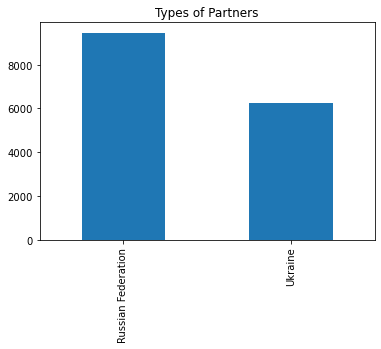

In [30]:

#create bar chart
title=("Types of Partners")
exports.Partner.value_counts().plot(kind='bar',title=title)

<AxesSubplot:title={'center':'Number of Commodity Occurrences from 2018-2022'}>

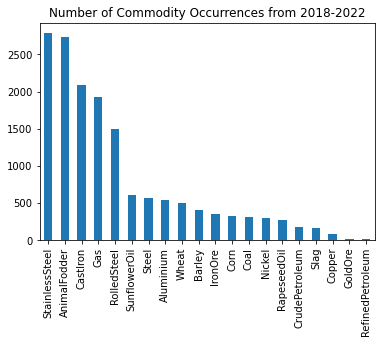

In [31]:

#create bar chart
title=("Number of Commodity Occurrences from 2018-2022")
exports.Commodity.value_counts().plot(kind='bar',title=title)

In [32]:

#groupby Period
gk = exports.groupby('Period')
gk.first()

Classification  Year Date Mapper Period Desc.  Aggregate Level  \
Period                                                                  
201801             HS  2018      1/1/18       18-Jan                6   
201802             HS  2018      2/1/18       18-Feb                6   
201803             HS  2018      3/1/18       18-Mar                6   
201804             HS  2018      4/1/18       18-Apr                6   
201805             HS  2018      5/1/18       18-May                6   
201806             HS  2018      6/1/18       18-Jun                6   
201807             HS  2018      7/1/18       18-Jul                6   
201808             HS  2018      8/1/18       18-Aug                4   
201809             HS  2018      9/1/18       18-Sep                4   
201810             HS  2018     10/1/18       18-Oct                6   
201811             HS  2018     11/1/18       18-Nov                6   
201812             HS  2018     12/1/18       18-Dec                6   
201901             HS  2019      1/1/19       19-Jan                6   
201902             HS  2019      2/1/19       19-Feb                6   
201903             HS  2019      3/1/19       19-Mar                6   
201904             HS  2019      4/1/19       19-Apr                6   
201905             HS  2019      5/1/19       19-May                6   
201906             HS  2019      6/1/19       19-Jun                6   
201907             HS  2019      7/1/19       19-Jul                6   
201908             HS  2019      8/1/19       19-Aug                6   
201909             HS  2019      9/1/19       19-Sep                6   
201910             HS  2019     10/1/19       19-Oct                6   
201911             HS  2019     11/1/19       19-Nov                6   
201912             HS  2019     12/1/19       19-Dec                6   
202001             HS  2020      1/1/20       20-Jan                6   
202002             HS  2020      2/1/20       20-Feb                4   
202003             HS  2020      3/1/20       20-Mar                4   
202004             HS  2020      4/1/20       20-Apr                6   
202005             HS  2020      5/1/20       20-May                6   
202006             HS  2020      6/1/20       20-Jun                6   
202007             HS  2020      7/1/20       20-Jul                6   
202008             HS  2020      8/1/20       20-Aug                4   
202009             HS  2020      9/1/20       20-Sep                6   
202010             HS  2020     10/1/20       20-Oct                6   
202011             HS  2020     11/1/20       20-Nov                6   
202012             HS  2020     12/1/20       20-Dec                6   
202101             HS  2021      1/1/21       21-Jan                6   
202102             HS  2021      2/1/21       21-Feb                6   
202103             HS  2021      3/1/21       21-Mar                6   
202104             HS  2021      4/1/21       21-Apr                6   
202105             HS  2021      5/1/21       21-May                4   
202106             HS  2021      6/1/21       21-Jun                4   
202107             HS  2021      7/1/21       21-Jul                6   
202108             HS  2021      8/1/21       21-Aug                6   
202109             HS  2021      9/1/21       21-Sep                6   
202110             HS  2021     10/1/21       21-Oct                6   
202111             HS  2021     11/1/21       21-Nov                6   
202112             HS  2021     12/1/21       21-Dec                6   
202201             HS  2022      1/1/22       22-Jan                6   
202202             HS  2022      2/1/22       22-Feb                6   
202203             HS  2022      3/1/22       22-Mar                6   
202204             HS  2022      4/1/22       22-Apr                6   
202205             HS  2022      5/1/22       22-May             

In [33]:

#groupby Year
gk = exports.groupby('Year')
gk.first()


Classification  Period Date Mapper Period Desc.  Aggregate Level  \
Year                                                                    
2018             HS  201803      3/1/18       18-Mar                6   
2019             HS  201902      2/1/19       19-Feb                6   
2020             HS  202012     12/1/20       20-Dec                6   
2021             HS  202108      8/1/21       21-Aug                6   
2022             HS  202205      5/1/22       22-May                6   

      Is Leaf Code  Trade Flow Code Trade Flow  Reporter Code  \
Year                                                            
2018             1                2    Exports             36   
2019             1                2    Exports            705   
2020             1                2    Exports            792   
2021             1                2    Exports            643   
2022             1                2    Exports            440   

                Reporter  Partner Code  Partner  Commodity Code  \
Year                                                              
2018           Australia           804  Ukraine          230990   
2019            Slovenia           804  Ukraine          732393   
2020              Turkey           804  Ukraine          732111   
2021  Russian Federation           804  Ukraine          760120   
2022           Lithuania           804  Ukraine          732393   

           Commodity  Netweight (kg)  Trade Value (US$)  Flag  
Year                                                           
2018    AnimalFodder         21000.0              61918     0  
2019  StainlessSteel             2.0                 64     0  
2020             Gas         94154.0             394989     0  
2021       Aluminium          6575.0              19902     0  
2022  StainlessSteel             2.0                 10     0

In [34]:
#groupby year 2018
year18 = gk.get_group(2018)
year18.rename(columns={"Commodity":"Commodity_18"}, inplace=True)
#gk.get_group(2018)


#groupby year 2019
year19 = gk.get_group(2019)
year19.rename(columns={"Commodity":"Commodity_19"},inplace=True)
#gk.get_group(2019)


#groupby year 2020
year20 = gk.get_group(2020)
year20.rename(columns={"Commodity":"Commodity_20"},inplace=True)
#gk.get_group(2020)

#groupby year 2021
year21 = gk.get_group(2021)
year21.rename(columns={"Commodity":"Commodity_21"},inplace=True)
#gk.get_group(2021)

#groupby year 2022
year22 = gk.get_group(2022)
year22.rename(columns={"Commodity":"Commodity_22"}, inplace=True)
#gk.get_group(2022)

/var/folders/f2/hsjy4hyj5ng0q9dlrpfcn0ph0000gn/T/ipykernel_50484/3920213848.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year18.rename(columns={"Commodity":"Commodity_18"}, inplace=True)
/var/folders/f2/hsjy4hyj5ng0q9dlrpfcn0ph0000gn/T/ipykernel_50484/3920213848.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year19.rename(columns={"Commodity":"Commodity_19"},inplace=True)
/var/folders/f2/hsjy4hyj5ng0q9dlrpfcn0ph0000gn/T/ipykernel_50484/3920213848.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

/var/folders/f2/hsjy4hyj5ng0q9dlrpfcn0ph0000gn/T/ipykernel_50484/654150619.py:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


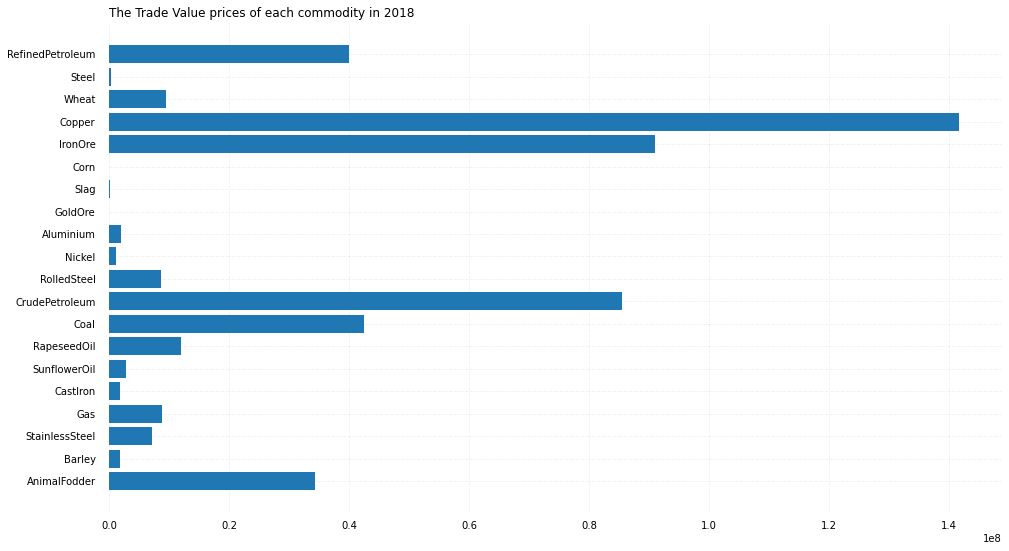

In [35]:
fig, ax = plt.subplots(figsize =(16, 9))
comm = year18['Commodity_18']
price = year18['Trade Value (US$)']

# Horizontal Bar Plot
ax.barh(comm,price)
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

# Add Plot Title
ax.set_title('The Trade Value prices of each commodity in 2018',
             loc ='left', )
 
 
# Show Plot
plt.show()

/var/folders/f2/hsjy4hyj5ng0q9dlrpfcn0ph0000gn/T/ipykernel_50484/1963422920.py:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


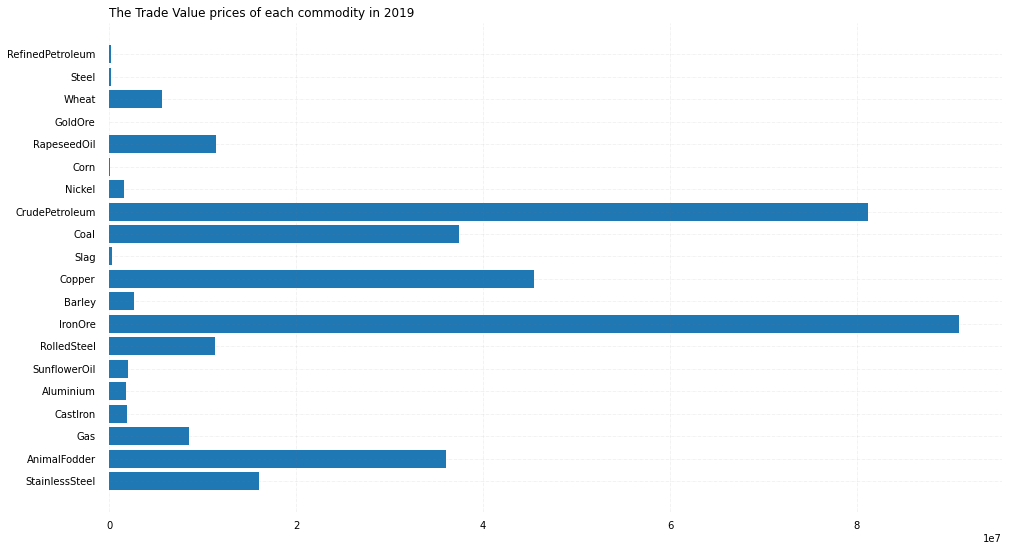

In [36]:
fig, ax = plt.subplots(figsize =(16, 9))
comm = year19['Commodity_19']
price = year19['Trade Value (US$)']

# Horizontal Bar Plot
ax.barh(comm,price)
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

# Add Plot Title
ax.set_title('The Trade Value prices of each commodity in 2019',
             loc ='left', )
 
 
# Show Plot
plt.show()

/var/folders/f2/hsjy4hyj5ng0q9dlrpfcn0ph0000gn/T/ipykernel_50484/2544134785.py:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


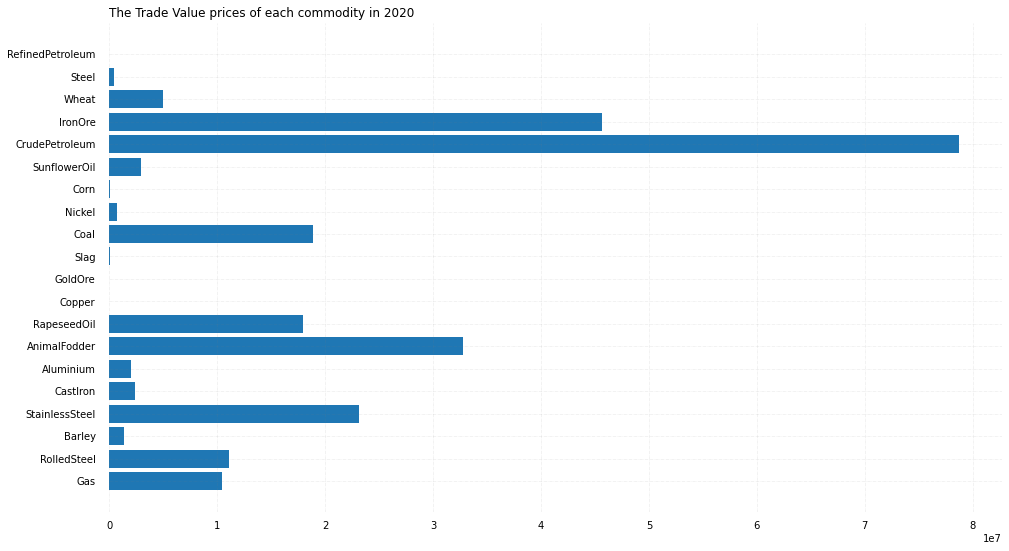

In [37]:
fig, ax = plt.subplots(figsize =(16, 9))
comm = year20['Commodity_20']
price = year20['Trade Value (US$)']

# Horizontal Bar Plot
ax.barh(comm,price)
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

# Add Plot Title
ax.set_title('The Trade Value prices of each commodity in 2020',
             loc ='left', )
 
 
# Show Plot
plt.show()

/var/folders/f2/hsjy4hyj5ng0q9dlrpfcn0ph0000gn/T/ipykernel_50484/3597287175.py:21: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


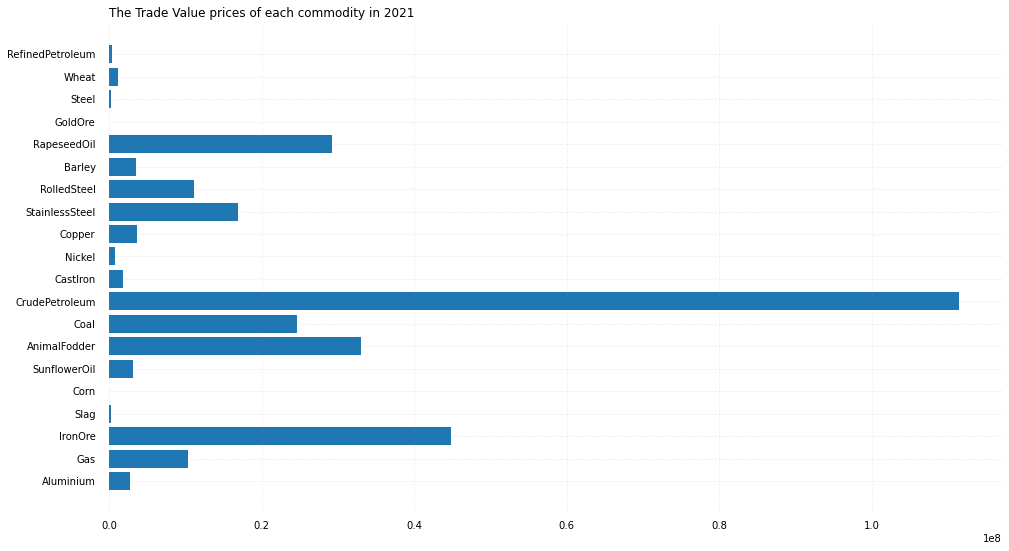

In [38]:
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
comm = year21['Commodity_21']
price = year21['Trade Value (US$)']

# Horizontal Bar Plot
ax.barh(comm,price)
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

# Add Plot Title
ax.set_title('The Trade Value prices of each commodity in 2021',
             loc ='left', )
 
 
# Show Plot
plt.show()


/var/folders/f2/hsjy4hyj5ng0q9dlrpfcn0ph0000gn/T/ipykernel_50484/2267064684.py:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


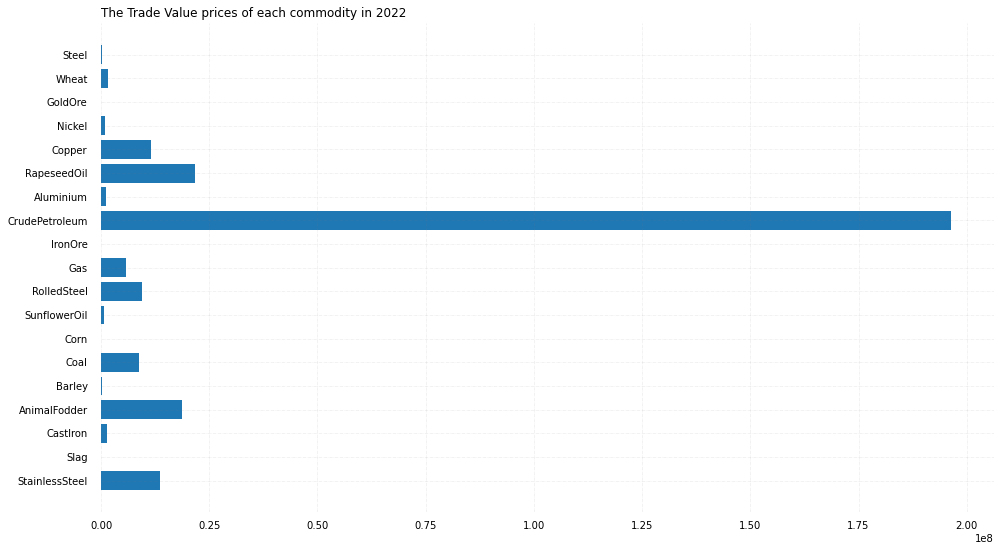

In [39]:
fig, ax = plt.subplots(figsize =(16, 9))
comm = year22['Commodity_22']
price = year22['Trade Value (US$)']

# Horizontal Bar Plot
ax.barh(comm,price)
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

# Add Plot Title
ax.set_title('The Trade Value prices of each commodity in 2022',
             loc ='left', )
 
 
# Show Plot
plt.show()


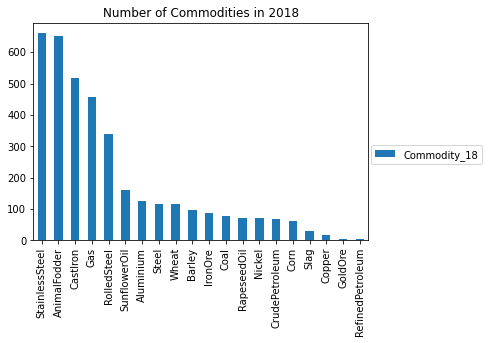

In [40]:

title=("Number of Commodities in 2018")
year18.Commodity_18.value_counts().plot(kind='bar',title=title)
plt.legend(loc=(1.01, 0.35))

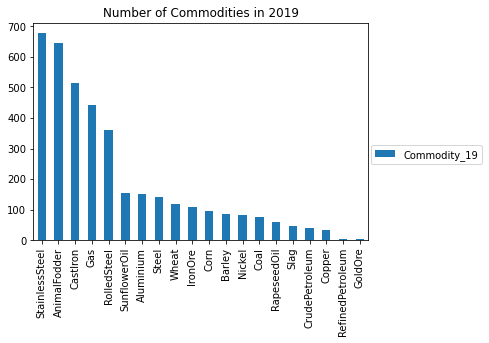

In [41]:

title=("Number of Commodities in 2019")
year19.Commodity_19.value_counts().plot(kind='bar',title=title)
plt.legend(loc=(1.01, 0.35))

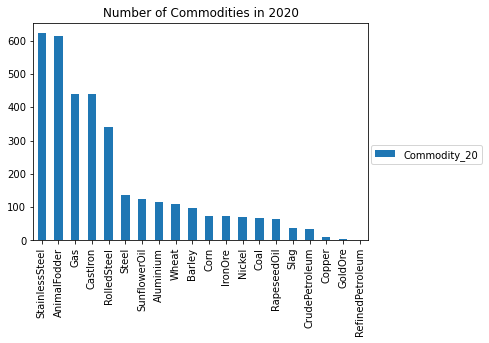

In [42]:
title=("Number of Commodities in 2020")
year20.Commodity_20.value_counts().plot(kind='bar',title=title)
plt.legend(loc=(1.01, 0.35))

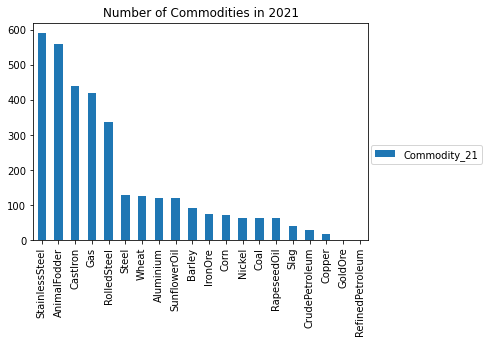

In [43]:

title=("Number of Commodities in 2021")
year21.Commodity_21.value_counts().plot(kind='bar',title=title)
plt.legend(loc=(1.01, 0.35))

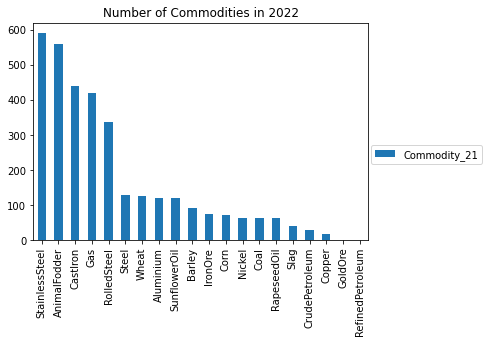

In [44]:
title=("Number of Commodities in 2022")
year21.Commodity_21.value_counts().plot(kind='bar',title=title)
plt.legend(loc=(1.01, 0.35))

In [45]:
year18.agg(['min','max'])

Classification  Year  Period Date Mapper Period Desc.  Aggregate Level  \
min             HS  2018  201801      1/1/18        1-Apr                4   
max             HS  2018  201812      9/1/18       18-Sep                6   

     Is Leaf Code  Trade Flow Code Trade Flow  Reporter Code Reporter  \
min             0                2    Exports             31    ASEAN   
max             1                2    Exports            975  Vietnam   

     Partner Code             Partner  Commodity Code Commodity_18  \
min           643  Russian Federation            1001    Aluminium   
max           804             Ukraine          760120        Wheat   

     Netweight (kg)  Trade Value (US$)  Flag  
min    0.000000e+00                  1     0  
max    1.080383e+09          141755151     0

In [46]:

# The minimum and maximum values of dataframe
year19.agg(['min','max'])

Classification  Year  Period Date Mapper Period Desc.  Aggregate Level  \
min             HS  2019  201901      1/1/19        1-Apr                4   
max             HS  2019  201912      9/1/19       19-Sep                6   

     Is Leaf Code  Trade Flow Code Trade Flow  Reporter Code Reporter  \
min             0                2    Exports             31    ASEAN   
max             1                2    Exports            975  Vietnam   

     Partner Code             Partner  Commodity Code Commodity_19  \
min           643  Russian Federation            1001    Aluminium   
max           804             Ukraine          760120        Wheat   

     Netweight (kg)  Trade Value (US$)  Flag  
min             0.0                  0     0  
max     922754000.0           90958853     0

In [47]:

# The minimum and maximum values of dataframe
year20.agg(['min','max'])

Classification  Year  Period Date Mapper Period Desc.  Aggregate Level  \
min             HS  2020  202001      1/1/20        1-Apr                4   
max             HS  2020  202012      9/1/20       20-Sep                6   

     Is Leaf Code  Trade Flow Code Trade Flow  Reporter Code Reporter  \
min             0                2    Exports             31    ASEAN   
max             1                2    Exports            975  Vietnam   

     Partner Code             Partner  Commodity Code Commodity_20  \
min           643  Russian Federation            1001    Aluminium   
max           804             Ukraine          760120        Wheat   

     Netweight (kg)  Trade Value (US$)  Flag  
min             0.0                  0     0  
max     528663450.0           78751428     0

In [48]:
# The minimum and maximum values of dataframe
year21.agg(['min','max'])

Classification  Year  Period Date Mapper Period Desc.  Aggregate Level  \
min             HS  2021  202101      1/1/21        1-Apr                4   
max             HS  2021  202112      9/1/21       21-Sep                6   

     Is Leaf Code  Trade Flow Code Trade Flow  Reporter Code    Reporter  \
min             0                2    Exports             31     Armenia   
max             1                2    Exports            860  Uzbekistan   

     Partner Code             Partner  Commodity Code Commodity_21  \
min           643  Russian Federation            1001    Aluminium   
max           804             Ukraine          760120        Wheat   

     Netweight (kg)  Trade Value (US$)  Flag  
min             0.0                  0     0  
max     426716350.0          111480592     0

In [49]:

# The minimum and maximum values of dataframe
year22.agg(['min','max'])

Classification  Year  Period Date Mapper Period Desc.  Aggregate Level  \
min             HS  2022  202201      1/1/22        1-Apr                4   
max             HS  2022  202209      9/1/22       22-Sep                6   

     Is Leaf Code  Trade Flow Code Trade Flow  Reporter Code    Reporter  \
min             0                2    Exports             31     Armenia   
max             1                2    Exports            860  Uzbekistan   

     Partner Code             Partner  Commodity Code Commodity_22  \
min           643  Russian Federation            1001    Aluminium   
max           804             Ukraine          760120        Wheat   

     Netweight (kg)  Trade Value (US$)  Flag  
min             0.0                  1     0  
max     336716000.0          196450925     0

In [50]:
models_comparison_matrix2 = pd.DataFrame([],columns=['Regression_Commodity_Partner','Predictive_Analysis_Model', 'Accuracy_Score','Mean_Absolute_Error', 'Root_Mean_Squared_Error'])